In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 31
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "ga-100"
number_of_opt_evaluations = 200
run_i = 8


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


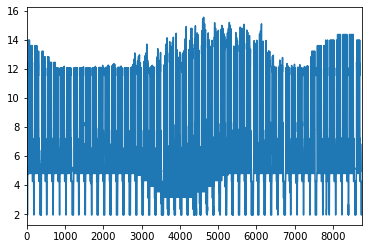

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.508533239364624 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5021750926971436 sec


ERROR:root:Finished Generation of Irradiance


0.0


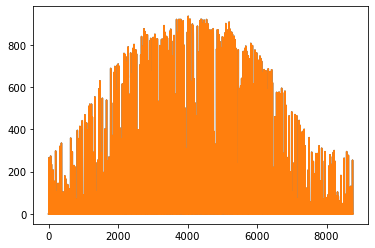

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4607484340667725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.464921474456787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.462106227874756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


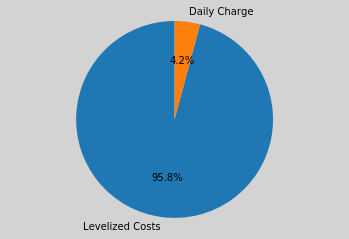

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)


ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.33040007182188, 185.4217119481566, 127.12959305819943, 24.04025300229121, 32.70773291809961, 34.148919218665526, 0.6647654010953746, 0.6189343554373917, 0.3833401751944272)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 24.0
                                           and a gcr of 0.665


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4000141620635986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 32.7
                                           and a gcr of 0.619


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3949599266052246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 127
                                           a tilt of 34.1
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4048354625701904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 299.954, 0.0]


ERROR:ga_logger:Cost: 3112.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,112 per year


Total roof area of the  building: 599 m2
Total roof area used 485 m2
Percentage: 80.9%
succes
[[186.33040007182188, 185.4217119481566, 127.12959305819943, 24.04025300229121, 32.70773291809961, 34.148919218665526, 0.6647654010953746, 0.6189343554373917, 0.3833401751944272, 3112.26, 299.954, 0.0, 299.954, 0.0, {'Levelized Costs': 2979.2030000000004, 'Energy Charge': 0.01499999999987267, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60035106381, 61845.7, 484.63]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (166.5158769441514, 111.52557284109409, 161.64875640271964, 36.99864546760008, 4.224238955409001, 27.230263211117055, 0.8930602204916085, 0.8879658123971232, 0.8867995958246528)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 37.0
                                           and a gcr of 0.893


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3871073722839355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 4.2
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3600680828094482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 27.2
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3736538887023926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 324.908]


ERROR:ga_logger:Cost: 3360.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,360 per year


Total roof area of the  building: 599 m2
Total roof area used 366 m2
Percentage: 61.2%
succes
[[166.5158769441514, 111.52557284109409, 161.64875640271964, 36.99864546760008, 4.224238955409001, 27.230263211117055, 0.8930602204916085, 0.8879658123971232, 0.8867995958246528, 3360.11, 324.908, 0.0, 0.0, 324.908, {'Levelized Costs': 3227.0530000000003, 'Energy Charge': 0.015000000000043201, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60154041132, 61845.7, 366.383]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (194.8924110938459, 218.58236455256153, 179.33818966862742, 21.297024592060886, 4.0351862610357685, 43.47207628822259, 0.8199515430764523, 0.5490610453773168, 0.20638246279312425)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 21.3
                                           and a gcr of 0.820


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4217090606689453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 4.0
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.489002227783203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 43.5
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.414907455444336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [248.89, 0.0, 60.928]


ERROR:ga_logger:Cost: 3210.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,210 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[194.8924110938459, 218.58236455256153, 179.33818966862742, 21.297024592060886, 4.0351862610357685, 43.47207628822259, 0.8199515430764523, 0.5490610453773168, 0.20638246279312425, 3210.23, 309.818, 248.89, 0.0, 60.928, {'Levelized Costs': 3077.1749999999997, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601199108205, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (258.53648818447414, 210.0185209730313, 197.02625109201563, 55.89147512048572, 31.287813269458674, 16.757809852520758, 0.40111908445362465, 0.6465742976831224, 0.2313195779273507)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 259
                                           a tilt of 55.9
                                           and a gcr of 0.401


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.657545328140259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 31.3
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.538350820541382 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 16.8
                                           and a gcr of 0.231


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5578479766845703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  34 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 269.598, 42.0536]


ERROR:ga_logger:Cost: 3228.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 45,585 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,228 per year


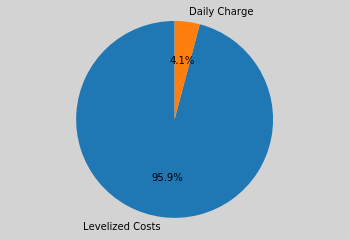

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[258.53648818447414, 210.0185209730313, 197.02625109201563, 55.89147512048572, 31.287813269458674, 16.757809852520758, 0.40111908445362465, 0.6465742976831224, 0.2313195779273507, 3228.44, 311.65160000000003, 0.0, 269.598, 42.0536, {'Levelized Costs': 3095.3868, 'Energy Charge': 0.011199999999746524, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600473044324, 45585.4, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (243.26008907759459, 122.31353426783059, 192.36502807475108, 26.775934364927462, 9.48000465431585, 41.67803810041813, 0.4854608547223059, 0.5370332693005392, 0.5956570829624049)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 243
                                           a tilt of 26.8
                                           and a gcr of 0.485


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.412862777709961 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 122
                                           a tilt of 9.5
                                           and a gcr of 0.537


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.37434983253479 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 41.7
                                           and a gcr of 0.596


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3669681549072266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 207 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.647]


ERROR:ga_logger:Cost: 3178.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,179 per year


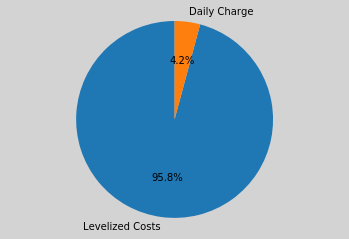

Total roof area of the  building: 599 m2
Total roof area used 515 m2
Percentage: 86.0%
succes
[[243.26008907759459, 122.31353426783059, 192.36502807475108, 26.775934364927462, 9.48000465431585, 41.67803810041813, 0.4854608547223059, 0.5370332693005392, 0.5956570829624049, 3178.73, 306.647, 0.0, 0.0, 306.647, {'Levelized Costs': 3045.672, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60415400182, 61845.7, 514.804]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.3616352640119, 111.79120847078849, 229.2896797958105, 42.435985454428355, 34.61927803347072, 24.657976274752762, 0.5991091663184519, 0.6561234014294268, 0.2190376185661323)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 42.4
                                           and a gcr of 0.599


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3321590423583984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 34.6
                                           and a gcr of 0.656


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3885416984558105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 229
                                           a tilt of 24.7
                                           and a gcr of 0.219


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4636261463165283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [318.62, 0.0, 14.662]


ERROR:ga_logger:Cost: 3443.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,443 per year


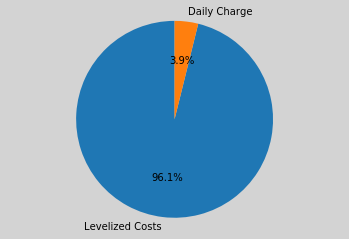

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[134.3616352640119, 111.79120847078849, 229.2896797958105, 42.435985454428355, 34.61927803347072, 24.657976274752762, 0.5991091663184519, 0.6561234014294268, 0.2190376185661323, 3443.28, 333.282, 318.62, 0.0, 14.662, {'Levelized Costs': 3310.237, 'Energy Charge': 0.0010000000002605702, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601878970054, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (143.84050105417714, 220.82156284467135, 207.2154316642801, 14.086747406581775, 39.86581564218096, 27.079792507006363, 0.3847876740791556, 0.7893452618519323, 0.3148463272852131)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 14.1
                                           and a gcr of 0.385


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.343857765197754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 221
                                           a tilt of 39.9
                                           and a gcr of 0.789


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3502144813537598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 207
                                           a tilt of 27.1
                                           and a gcr of 0.315


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.339921712875366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [134.965, 195.765, 0.0]


ERROR:ga_logger:Cost: 3417.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,418 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[143.84050105417714, 220.82156284467135, 207.2154316642801, 14.086747406581775, 39.86581564218096, 27.079792507006363, 0.3847876740791556, 0.7893452618519323, 0.3148463272852131, 3417.93, 330.73, 134.965, 195.765, 0.0, {'Levelized Costs': 3284.8799999999997, 'Energy Charge': 0.008000000000208729, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60121999949, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (234.97329010884866, 200.606887287562, 164.0281245456918, 8.777095363506248, 51.21223427487029, 29.996503867014773, 0.6150861184340641, 0.4453853154246042, 0.48666593296666893)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 8.8
                                           and a gcr of 0.615


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7166168689727783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 201
                                           a tilt of 51.2
                                           and a gcr of 0.445


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4683518409729004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 30.0
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4613733291625977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [47.9432, 0.0, 253.463]


ERROR:ga_logger:Cost: 3126.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,127 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[234.97329010884866, 200.606887287562, 164.0281245456918, 8.777095363506248, 51.21223427487029, 29.996503867014773, 0.6150861184340641, 0.4453853154246042, 0.48666593296666893, 3126.69, 301.4062, 47.9432, 0.0, 253.463, {'Levelized Costs': 2993.636, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60282340931, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (94.03692188498222, 106.47753736072607, 115.05629440680639, 40.38946367251568, 41.317381303736376, 20.70982664793242, 0.5887339058476093, 0.35103057791599157, 0.7852415699262172)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 40.4
                                           and a gcr of 0.589


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.621924877166748 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 106
                                           a tilt of 41.3
                                           and a gcr of 0.351


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.593024492263794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 20.7
                                           and a gcr of 0.785


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6639139652252197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  73 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 343.242]


ERROR:ga_logger:Cost: 3542.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,542 per year


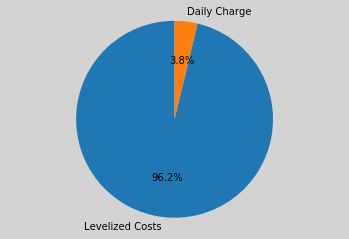

Total roof area of the  building: 599 m2
Total roof area used 437 m2
Percentage: 73.0%
succes
[[94.03692188498222, 106.47753736072607, 115.05629440680639, 40.38946367251568, 41.317381303736376, 20.70982664793242, 0.5887339058476093, 0.35103057791599157, 0.7852415699262172, 3542.21, 343.242, 0.0, 0.0, 343.242, {'Levelized Costs': 3409.1510000000003, 'Energy Charge': 0.016999999999939064, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602342699916, 61845.7, 437.117]]
The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.0628083935597, 177.54507139634188, 101.8051888366841, 41.87663463261196, 40.18523906604224, 15.484846697781741, 0.25724086756841774, 0.628106397503384, 0.34731641093961546)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 41.9
                                           and a gcr of 0.257


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.558147430419922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 40.2
                                           and a gcr of 0.628


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4233360290527344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 15.5
                                           and a gcr of 0.347


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4117021560668945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 305.685, 0.0]


ERROR:ga_logger:Cost: 3169.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,169 per year


Total roof area of the  building: 599 m2
Total roof area used 487 m2
Percentage: 81.3%
succes
[[139.0628083935597, 177.54507139634188, 101.8051888366841, 41.87663463261196, 40.18523906604224, 15.484846697781741, 0.25724086756841774, 0.628106397503384, 0.34731641093961546, 3169.18, 305.685, 0.0, 305.685, 0.0, {'Levelized Costs': 3036.127, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59905223992, 61845.7, 486.677]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (175.69353562153486, 125.29395923825827, 110.56326016862555, 54.494116261167555, 52.431627936861666, 49.80728032283553, 0.8506666904533318, 0.6193471437879154, 0.6662626414715757)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 54.5
                                           and a gcr of 0.851


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.760329484939575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 52.4
                                           and a gcr of 0.619


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.900566816329956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 111
                                           a tilt of 49.8
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4592039585113525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  28 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [343.458, 0.0, 0.0]


ERROR:ga_logger:Cost: 3544.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,544 per year


Total roof area of the  building: 599 m2
Total roof area used 404 m2
Percentage: 67.4%
succes
[[175.69353562153486, 125.29395923825827, 110.56326016862555, 54.494116261167555, 52.431627936861666, 49.80728032283553, 0.8506666904533318, 0.6193471437879154, 0.6662626414715757, 3544.35, 343.458, 343.458, 0.0, 0.0, {'Levelized Costs': 3411.298, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600641899866, 61845.7, 403.752]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (106.03560047928491, 156.18013734029688, 112.06450026419152, 51.76983919490358, 40.963801842852924, 49.99371067691057, 0.7059801694229824, 0.7301702067947393, 0.6510316045798699)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 51.8
                                           and a gcr of 0.706


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5399227142333984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 156
                                           a tilt of 41.0
                                           and a gcr of 0.730


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4331419467926025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 50.0
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4386003017425537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [0.0, 323.984, 0.0]


ERROR:ga_logger:Cost: 3350.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,351 per year


Total roof area of the  building: 599 m2
Total roof area used 444 m2
Percentage: 74.1%
succes
[[106.03560047928491, 156.18013734029688, 112.06450026419152, 51.76983919490358, 40.963801842852924, 49.99371067691057, 0.7059801694229824, 0.7301702067947393, 0.6510316045798699, 3350.93, 323.984, 0.0, 323.984, 0.0, {'Levelized Costs': 3217.8729999999996, 'Energy Charge': 0.015000000000156888, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60371796, 61845.7, 443.711]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (224.246853516744, 138.6774623053741, 261.87317249257677, 11.803431296611063, 36.73115586916144, 20.268034562497782, 0.8396131924474586, 0.4946722950153121, 0.40286146403604695)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 11.8
                                           and a gcr of 0.840


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6491012573242188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 139
                                           a tilt of 36.7
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3731396198272705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 20.3
                                           and a gcr of 0.403


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5848500728607178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [49.3841, 267.095, 0.0]


ERROR:ga_logger:Cost: 3276.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,276 per year


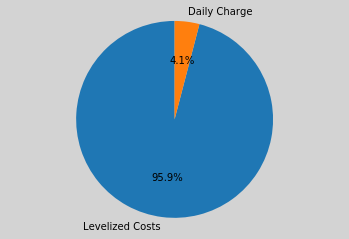

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[224.246853516744, 138.6774623053741, 261.87317249257677, 11.803431296611063, 36.73115586916144, 20.268034562497782, 0.8396131924474586, 0.4946722950153121, 0.40286146403604695, 3276.39, 316.4791, 49.3841, 267.095, 0.0, {'Levelized Costs': 3143.334, 'Energy Charge': 0.014000000000180535, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60246534701, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.49223629157385, 161.50379975881168, 161.73438576541838, 42.608562088940594, 7.911318280373745, 29.09209620457893, 0.6552277834269535, 0.6658143636003759, 0.5357632154062462)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 42.6
                                           and a gcr of 0.655


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.739729404449463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 162
                                           a tilt of 7.9
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4052510261535645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 29.1
                                           and a gcr of 0.536


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4132914543151855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.731]


ERROR:ga_logger:Cost: 3110.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,110 per year


Total roof area of the  building: 599 m2
Total roof area used 559 m2
Percentage: 93.4%
succes
[[152.49223629157385, 161.50379975881168, 161.73438576541838, 42.608562088940594, 7.911318280373745, 29.09209620457893, 0.6552277834269535, 0.6658143636003759, 0.5357632154062462, 3110.04, 299.731, 0.0, 0.0, 299.731, {'Levelized Costs': 2976.986, 'Energy Charge': 0.012000000000000455, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60165640008, 61845.7, 559.446]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (142.30495360627737, 260.18875304789606, 201.12421971903876, 20.314413613746712, 50.67102095355979, 1.3700450061078187, 0.5519894857446466, 0.7127308567674169, 0.3610769157537359)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 20.3
                                           and a gcr of 0.552


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.576018810272217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 50.7
                                           and a gcr of 0.713


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6765408515930176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 201
                                           a tilt of 1.4
                                           and a gcr of 0.361


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3167333602905273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [309.006, 0.0, 0.0]


ERROR:ga_logger:Cost: 3202.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,202 per year


Total roof area of the  building: 599 m2
Total roof area used 560 m2
Percentage: 93.5%
succes
[[142.30495360627737, 260.18875304789606, 201.12421971903876, 20.314413613746712, 50.67102095355979, 1.3700450061078187, 0.5519894857446466, 0.7127308567674169, 0.3610769157537359, 3202.16, 309.006, 309.006, 0.0, 0.0, {'Levelized Costs': 3069.1119999999996, 'Energy Charge': 0.0060000000000854925, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60040697004, 61845.7, 559.804]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (128.867067756484, 142.4947093958282, 171.8252237884858, 23.641580808841365, 53.74621601994525, 19.380288106132177, 0.8198030192567762, 0.3473290515265259, 0.7996191403847197)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 23.6
                                           and a gcr of 0.820


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.531923770904541 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 142
                                           a tilt of 53.7
                                           and a gcr of 0.347


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.437908411026001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 19.4
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5513062477111816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.733]


ERROR:ga_logger:Cost: 3229.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,229 per year


Total roof area of the  building: 599 m2
Total roof area used 390 m2
Percentage: 65.1%
succes
[[128.867067756484, 142.4947093958282, 171.8252237884858, 23.641580808841365, 53.74621601994525, 19.380288106132177, 0.8198030192567762, 0.3473290515265259, 0.7996191403847197, 3229.25, 311.733, 0.0, 0.0, 311.733, {'Levelized Costs': 3096.2019999999998, 'Energy Charge': 0.006000000000312866, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60084279235, 61845.7, 389.851]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.30924876603692, 149.77815084348708, 202.73314747806404, 45.53915740814899, 54.35893280900553, 2.38756863725148, 0.8649201554799009, 0.6832611839910363, 0.7469352611259228)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 45.5
                                           and a gcr of 0.865


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5967540740966797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 54.4
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5192530155181885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 2.4
                                           and a gcr of 0.747


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.338818073272705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 330.163]


ERROR:ga_logger:Cost: 3412.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,412 per year


Total roof area of the  building: 599 m2
Total roof area used 442 m2
Percentage: 73.8%
succes
[[241.30924876603692, 149.77815084348708, 202.73314747806404, 45.53915740814899, 54.35893280900553, 2.38756863725148, 0.8649201554799009, 0.6832611839910363, 0.7469352611259228, 3412.3, 330.163, 0.0, 0.0, 330.163, {'Levelized Costs': 3279.251, 'Energy Charge': 0.007000000000061846, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60026130751, 61845.7, 442.023]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205.03430147908915, 90.9822738384548, 143.60978666371153, 5.13079743448993, 14.155095112405167, 25.34565286862703, 0.8942875080136417, 0.7558165065078888, 0.4720121170584889)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 5.1
                                           and a gcr of 0.894


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.600811243057251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 14.2
                                           and a gcr of 0.756


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4364492893218994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 25.3
                                           and a gcr of 0.472


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4701151847839355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [55.3793, 0.0, 253.393]


ERROR:ga_logger:Cost: 3199.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,200 per year


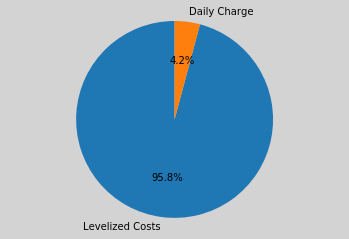

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[205.03430147908915, 90.9822738384548, 143.60978666371153, 5.13079743448993, 14.155095112405167, 25.34565286862703, 0.8942875080136417, 0.7558165065078888, 0.4720121170584889, 3199.85, 308.7723, 55.3793, 0.0, 253.393, {'Levelized Costs': 3066.7980000000002, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60257123332, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (124.40205971797232, 262.5706342877063, 194.12094258033187, 42.30721048114059, 26.294066172187815, 13.387995574963504, 0.4824760747976123, 0.24097086589196168, 0.4757698494821474)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 42.3
                                           and a gcr of 0.482


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.640964984893799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 26.3
                                           and a gcr of 0.241


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.768390417098999 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 13.4
                                           and a gcr of 0.476


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4673895835876465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 284.873]


ERROR:ga_logger:Cost: 3538.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0093 /kWh
Total Cost of the system: $ 3,538 per year


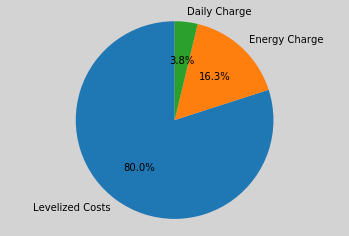

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.40205971797232, 262.5706342877063, 194.12094258033187, 42.30721048114059, 26.294066172187815, 13.387995574963504, 0.4824760747976123, 0.24097086589196168, 0.4757698494821474, 3538.47, 284.873, 0.0, 0.0, 284.873, {'Levelized Costs': 2829.4219999999996, 'Energy Charge': 576.0060000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57248.66866605086, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90.32188060489317, 124.63493001118536, 211.44928798713158, 3.435229624957105, 46.59724005928214, 17.326599475798844, 0.8102442703924808, 0.2644892529807688, 0.42392581047199174)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 3.4
                                           and a gcr of 0.810


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4212193489074707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 46.6
                                           and a gcr of 0.264


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.475106716156006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 17.3
                                           and a gcr of 0.424


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4739766120910645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [137.581, 0.0, 181.847]


ERROR:ga_logger:Cost: 3305.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,306 per year


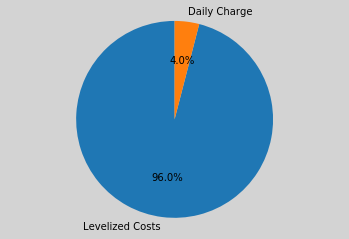

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[90.32188060489317, 124.63493001118536, 211.44928798713158, 3.435229624957105, 46.59724005928214, 17.326599475798844, 0.8102442703924808, 0.2644892529807688, 0.42392581047199174, 3305.68, 319.428, 137.581, 0.0, 181.847, {'Levelized Costs': 3172.6209999999996, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6028993608, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (213.49447408278502, 158.14412633335326, 134.2384534059405, 43.76410692019833, 44.56589402349717, 26.51931025740993, 0.6454121597355509, 0.6766887950283103, 0.7015266699767981)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 213
                                           a tilt of 43.8
                                           and a gcr of 0.645


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.368359088897705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 158
                                           a tilt of 44.6
                                           and a gcr of 0.677


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5385513305664062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 134
                                           a tilt of 26.5
                                           and a gcr of 0.702


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3973145484924316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  48 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 322.248, 0.0]


ERROR:ga_logger:Cost: 3333.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,334 per year


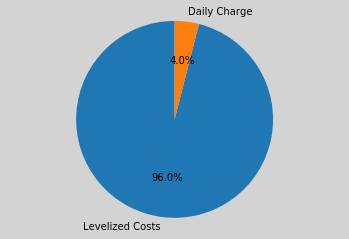

Total roof area of the  building: 599 m2
Total roof area used 476 m2
Percentage: 79.5%
succes
[[213.49447408278502, 158.14412633335326, 134.2384534059405, 43.76410692019833, 44.56589402349717, 26.51931025740993, 0.6454121597355509, 0.6766887950283103, 0.7015266699767981, 3333.69, 322.248, 0.0, 322.248, 0.0, {'Levelized Costs': 3200.6349999999998, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60141090003, 61845.7, 476.213]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (174.90460284838593, 261.138231356045, 248.35253713498946, 9.778870997543205, 15.75861675172773, 13.454803811561582, 0.48657281011463843, 0.6484307375800414, 0.7779219140498546)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 9.8
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.510261058807373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 261
                                           a tilt of 15.8
                                           and a gcr of 0.648


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.441121816635132 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 13.5
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7585291862487793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [247.273, 0.0, 70.4552]


ERROR:ga_logger:Cost: 3288.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,289 per year


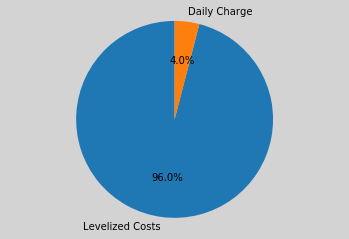

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[174.90460284838593, 261.138231356045, 248.35253713498946, 9.778870997543205, 15.75861675172773, 13.454803811561582, 0.48657281011463843, 0.6484307375800414, 0.7779219140498546, 3288.8, 317.7282, 247.273, 0.0, 70.4552, {'Levelized Costs': 3155.741, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60073058204, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (142.50580618039868, 141.01266739631808, 228.60290516337753, 49.8137417351528, 32.15822773681428, 40.229315442210634, 0.3912591635652252, 0.868017695974761, 0.8542695620851428)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 49.8
                                           and a gcr of 0.391


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.490825891494751 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 141
                                           a tilt of 32.2
                                           and a gcr of 0.868


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5949838161468506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 229
                                           a tilt of 40.2
                                           and a gcr of 0.854


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.51883602142334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 108 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 213 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [154.4, 177.196, 0.0]


ERROR:ga_logger:Cost: 3426.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,427 per year


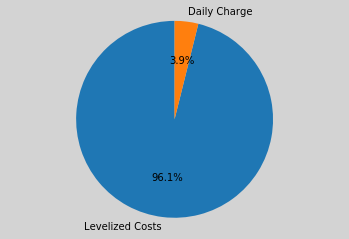

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[142.50580618039868, 141.01266739631808, 228.60290516337753, 49.8137417351528, 32.15822773681428, 40.229315442210634, 0.3912591635652252, 0.868017695974761, 0.8542695620851428, 3426.53, 331.596, 154.4, 177.196, 0.0, {'Levelized Costs': 3293.4790000000003, 'Energy Charge': 0.009000000000185082, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60068619018, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (198.1046937532648, 90.53989317947726, 250.84236934125667, 24.807905340356346, 31.461168309406727, 49.834298317146235, 0.28642540877495637, 0.8148587409940793, 0.5009305648228539)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 24.8
                                           and a gcr of 0.286


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4569427967071533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 31.5
                                           and a gcr of 0.815


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.383772134780884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 251
                                           a tilt of 49.8
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3903565406799316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 197 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [52.259, 339.233, 0.0]


ERROR:ga_logger:Cost: 4021.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,021 per year


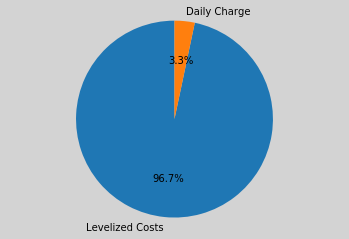

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[198.1046937532648, 90.53989317947726, 250.84236934125667, 24.807905340356346, 31.461168309406727, 49.834298317146235, 0.28642540877495637, 0.8148587409940793, 0.5009305648228539, 4021.44, 391.492, 52.259, 339.233, 0.0, {'Levelized Costs': 3888.379, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60283480005, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (228.4947205153843, 169.89365887423708, 239.19745484269, 30.789264860425572, 19.03361320167664, 2.2367204287916715, 0.8825650748945844, 0.6791396603084301, 0.2369179229836966)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 30.8
                                           and a gcr of 0.883


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.400085687637329 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 19.0
                                           and a gcr of 0.679


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8265397548675537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 239
                                           a tilt of 2.2
                                           and a gcr of 0.237


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2280352115631104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 196 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 305.552, 0.0]


ERROR:ga_logger:Cost: 3167.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,168 per year


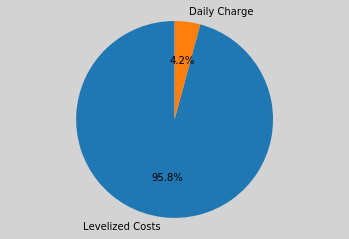

Total roof area of the  building: 599 m2
Total roof area used 450 m2
Percentage: 75.1%
succes
[[228.4947205153843, 169.89365887423708, 239.19745484269, 30.789264860425572, 19.03361320167664, 2.2367204287916715, 0.8825650748945844, 0.6791396603084301, 0.2369179229836966, 3167.86, 305.552, 0.0, 305.552, 0.0, {'Levelized Costs': 3034.801, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601821599455, 61845.7, 449.91]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (151.8076302441382, 191.2301232423738, 260.67620088883035, 42.278671349651084, 55.24574286975218, 34.497781225824234, 0.22805394711640256, 0.7970128056459749, 0.29493744556558)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 42.3
                                           and a gcr of 0.228


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5571393966674805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 55.2
                                           and a gcr of 0.797


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6131458282470703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 34.5
                                           and a gcr of 0.295


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3614728450775146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [57.648, 275.75, 0.0]


ERROR:ga_logger:Cost: 3444.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,444 per year


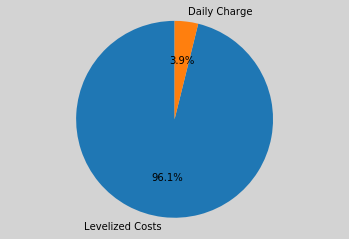

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[151.8076302441382, 191.2301232423738, 260.67620088883035, 42.278671349651084, 55.24574286975218, 34.497781225824234, 0.22805394711640256, 0.7970128056459749, 0.29493744556558, 3444.43, 333.398, 57.648, 275.75, 0.0, {'Levelized Costs': 3311.3689999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60077525802, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.42992527563928, 106.60099917255312, 153.51777267129387, 45.70421884596778, 4.424249300582657, 47.23040435770088, 0.26310071413596553, 0.5211512732901349, 0.7259336718333635)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 45.7
                                           and a gcr of 0.263


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8626022338867188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 107
                                           a tilt of 4.4
                                           and a gcr of 0.521


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.67917537689209 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 47.2
                                           and a gcr of 0.726


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.713069200515747 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [59.3579, 0.0, 270.884]


ERROR:ga_logger:Cost: 3413.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,413 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[139.42992527563928, 106.60099917255312, 153.51777267129387, 45.70421884596778, 4.424249300582657, 47.23040435770088, 0.26310071413596553, 0.5211512732901349, 0.7259336718333635, 3413.09, 330.2419, 59.3579, 0.0, 270.884, {'Levelized Costs': 3280.0310000000004, 'Energy Charge': 0.016999999999939064, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60123046007, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (98.10712389013857, 183.14548518651605, 241.81494938733033, 46.309215739649495, 23.58641477455281, 24.88806306756672, 0.4919215752456001, 0.5794575839386653, 0.5347108695403193)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 98
                                           a tilt of 46.3
                                           and a gcr of 0.492


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.456176996231079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 23.6
                                           and a gcr of 0.579


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4309961795806885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 242
                                           a tilt of 24.9
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4340689182281494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 298.237, 0.0]


ERROR:ga_logger:Cost: 3095.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,095 per year


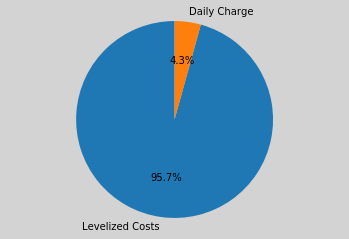

Total roof area of the  building: 599 m2
Total roof area used 515 m2
Percentage: 86.0%
succes
[[98.10712389013857, 183.14548518651605, 241.81494938733033, 46.309215739649495, 23.58641477455281, 24.88806306756672, 0.4919215752456001, 0.5794575839386653, 0.5347108695403193, 3095.21, 298.237, 0.0, 298.237, 0.0, {'Levelized Costs': 2962.154, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6016372551, 61845.7, 514.683]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.24570774206813, 224.61536923229644, 202.9768607177325, 47.249681375698, 13.69533233395916, 17.91099053782139, 0.46577292307170187, 0.5499783016949016, 0.32197315923751024)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 47.2
                                           and a gcr of 0.466


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4677696228027344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 13.7
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6910853385925293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 17.9
                                           and a gcr of 0.322


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9624907970428467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  79 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 299.547, 17.4218]


ERROR:ga_logger:Cost: 3281.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,281 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[130.24570774206813, 224.61536923229644, 202.9768607177325, 47.249681375698, 13.69533233395916, 17.91099053782139, 0.46577292307170187, 0.5499783016949016, 0.32197315923751024, 3281.25, 316.96880000000004, 0.0, 299.547, 17.4218, {'Levelized Costs': 3148.207, 'Energy Charge': 0.00100000000009004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60210440981, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (218.22183602443044, 237.28095921701183, 208.83962131425574, 36.87543053397444, 12.934698566967505, 22.392636298932327, 0.6024421980811137, 0.6087383845151946, 0.7431228863875023)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 218
                                           a tilt of 36.9
                                           and a gcr of 0.602


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8239264488220215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 12.9
                                           and a gcr of 0.609


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.351684808731079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 209
                                           a tilt of 22.4
                                           and a gcr of 0.743


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8452255725860596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.269]


ERROR:ga_logger:Cost: 3264.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,264 per year


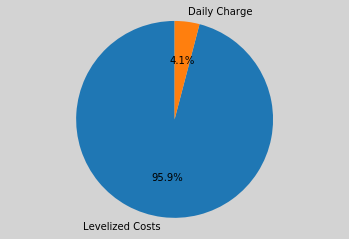

Total roof area of the  building: 599 m2
Total roof area used 424 m2
Percentage: 70.9%
succes
[[218.22183602443044, 237.28095921701183, 208.83962131425574, 36.87543053397444, 12.934698566967505, 22.392636298932327, 0.6024421980811137, 0.6087383845151946, 0.7431228863875023, 3264.37, 315.269, 0.0, 0.0, 315.269, {'Levelized Costs': 3131.323, 'Energy Charge': 0.005000000000109139, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60153148496, 61845.7, 424.248]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.1801934275889, 126.04411668090361, 132.2407605428317, 55.61606632639229, 55.80219693749856, 45.47690361646929, 0.5428989355820234, 0.6754875960284793, 0.5613444495106017)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 55.6
                                           and a gcr of 0.543


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.685067892074585 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 126
                                           a tilt of 55.8
                                           and a gcr of 0.675


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.565631866455078 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 45.5
                                           and a gcr of 0.561


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4331228733062744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 182 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.112]


ERROR:ga_logger:Cost: 3518.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0008 /kWh
Total Cost of the system: $ 3,519 per year


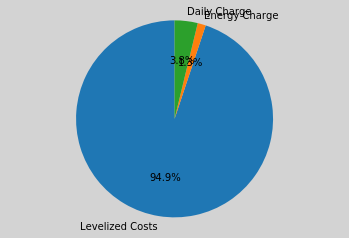

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[120.1801934275889, 126.04411668090361, 132.2407605428317, 55.61606632639229, 55.80219693749856, 45.47690361646929, 0.5428989355820234, 0.6754875960284793, 0.5613444495106017, 3518.59, 336.112, 0.0, 0.0, 336.112, {'Levelized Costs': 3338.331, 'Energy Charge': 47.2170000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61468.86531776001, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (181.3714780282627, 93.85256538893088, 261.2478524680463, 54.13861497014044, 22.2410474923767, 55.74780972526679, 0.49691315177073364, 0.24489869677119433, 0.6842323310131346)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 54.1
                                           and a gcr of 0.497


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5694684982299805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 94
                                           a tilt of 22.2
                                           and a gcr of 0.245


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4203033447265625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 55.7
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4986844062805176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 214 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [297.533, 0.0, 0.0]


ERROR:ga_logger:Cost: 3474.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0062 /kWh
Total Cost of the system: $ 3,475 per year


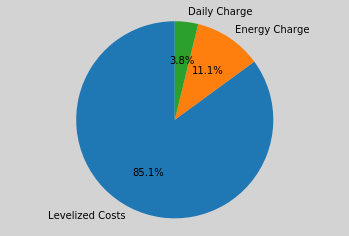

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[181.3714780282627, 93.85256538893088, 261.2478524680463, 54.13861497014044, 22.2410474923767, 55.74780972526679, 0.49691315177073364, 0.24489869677119433, 0.6842323310131346, 3474.52, 297.533, 297.533, 0.0, 0.0, {'Levelized Costs': 2955.153, 'Energy Charge': 386.3250000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58762.516193626136, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235.27289098872308, 178.86627503713217, 116.64222169006035, 18.22491447328427, 33.04224427572925, 18.79429652409295, 0.24717207400056018, 0.4921236423074262, 0.5752933947568879)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 18.2
                                           and a gcr of 0.247


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.098448991775513 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 33.0
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.365044355392456 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 117
                                           a tilt of 18.8
                                           and a gcr of 0.575


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.366471529006958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 190 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 294.665, 0.0]


ERROR:ga_logger:Cost: 3079.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0003 /kWh
Total Cost of the system: $ 3,079 per year


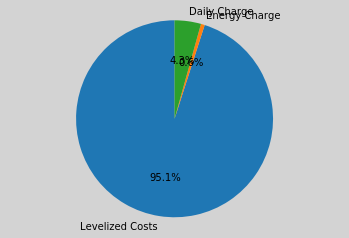

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[235.27289098872308, 178.86627503713217, 116.64222169006035, 18.22491447328427, 33.04224427572925, 18.79429652409295, 0.24717207400056018, 0.4921236423074262, 0.5752933947568879, 3079.02, 294.665, 0.0, 294.665, 0.0, {'Levelized Costs': 2926.672, 'Energy Charge': 19.305999999999926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61691.65767380005, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (161.73784028152704, 111.44057205853694, 180.6064509753783, 15.30414145248314, 33.789447954218055, 16.893590747393162, 0.6398766840815417, 0.43347444175827565, 0.2696860788128782)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 15.3
                                           and a gcr of 0.640


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5115978717803955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 111
                                           a tilt of 33.8
                                           and a gcr of 0.433


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3908164501190186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 16.9
                                           and a gcr of 0.270


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.426431655883789 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 135s


ERROR:ga_logger:panel relevance: [250.865, 0.0, 55.7469]


ERROR:ga_logger:Cost: 3178.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,178 per year


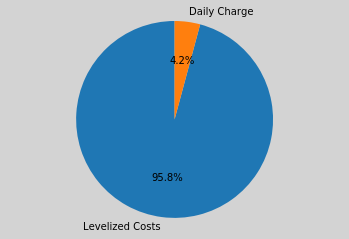

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[161.73784028152704, 111.44057205853694, 180.6064509753783, 15.30414145248314, 33.789447954218055, 16.893590747393162, 0.6398766840815417, 0.43347444175827565, 0.2696860788128782, 3178.38, 306.6119, 250.865, 0.0, 55.7469, {'Levelized Costs': 3045.3179999999998, 'Energy Charge': 0.02000000000032287, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59987882199, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (244.0240960169992, 236.62089850385365, 223.27726991571657, 13.385546253881314, 43.80895320979022, 13.112734432919222, 0.37369244424851344, 0.5448974438535815, 0.3992547220608091)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 244
                                           a tilt of 13.4
                                           and a gcr of 0.374


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.904432773590088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 43.8
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.424722671508789 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 223
                                           a tilt of 13.1
                                           and a gcr of 0.399


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4307777881622314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 326.264, 0.0]


ERROR:ga_logger:Cost: 3878.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 49,364 kWh
At a cost of $ 0.0102 /kWh
Total Cost of the system: $ 3,879 per year


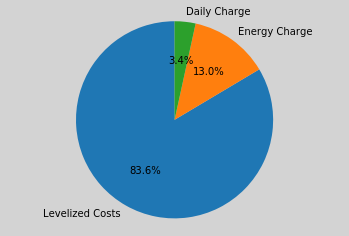

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[244.0240960169992, 236.62089850385365, 223.27726991571657, 13.385546253881314, 43.80895320979022, 13.112734432919222, 0.37369244424851344, 0.5448974438535815, 0.3992547220608091, 3878.52, 326.264, 0.0, 326.264, 0.0, {'Levelized Costs': 3240.5181, 'Energy Charge': 504.95990000000023, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57815.691656446535, 49364.0, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.7189852910691, 247.02884714808314, 200.13146054721082, 15.462706445355114, 14.961828035411745, 24.010639893512742, 0.5865968048508532, 0.2832234896566411, 0.7709565024804588)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 187
                                           a tilt of 15.5
                                           and a gcr of 0.587


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9958014488220215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 247
                                           a tilt of 15.0
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4232676029205322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 24.0
                                           and a gcr of 0.771


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9872608184814453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 223 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [305.003, 0.0, 0.0]


ERROR:ga_logger:Cost: 3162.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,162 per year


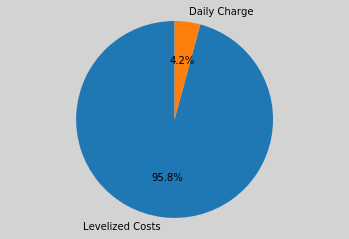

Total roof area of the  building: 599 m2
Total roof area used 520 m2
Percentage: 86.8%
succes
[[186.7189852910691, 247.02884714808314, 200.13146054721082, 15.462706445355114, 14.961828035411745, 24.010639893512742, 0.5865968048508532, 0.2832234896566411, 0.7709565024804588, 3162.41, 305.003, 305.003, 0.0, 0.0, {'Levelized Costs': 3029.347, 'Energy Charge': 0.020999999999673946, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5984158918, 61845.7, 519.954]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (112.3505328842872, 126.61007560355611, 184.2688062897874, 41.31789639151515, 36.696834517619514, 50.977845851948395, 0.3227724368849421, 0.3887939064501627, 0.25949381642529457)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 112
                                           a tilt of 41.3
                                           and a gcr of 0.323


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.400507688522339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 127
                                           a tilt of 36.7
                                           and a gcr of 0.389


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.363799810409546 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 51.0
                                           and a gcr of 0.259


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4434285163879395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 229 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 232.795, 0.0]


ERROR:ga_logger:Cost: 4546.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0340 /kWh
Total Cost of the system: $ 4,547 per year


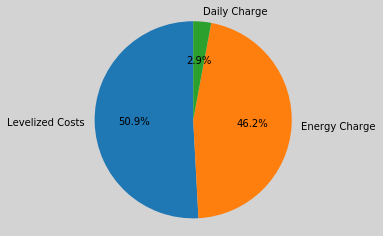

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[112.3505328842872, 126.61007560355611, 184.2688062897874, 41.31789639151515, 36.696834517619514, 50.977845851948395, 0.3227724368849421, 0.3887939064501627, 0.25949381642529457, 4546.72, 232.795, 0.0, 232.795, 0.0, {'Levelized Costs': 2312.1670000000004, 'Energy Charge': 2101.511, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 45073.87881661003, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (212.29114643521652, 122.86614258843034, 137.6608834347254, 37.90838823393846, 40.3974476558239, 38.43631108702008, 0.27616880668971255, 0.559632364245366, 0.7640162096589116)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 37.9
                                           and a gcr of 0.276


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.753340721130371 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 123
                                           a tilt of 40.4
                                           and a gcr of 0.560


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.742483615875244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 38.4
                                           and a gcr of 0.764


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.902534246444702 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [70.3668, 0.0, 262.795]


ERROR:ga_logger:Cost: 3442.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,442 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[212.29114643521652, 122.86614258843034, 137.6608834347254, 37.90838823393846, 40.3974476558239, 38.43631108702008, 0.27616880668971255, 0.559632364245366, 0.7640162096589116, 3442.09, 333.1618, 70.3668, 0.0, 262.795, {'Levelized Costs': 3309.03, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60307773149, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.67136654484368, 248.2187920670661, 134.67514861884507, 12.744394739149012, 31.40287864425904, 28.496786008767042, 0.5588976638571634, 0.5594471412454696, 0.6378087747673935)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 12.7
                                           and a gcr of 0.559


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.661595582962036 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 248
                                           a tilt of 31.4
                                           and a gcr of 0.559


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.429011821746826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 28.5
                                           and a gcr of 0.638


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4166598320007324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.855]


ERROR:ga_logger:Cost: 3319.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,320 per year


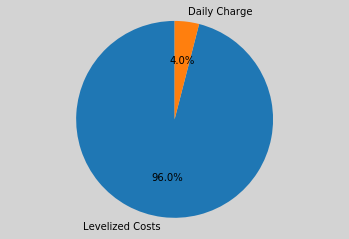

Total roof area of the  building: 599 m2
Total roof area used 503 m2
Percentage: 84.0%
succes
[[108.67136654484368, 248.2187920670661, 134.67514861884507, 12.744394739149012, 31.40287864425904, 28.496786008767042, 0.5588976638571634, 0.5594471412454696, 0.6378087747673935, 3319.86, 320.855, 0.0, 0.0, 320.855, {'Levelized Costs': 3186.805, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603034379084, 61845.7, 503.059]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (189.20472577893617, 171.1248442639798, 171.56590587096775, 51.878852579531944, 27.23871374492796, 13.506262734304109, 0.7749864535992896, 0.47177938269144964, 0.7328114893835609)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 51.9
                                           and a gcr of 0.775


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5153205394744873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 27.2
                                           and a gcr of 0.472


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4426960945129395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 13.5
                                           and a gcr of 0.733


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4492719173431396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 229 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 255.193, 42.3905]


ERROR:ga_logger:Cost: 3088.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,089 per year


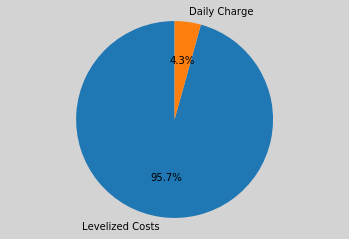

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[189.20472577893617, 171.1248442639798, 171.56590587096775, 51.878852579531944, 27.23871374492796, 13.506262734304109, 0.7749864535992896, 0.47177938269144964, 0.7328114893835609, 3088.71, 297.5835, 0.0, 255.193, 42.3905, {'Levelized Costs': 2955.659, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59856768297, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220.2892630271992, 234.09645486437822, 191.61978785725378, 4.9849773296097535, 2.9802094484384405, 42.87545728465043, 0.8242405316954411, 0.3482632837205166, 0.7424712245839464)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 5.0
                                           and a gcr of 0.824


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6522364616394043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 234
                                           a tilt of 3.0
                                           and a gcr of 0.348


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4393322467803955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 42.9
                                           and a gcr of 0.742


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.644488573074341 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.113]


ERROR:ga_logger:Cost: 3292.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,293 per year


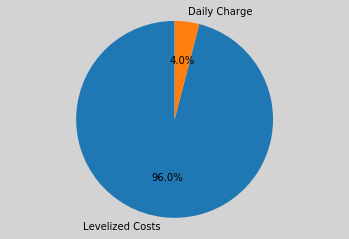

Total roof area of the  building: 599 m2
Total roof area used 428 m2
Percentage: 71.6%
succes
[[220.2892630271992, 234.09645486437822, 191.61978785725378, 4.9849773296097535, 2.9802094484384405, 42.87545728465043, 0.8242405316954411, 0.3482632837205166, 0.7424712245839464, 3292.62, 318.113, 0.0, 0.0, 318.113, {'Levelized Costs': 3159.564, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602676993905, 61845.7, 428.452]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (109.79385215454414, 179.29884066292936, 124.50352906236559, 7.10640057391968, 43.631252724319495, 6.829310494265761, 0.24674502466677137, 0.7253524938605893, 0.7486838849603785)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 7.1
                                           and a gcr of 0.247


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.577409267425537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 43.6
                                           and a gcr of 0.725


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.63984751701355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 6.8
                                           and a gcr of 0.749


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.61106014251709 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 134s


ERROR:ga_logger:panel relevance: [0.0, 315.081, 0.0]


ERROR:ga_logger:Cost: 3262.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,263 per year


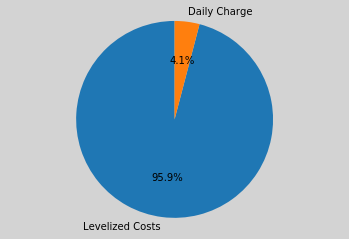

Total roof area of the  building: 599 m2
Total roof area used 434 m2
Percentage: 72.5%
succes
[[109.79385215454414, 179.29884066292936, 124.50352906236559, 7.10640057391968, 43.631252724319495, 6.829310494265761, 0.24674502466677137, 0.7253524938605893, 0.7486838849603785, 3262.51, 315.081, 0.0, 315.081, 0.0, {'Levelized Costs': 3129.454, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59943089992, 61845.7, 434.384]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (166.4798596997078, 141.39834132935945, 164.40321099209314, 48.04548304172705, 55.37862091645279, 53.22008090020581, 0.8789536838682626, 0.63253074592452, 0.6961310712546305)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 48.0
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7864997386932373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 141
                                           a tilt of 55.4
                                           and a gcr of 0.633


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4547061920166016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 53.2
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4330153465270996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 192 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 333.597]


ERROR:ga_logger:Cost: 3446.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,446 per year


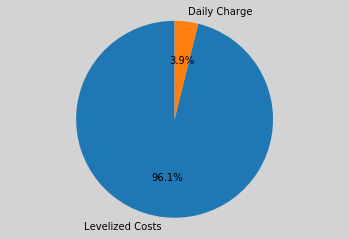

Total roof area of the  building: 599 m2
Total roof area used 479 m2
Percentage: 80.0%
succes
[[166.4798596997078, 141.39834132935945, 164.40321099209314, 48.04548304172705, 55.37862091645279, 53.22008090020581, 0.8789536838682626, 0.63253074592452, 0.6961310712546305, 3446.41, 333.597, 0.0, 0.0, 333.597, {'Levelized Costs': 3313.356, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60210049977, 61845.7, 479.216]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230.96122947155627, 90.12936510207099, 195.3014116629305, 33.33640758709438, 3.641652438205342, 10.327999609336777, 0.5515461409538409, 0.4787292816556448, 0.6573066914738774)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 231
                                           a tilt of 33.3
                                           and a gcr of 0.552


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.650564432144165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 3.6
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5634350776672363 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 10.3
                                           and a gcr of 0.657


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.7777698040008545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.83]


ERROR:ga_logger:Cost: 3250.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,250 per year


Total roof area of the  building: 599 m2
Total roof area used 477 m2
Percentage: 79.7%
succes
[[230.96122947155627, 90.12936510207099, 195.3014116629305, 33.33640758709438, 3.641652438205342, 10.327999609336777, 0.5515461409538409, 0.4787292816556448, 0.6573066914738774, 3250.08, 313.83, 0.0, 0.0, 313.83, {'Levelized Costs': 3117.0310000000004, 'Energy Charge': 0.006999999999834472, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60145615878, 61845.7, 477.449]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (125.0432229335766, 170.54750509466814, 188.50210178289927, 43.90647661037387, 34.04229890928868, 44.95914124998991, 0.6107579764329765, 0.5806191461730889, 0.7608196062507218)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 43.9
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5744662284851074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 34.0
                                           and a gcr of 0.581


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.517253875732422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 45.0
                                           and a gcr of 0.761


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5853631496429443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 203 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 300.535, 0.0]


ERROR:ga_logger:Cost: 3118.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,118 per year


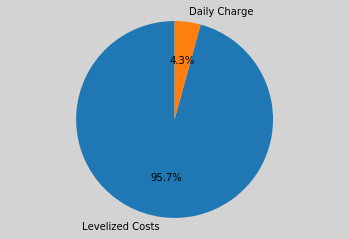

Total roof area of the  building: 599 m2
Total roof area used 518 m2
Percentage: 86.4%
succes
[[125.0432229335766, 170.54750509466814, 188.50210178289927, 43.90647661037387, 34.04229890928868, 44.95914124998991, 0.6107579764329765, 0.5806191461730889, 0.7608196062507218, 3118.03, 300.535, 0.0, 300.535, 0.0, {'Levelized Costs': 2984.974, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60170571, 61845.7, 517.612]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (249.43922093388719, 234.16049906048482, 230.72194887652324, 11.878788365211689, 43.1091795529, 7.5264445975996965, 0.4366764092389398, 0.5016602086444804, 0.6263118969628311)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 249
                                           a tilt of 11.9
                                           and a gcr of 0.437


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.897754430770874 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 234
                                           a tilt of 43.1
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5780389308929443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 7.5
                                           and a gcr of 0.626


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8090717792510986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 228 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 127s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.819]


ERROR:ga_logger:Cost: 3369.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,369 per year


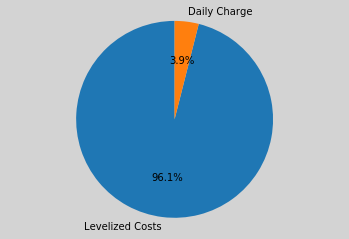

Total roof area of the  building: 599 m2
Total roof area used 520 m2
Percentage: 86.9%
succes
[[249.43922093388719, 234.16049906048482, 230.72194887652324, 11.878788365211689, 43.1091795529, 7.5264445975996965, 0.4366764092389398, 0.5016602086444804, 0.6263118969628311, 3369.16, 325.819, 0.0, 0.0, 325.819, {'Levelized Costs': 3236.0939999999996, 'Energy Charge': 0.024000000000114596, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60157457148, 61845.7, 520.219]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (218.27786693310296, 219.12100188569337, 259.4677044290194, 32.589459655141404, 54.18482773521762, 29.429094716309322, 0.7581939833909503, 0.6705907434052607, 0.2356572784947002)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 218
                                           a tilt of 32.6
                                           and a gcr of 0.758


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6923742294311523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 54.2
                                           and a gcr of 0.671


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7422659397125244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 29.4
                                           and a gcr of 0.236


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.774481773376465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 179 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [330.769, 0.0, 0.0]


ERROR:ga_logger:Cost: 3418.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,418 per year


Total roof area of the  building: 599 m2
Total roof area used 436 m2
Percentage: 72.9%
succes
[[218.27786693310296, 219.12100188569337, 259.4677044290194, 32.589459655141404, 54.18482773521762, 29.429094716309322, 0.7581939833909503, 0.6705907434052607, 0.2356572784947002, 3418.32, 330.769, 330.769, 0.0, 0.0, {'Levelized Costs': 3285.256, 'Energy Charge': 0.022000000000218733, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59804257822, 61845.7, 436.259]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (234.52217848436197, 124.44280541626512, 245.06086365165788, 12.314956404312397, 37.59719428361975, 17.82973807310009, 0.7506783026019321, 0.46550074575341754, 0.20675457417943202)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 12.3
                                           and a gcr of 0.751


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.580787420272827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 124
                                           a tilt of 37.6
                                           and a gcr of 0.466


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8696212768554688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 17.8
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.808607816696167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 128s


ERROR:ga_logger:panel relevance: [281.042, 0.0, 46.3912]


ERROR:ga_logger:Cost: 3385.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,385 per year


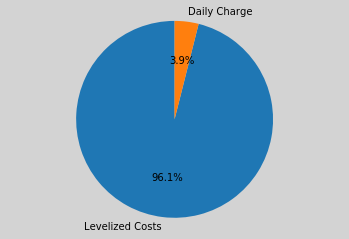

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[234.52217848436197, 124.44280541626512, 245.06086365165788, 12.314956404312397, 37.59719428361975, 17.82973807310009, 0.7506783026019321, 0.46550074575341754, 0.20675457417943202, 3385.19, 327.43319999999994, 281.042, 0.0, 46.3912, {'Levelized Costs': 3252.1299999999997, 'Energy Charge': 0.018000000000370164, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604352429116, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (228.60947847299244, 192.4655833122157, 94.01685516973608, 45.89169226382608, 53.330780075709924, 16.383391407164133, 0.46917844372719447, 0.8543663233633725, 0.6152751565731902)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 229
                                           a tilt of 45.9
                                           and a gcr of 0.469


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.421243667602539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 53.3
                                           and a gcr of 0.854


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3930773735046387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 16.4
                                           and a gcr of 0.615


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3980844020843506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [210.802, 127.695, 0.0]


ERROR:ga_logger:Cost: 3495.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,495 per year


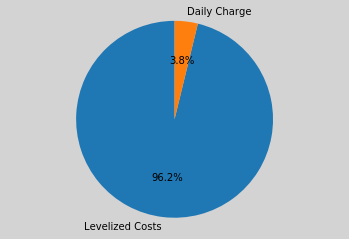

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[228.60947847299244, 192.4655833122157, 94.01685516973608, 45.89169226382608, 53.330780075709924, 16.383391407164133, 0.46917844372719447, 0.8543663233633725, 0.6152751565731902, 3495.08, 338.49699999999996, 210.802, 127.695, 0.0, {'Levelized Costs': 3362.019, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60096496912, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (251.83813929305865, 215.79660928150793, 157.3057648893842, 15.847263188813919, 39.33649428478496, 46.315903506617815, 0.3932696470296648, 0.609278680147198, 0.8810733992262032)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 15.8
                                           and a gcr of 0.393


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.770435333251953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 39.3
                                           and a gcr of 0.609


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.698137044906616 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 46.3
                                           and a gcr of 0.881


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6720664501190186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 322.081, 0.0]


ERROR:ga_logger:Cost: 3332.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,332 per year


Total roof area of the  building: 599 m2
Total roof area used 529 m2
Percentage: 88.3%
succes
[[251.83813929305865, 215.79660928150793, 157.3057648893842, 15.847263188813919, 39.33649428478496, 46.315903506617815, 0.3932696470296648, 0.609278680147198, 0.8810733992262032, 3332.03, 322.081, 0.0, 322.081, 0.0, {'Levelized Costs': 3198.972, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60057703055, 61845.7, 528.627]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (263.75067232957076, 162.68958489229257, 95.4927048285799, 2.4580997812754286, 8.20283976405112, 13.529874171965908, 0.5890765932047812, 0.759507180903481, 0.28834195282327213)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 2.5
                                           and a gcr of 0.589


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.549896240234375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 8.2
                                           and a gcr of 0.760


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6475274562835693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 13.5
                                           and a gcr of 0.288


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7059109210968018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 318.427, 0.0]


ERROR:ga_logger:Cost: 3295.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,296 per year


Total roof area of the  building: 599 m2
Total roof area used 419 m2
Percentage: 70.0%
succes
[[263.75067232957076, 162.68958489229257, 95.4927048285799, 2.4580997812754286, 8.20283976405112, 13.529874171965908, 0.5890765932047812, 0.759507180903481, 0.28834195282327213, 3295.74, 318.427, 0.0, 318.427, 0.0, {'Levelized Costs': 3162.687, 'Energy Charge': 0.010999999999853571, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59902268446, 61845.7, 419.255]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175.37282004416315, 101.60852469151833, 192.8812282529443, 39.2426449644676, 51.957313261507345, 7.428017160010846, 0.8767073783870041, 0.5439279209397081, 0.49925006171403385)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 39.2
                                           and a gcr of 0.877


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.270920038223267 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 102
                                           a tilt of 52.0
                                           and a gcr of 0.544


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.501037120819092 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 7.4
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.103389263153076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [46.5041, 0.0, 272.45]


ERROR:ga_logger:Cost: 3300.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,301 per year


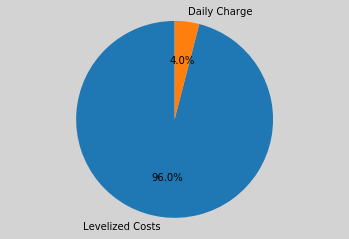

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[175.37282004416315, 101.60852469151833, 192.8812282529443, 39.2426449644676, 51.957313261507345, 7.428017160010846, 0.8767073783870041, 0.5439279209397081, 0.49925006171403385, 3300.97, 318.9541, 46.5041, 0.0, 272.45, {'Levelized Costs': 3167.9159999999997, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600910481335, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (99.8088101193262, 125.91233697414506, 231.9466757864656, 46.28711829497016, 15.204777374400361, 32.00844233687279, 0.6268203367697893, 0.25662043937966666, 0.5481182678375356)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.3
                                           and a gcr of 0.627


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5705933570861816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 126
                                           a tilt of 15.2
                                           and a gcr of 0.257


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.46583890914917 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 232
                                           a tilt of 32.0
                                           and a gcr of 0.548


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4602925777435303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 1.67324, 324.618]


ERROR:ga_logger:Cost: 3373.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,374 per year


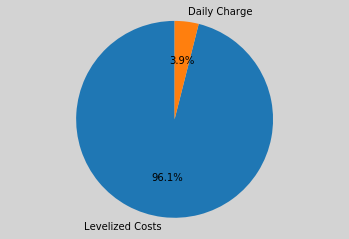

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[99.8088101193262, 125.91233697414506, 231.9466757864656, 46.28711829497016, 15.204777374400361, 32.00844233687279, 0.6268203367697893, 0.25662043937966666, 0.5481182678375356, 3373.85, 326.29124, 0.0, 1.67324, 324.618, {'Levelized Costs': 3240.788, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60209055354, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (166.22600286138902, 192.90319195566508, 108.89525119384805, 53.464904807109846, 15.28884014349288, 21.334615673548996, 0.6980915178228301, 0.8159991161027307, 0.36495312202293123)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 53.5
                                           and a gcr of 0.698


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.854459762573242 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 193
                                           a tilt of 15.3
                                           and a gcr of 0.816


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7113707065582275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 21.3
                                           and a gcr of 0.365


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6646456718444824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 189 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 314.271, 0.0]


ERROR:ga_logger:Cost: 3254.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,254 per year


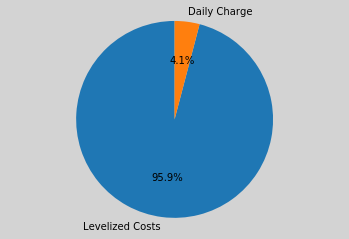

Total roof area of the  building: 599 m2
Total roof area used 385 m2
Percentage: 64.3%
succes
[[166.22600286138902, 192.90319195566508, 108.89525119384805, 53.464904807109846, 15.28884014349288, 21.334615673548996, 0.6980915178228301, 0.8159991161027307, 0.36495312202293123, 3254.46, 314.271, 0.0, 314.271, 0.0, {'Levelized Costs': 3121.393, 'Energy Charge': 0.02500000000009095, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60203135034, 61845.7, 385.137]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.11035572566152, 244.0336329042988, 248.134365771662, 53.08961329654847, 46.70038498616257, 35.819962017668125, 0.5340257263255265, 0.4858159637329654, 0.32367136543668074)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 53.1
                                           and a gcr of 0.534


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5016958713531494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 244
                                           a tilt of 46.7
                                           and a gcr of 0.486


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4663331508636475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 35.8
                                           and a gcr of 0.324


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.553914785385132 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [319.754, 0.0, 0.0]


ERROR:ga_logger:Cost: 3365.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0009 /kWh
Total Cost of the system: $ 3,365 per year


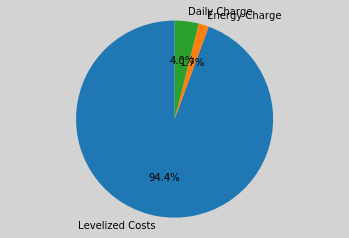

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[199.11035572566152, 244.0336329042988, 248.134365771662, 53.08961329654847, 46.70038498616257, 35.819962017668125, 0.5340257263255265, 0.4858159637329654, 0.32367136543668074, 3365.09, 319.754, 319.754, 0.0, 0.0, {'Levelized Costs': 3175.8610000000003, 'Energy Charge': 56.187000000000126, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61397.331269765644, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (133.35422489150665, 258.8104776287222, 173.08667257848032, 53.52423799173558, 30.748051658411843, 29.485624231878415, 0.7263842404570859, 0.8421758374725608, 0.8902980271737193)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 53.5
                                           and a gcr of 0.726


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5762455463409424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 30.7
                                           and a gcr of 0.842


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5513622760772705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 29.5
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.505122423171997 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 218 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 321.137]


ERROR:ga_logger:Cost: 3322.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,323 per year


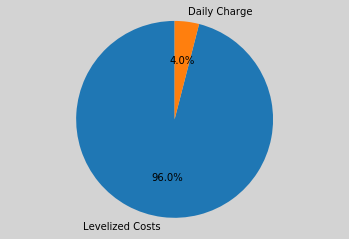

Total roof area of the  building: 599 m2
Total roof area used 361 m2
Percentage: 60.2%
succes
[[133.35422489150665, 258.8104776287222, 173.08667257848032, 53.52423799173558, 30.748051658411843, 29.485624231878415, 0.7263842404570859, 0.8421758374725608, 0.8902980271737193, 3322.65, 321.137, 0.0, 0.0, 321.137, {'Levelized Costs': 3189.592, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60097986248, 61845.7, 360.707]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230.36481059503407, 105.18056981938165, 135.11239056975552, 30.912679684993293, 3.2018309205763957, 22.895525533393958, 0.6047526052159968, 0.35330211290713176, 0.6466066242078223)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 30.9
                                           and a gcr of 0.605


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9751088619232178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 3.2
                                           and a gcr of 0.353


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3810970783233643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 22.9
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5315511226654053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 175 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.773]


ERROR:ga_logger:Cost: 3289.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,289 per year


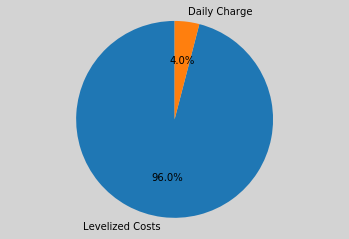

Total roof area of the  building: 599 m2
Total roof area used 491 m2
Percentage: 82.1%
succes
[[230.36481059503407, 105.18056981938165, 135.11239056975552, 30.912679684993293, 3.2018309205763957, 22.895525533393958, 0.6047526052159968, 0.35330211290713176, 0.6466066242078223, 3289.24, 317.773, 0.0, 0.0, 317.773, {'Levelized Costs': 3156.180999999999, 'Energy Charge': 0.017000000000507498, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60000238522, 61845.7, 491.447]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (171.5666093781216, 204.12703665873823, 103.23537263654688, 18.089753509892823, 50.573576318688296, 29.91212121851173, 0.8153802296580177, 0.6055776541886045, 0.29539195770879134)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 18.1
                                           and a gcr of 0.815


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4602036476135254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 50.6
                                           and a gcr of 0.606


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.506906509399414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 103
                                           a tilt of 29.9
                                           and a gcr of 0.295


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.501844644546509 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 169 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [313.17, 0.0, 0.0]


ERROR:ga_logger:Cost: 3243.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,244 per year


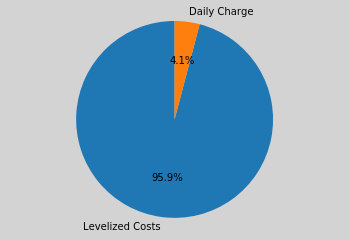

Total roof area of the  building: 599 m2
Total roof area used 384 m2
Percentage: 64.1%
succes
[[171.5666093781216, 204.12703665873823, 103.23537263654688, 18.089753509892823, 50.573576318688296, 29.91212121851173, 0.8153802296580177, 0.6055776541886045, 0.29539195770879134, 3243.52, 313.17, 313.17, 0.0, 0.0, {'Levelized Costs': 3110.468, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602268621835, 61845.7, 384.078]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (116.99725812691352, 196.27362409345648, 115.67984810149667, 1.7561383115884484, 2.8187845642155493, 39.27381590884494, 0.40097032547308853, 0.7110291061648983, 0.33051649800081756)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 1.8
                                           and a gcr of 0.401


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4402310848236084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 196
                                           a tilt of 2.8
                                           and a gcr of 0.711


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3094139099121094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 116
                                           a tilt of 39.3
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.503505229949951 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 180 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 121s


ERROR:ga_logger:panel relevance: [0.0, 328.738, 0.0]


ERROR:ga_logger:Cost: 3398.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,398 per year


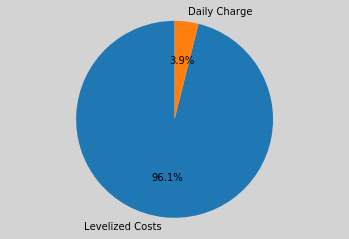

Total roof area of the  building: 599 m2
Total roof area used 462 m2
Percentage: 77.2%
succes
[[116.99725812691352, 196.27362409345648, 115.67984810149667, 1.7561383115884484, 2.8187845642155493, 39.27381590884494, 0.40097032547308853, 0.7110291061648983, 0.33051649800081756, 3398.15, 328.738, 0.0, 328.738, 0.0, {'Levelized Costs': 3265.092, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.597817849135, 61845.7, 462.341]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140.96333349217812, 155.3149323584671, 259.7098185728992, 5.530644528271517, 10.231884720359249, 21.150570905887683, 0.8975089432030965, 0.5885943415261705, 0.5496666686874538)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 5.5
                                           and a gcr of 0.898


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.52410626411438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 10.2
                                           and a gcr of 0.589


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4210405349731445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 21.2
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5558207035064697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 313.995, 0.0]


ERROR:ga_logger:Cost: 3251.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,252 per year


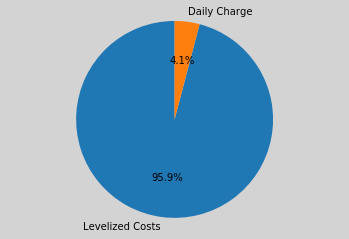

Total roof area of the  building: 599 m2
Total roof area used 533 m2
Percentage: 89.1%
succes
[[140.96333349217812, 155.3149323584671, 259.7098185728992, 5.530644528271517, 10.231884720359249, 21.150570905887683, 0.8975089432030965, 0.5885943415261705, 0.5496666686874538, 3251.72, 313.995, 0.0, 313.995, 0.0, {'Levelized Costs': 3118.6699999999996, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59978199998, 61845.7, 533.466]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (229.77642723398, 161.41015295692316, 96.94756660141346, 34.71513033224417, 16.665421562303724, 23.960495132796837, 0.6279850568748133, 0.6080655547262659, 0.23264367766525373)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 34.7
                                           and a gcr of 0.628


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8094849586486816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 16.7
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6273694038391113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 97
                                           a tilt of 24.0
                                           and a gcr of 0.233


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.69260573387146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 306.119, 0.0]


ERROR:ga_logger:Cost: 3173.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,174 per year


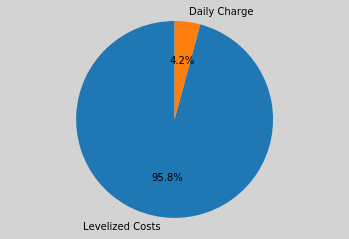

Total roof area of the  building: 599 m2
Total roof area used 503 m2
Percentage: 84.1%
succes
[[229.77642723398, 161.41015295692316, 96.94756660141346, 34.71513033224417, 16.665421562303724, 23.960495132796837, 0.6279850568748133, 0.6080655547262659, 0.23264367766525373, 3173.5, 306.119, 0.0, 306.119, 0.0, {'Levelized Costs': 3040.448, 'Energy Charge': 0.010000000000275122, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59971769986, 61845.7, 503.432]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (137.70015391838209, 245.22156892172467, 153.12565899590075, 54.55599264008246, 20.318275391718725, 2.5253204609194695, 0.42382730298174676, 0.8155157088977292, 0.6313579972322771)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 54.6
                                           and a gcr of 0.424


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.897700786590576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 20.3
                                           and a gcr of 0.816


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8035964965820312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 153
                                           a tilt of 2.5
                                           and a gcr of 0.631


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5854601860046387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 329.407]


ERROR:ga_logger:Cost: 3404.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,405 per year


Total roof area of the  building: 599 m2
Total roof area used 522 m2
Percentage: 87.1%
succes
[[137.70015391838209, 245.22156892172467, 153.12565899590075, 54.55599264008246, 20.318275391718725, 2.5253204609194695, 0.42382730298174676, 0.8155157088977292, 0.6313579972322771, 3404.8, 329.407, 0.0, 0.0, 329.407, {'Levelized Costs': 3271.742, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599572227264, 61845.7, 521.744]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (242.43307995342565, 215.8809006147437, 150.66967359305968, 30.239208196558028, 12.540327694507605, 19.0412576442182, 0.3158548397911457, 0.7907136160537989, 0.8786953979030638)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 30.2
                                           and a gcr of 0.316


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.6996471881866455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 12.5
                                           and a gcr of 0.791


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.341319799423218 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 19.0
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6986284255981445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 321.129, 0.0]


ERROR:ga_logger:Cost: 3322.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,323 per year


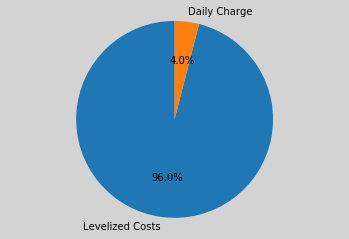

Total roof area of the  building: 599 m2
Total roof area used 406 m2
Percentage: 67.8%
succes
[[242.43307995342565, 215.8809006147437, 150.66967359305968, 30.239208196558028, 12.540327694507605, 19.0412576442182, 0.3158548397911457, 0.7907136160537989, 0.8786953979030638, 3322.57, 321.129, 0.0, 321.129, 0.0, {'Levelized Costs': 3189.508, 'Energy Charge': 0.020000000000436557, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60160759762, 61845.7, 406.126]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250.57950658566367, 144.1397607015304, 218.3048956705391, 21.094835514516078, 40.01792946661002, 15.124107853431882, 0.6870685806181307, 0.354048095773796, 0.6917107212733871)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 21.1
                                           and a gcr of 0.687


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.537318468093872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 40.0
                                           and a gcr of 0.354


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.515505313873291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 218
                                           a tilt of 15.1
                                           and a gcr of 0.692


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4810914993286133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [0.0, 105.933, 207.207]


ERROR:ga_logger:Cost: 3243.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,243 per year


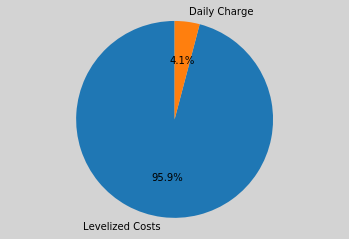

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[250.57950658566367, 144.1397607015304, 218.3048956705391, 21.094835514516078, 40.01792946661002, 15.124107853431882, 0.6870685806181307, 0.354048095773796, 0.6917107212733871, 3243.22, 313.14, 0.0, 105.933, 207.207, {'Levelized Costs': 3110.1649999999995, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60362903714, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.80256408250358, 208.00232203944614, 90.81648519852858, 42.14492627990201, 1.432539243990262, 25.770876560966165, 0.6874805811723235, 0.38361035588269166, 0.6445105678344919)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 153
                                           a tilt of 42.1
                                           and a gcr of 0.687


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.518738269805908 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 1.4
                                           and a gcr of 0.384


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2142271995544434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 25.8
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5095996856689453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [324.164, 0.0, 0.0]


ERROR:ga_logger:Cost: 3352.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,353 per year


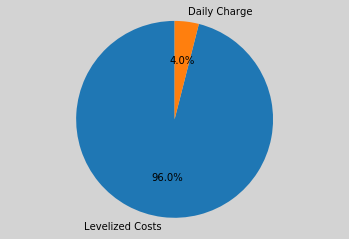

Total roof area of the  building: 599 m2
Total roof area used 472 m2
Percentage: 78.7%
succes
[[152.80256408250358, 208.00232203944614, 90.81648519852858, 42.14492627990201, 1.432539243990262, 25.770876560966165, 0.6874805811723235, 0.38361035588269166, 0.6445105678344919, 3352.72, 324.164, 324.164, 0.0, 0.0, {'Levelized Costs': 3219.662, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59932188015, 61845.7, 471.525]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (224.46386791180979, 210.9860843384584, 181.26377318652175, 48.93977865401399, 6.152488567836616, 11.469682569167409, 0.20788585622338066, 0.45950630656310526, 0.8483400003835933)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 48.9
                                           and a gcr of 0.208


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6577184200286865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 6.2
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.980851173400879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 11.5
                                           and a gcr of 0.848


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5076935291290283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.464]


ERROR:ga_logger:Cost: 3276.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,276 per year


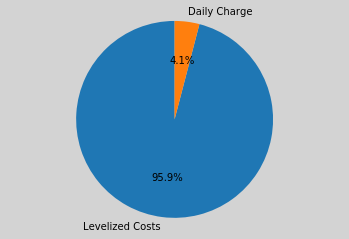

Total roof area of the  building: 599 m2
Total roof area used 373 m2
Percentage: 62.3%
succes
[[224.46386791180979, 210.9860843384584, 181.26377318652175, 48.93977865401399, 6.152488567836616, 11.469682569167409, 0.20788585622338066, 0.45950630656310526, 0.8483400003835933, 3276.24, 316.464, 0.0, 0.0, 316.464, {'Levelized Costs': 3143.185, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60310505834, 61845.7, 373.039]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (121.9429928107042, 131.1458989169586, 207.54107151590148, 36.40833743232626, 2.6412858309641036, 3.9106332147040077, 0.29589647018356435, 0.5324605981972306, 0.8635425399375871)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 122
                                           a tilt of 36.4
                                           and a gcr of 0.296


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.820709705352783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 131
                                           a tilt of 2.6
                                           and a gcr of 0.532


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.598172664642334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 3.9
                                           and a gcr of 0.864


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4872255325317383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 121s


ERROR:ga_logger:panel relevance: [99.926, 0.0, 225.433]


ERROR:ga_logger:Cost: 3364.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,365 per year


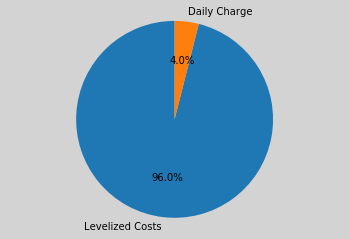

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[121.9429928107042, 131.1458989169586, 207.54107151590148, 36.40833743232626, 2.6412858309641036, 3.9106332147040077, 0.29589647018356435, 0.5324605981972306, 0.8635425399375871, 3364.58, 325.359, 99.926, 0.0, 225.433, {'Levelized Costs': 3231.523, 'Energy Charge': 0.01499999999987267, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60049180023, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.5846253499539, 182.66622694272246, 245.58287536119067, 33.96963937750739, 15.156524359928298, 22.83662936803648, 0.4938254262923606, 0.6443326119140202, 0.8453494315372954)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 34.0
                                           and a gcr of 0.494


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5437891483306885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 15.2
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.809962749481201 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 246
                                           a tilt of 22.8
                                           and a gcr of 0.845


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.577054500579834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 190 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 305.889, 0.0]


ERROR:ga_logger:Cost: 3171.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,171 per year


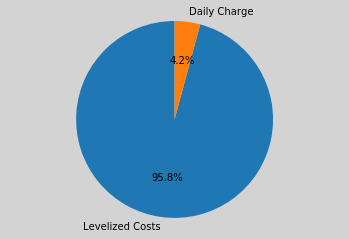

Total roof area of the  building: 599 m2
Total roof area used 475 m2
Percentage: 79.3%
succes
[[136.5846253499539, 182.66622694272246, 245.58287536119067, 33.96963937750739, 15.156524359928298, 22.83662936803648, 0.4938254262923606, 0.6443326119140202, 0.8453494315372954, 3171.21, 305.889, 0.0, 305.889, 0.0, {'Levelized Costs': 3038.1560000000004, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60158390635, 61845.7, 474.738]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.51555551145958, 261.88735386205667, 179.80858815176902, 16.935362194474834, 34.94868988459369, 50.38143058520901, 0.649146678551066, 0.27669943634451655, 0.5119265449525875)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 16.9
                                           and a gcr of 0.649


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.872657299041748 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 34.9
                                           and a gcr of 0.277


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.785304069519043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 50.4
                                           and a gcr of 0.512


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7835421562194824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 122s


ERROR:ga_logger:panel relevance: [26.8298, 0.0, 285.364]


ERROR:ga_logger:Cost: 3233.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,234 per year


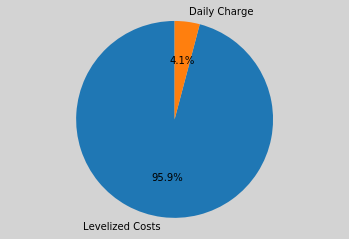

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[108.51555551145958, 261.88735386205667, 179.80858815176902, 16.935362194474834, 34.94868988459369, 50.38143058520901, 0.649146678551066, 0.27669943634451655, 0.5119265449525875, 3233.82, 312.19379999999995, 26.8298, 0.0, 285.364, {'Levelized Costs': 3100.7690000000002, 'Energy Charge': 0.008999999999900865, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600635643, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.74215256482256, 193.9851709166631, 247.14978442976295, 10.325948235239238, 5.99755169696513, 16.676057934278717, 0.31116782747867533, 0.40942415250240055, 0.22209154970550404)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 10.3
                                           and a gcr of 0.311


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.590061664581299 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 6.0
                                           and a gcr of 0.409


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.164710521697998 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 247
                                           a tilt of 16.7
                                           and a gcr of 0.222


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.50921368598938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 245.147, 0.0]


ERROR:ga_logger:Cost: 4398.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0296 /kWh
Total Cost of the system: $ 4,398 per year


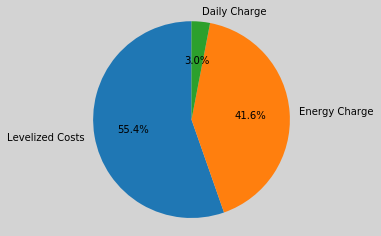

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[172.74215256482256, 193.9851709166631, 247.14978442976295, 10.325948235239238, 5.99755169696513, 16.676057934278717, 0.31116782747867533, 0.40942415250240055, 0.22209154970550404, 4398.05, 245.147, 0.0, 245.147, 0.0, {'Levelized Costs': 2434.855, 'Energy Charge': 1830.1530000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 47239.56162587501, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (234.2631112184235, 150.07633509792407, 238.63390957784512, 43.62052330181524, 55.6352177290796, 53.329836720093894, 0.3762749310113861, 0.7281994426424394, 0.8297729006724288)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 234
                                           a tilt of 43.6
                                           and a gcr of 0.376


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.819404125213623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 55.6
                                           and a gcr of 0.728


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7030880451202393 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 239
                                           a tilt of 53.3
                                           and a gcr of 0.830


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.740617275238037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [93.3212, 255.415, 0.0]


ERROR:ga_logger:Cost: 3596.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,597 per year


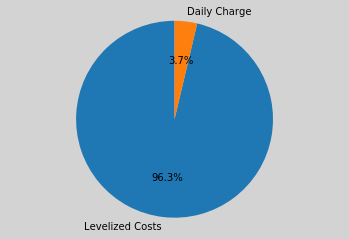

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[234.2631112184235, 150.07633509792407, 238.63390957784512, 43.62052330181524, 55.6352177290796, 53.329836720093894, 0.3762749310113861, 0.7281994426424394, 0.8297729006724288, 3596.77, 348.7362, 93.3212, 255.415, 0.0, {'Levelized Costs': 3463.71, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60082476645, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225.0890857577096, 209.77859291242822, 238.00867745495077, 18.150919810976838, 43.38165302122081, 16.571067000920817, 0.7177016583882525, 0.8881126923612832, 0.8251925461456247)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 18.2
                                           and a gcr of 0.718


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.537939786911011 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 43.4
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3862545490264893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 238
                                           a tilt of 16.6
                                           and a gcr of 0.825


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5110950469970703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [322.204, 0.0, 0.0]


ERROR:ga_logger:Cost: 3333.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,333 per year


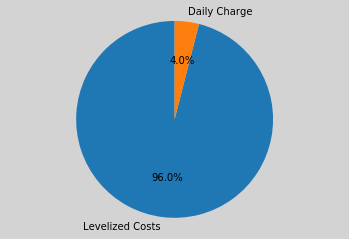

Total roof area of the  building: 599 m2
Total roof area used 449 m2
Percentage: 75.0%
succes
[[225.0890857577096, 209.77859291242822, 238.00867745495077, 18.150919810976838, 43.38165302122081, 16.571067000920817, 0.7177016583882525, 0.8881126923612832, 0.8251925461456247, 3333.26, 322.204, 322.204, 0.0, 0.0, {'Levelized Costs': 3200.202, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60080729456, 61845.7, 448.939]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (197.7597136082544, 231.3664514283177, 172.07263822030416, 48.48662954982747, 29.596825714626007, 16.937934914578435, 0.39323527790736595, 0.45975727169393205, 0.3217509549778837)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 48.5
                                           and a gcr of 0.393


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.64087176322937 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 231
                                           a tilt of 29.6
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4506142139434814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 16.9
                                           and a gcr of 0.322


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4396724700927734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 275.285, 0.0]


ERROR:ga_logger:Cost: 3942.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0174 /kWh
Total Cost of the system: $ 3,942 per year


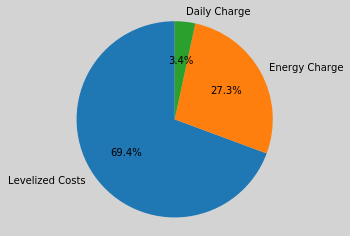

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[197.7597136082544, 231.3664514283177, 172.07263822030416, 48.48662954982747, 29.596825714626007, 16.937934914578435, 0.39323527790736595, 0.45975727169393205, 0.3217509549778837, 3942.37, 275.285, 0.0, 275.285, 0.0, {'Levelized Costs': 2734.1919999999996, 'Energy Charge': 1075.1360000000004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53265.21505662706, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.30690464695917, 219.57522383955398, 183.27429055564411, 31.78889419801447, 1.512678633807366, 37.165436802665276, 0.2090016047311508, 0.28323057291237214, 0.22973612296438212)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 31.8
                                           and a gcr of 0.209


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.911015510559082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 1.5
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4682157039642334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 37.2
                                           and a gcr of 0.230


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.536367177963257 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 137.557]


ERROR:ga_logger:Cost: 5573.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0659 /kWh
Total Cost of the system: $ 5,574 per year


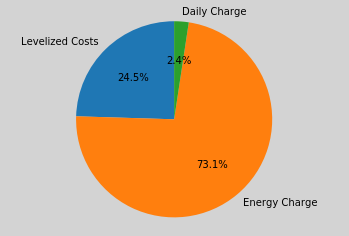

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[241.30690464695917, 219.57522383955398, 183.27429055564411, 31.78889419801447, 1.512678633807366, 37.165436802665276, 0.2090016047311508, 0.28323057291237214, 0.22973612296438212, 5573.61, 137.557, 0.0, 0.0, 137.557, {'Levelized Costs': 1366.2421999999992, 'Energy Charge': 4074.3258000000005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 29329.141729028135, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.23342180663047, 205.89813170538977, 104.2863582549246, 20.185751259015827, 16.172336477980917, 32.00748728224511, 0.7093647936529288, 0.44748569815490846, 0.31786779080327443)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 20.2
                                           and a gcr of 0.709


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7893879413604736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 16.2
                                           and a gcr of 0.447


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.669346332550049 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 104
                                           a tilt of 32.0
                                           and a gcr of 0.318


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7698819637298584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [119.065, 192.828, 0.0]


ERROR:ga_logger:Cost: 3230.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,231 per year


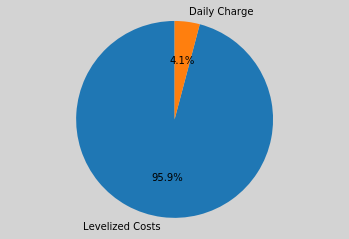

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.23342180663047, 205.89813170538977, 104.2863582549246, 20.185751259015827, 16.172336477980917, 32.00748728224511, 0.7093647936529288, 0.44748569815490846, 0.31786779080327443, 3230.84, 311.89300000000003, 119.065, 192.828, 0.0, {'Levelized Costs': 3097.768, 'Energy Charge': 0.030000000000256932, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600782144946, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.32127045368, 144.5610933621078, 262.7178091734895, 21.476761786964012, 46.12692691599282, 43.44901691843871, 0.7461525517840042, 0.6986199847794662, 0.6208264739128022)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 114
                                           a tilt of 21.5
                                           and a gcr of 0.746


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.624560832977295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 46.1
                                           and a gcr of 0.699


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4691414833068848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 43.4
                                           and a gcr of 0.621


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.459183931350708 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 133s


ERROR:ga_logger:panel relevance: [0.0, 339.054, 0.0]


ERROR:ga_logger:Cost: 3500.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,501 per year


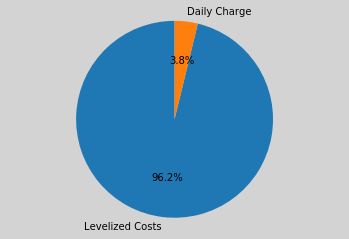

Total roof area of the  building: 599 m2
Total roof area used 485 m2
Percentage: 81.1%
succes
[[114.32127045368, 144.5610933621078, 262.7178091734895, 21.476761786964012, 46.12692691599282, 43.44901691843871, 0.7461525517840042, 0.6986199847794662, 0.6208264739128022, 3500.6, 339.054, 0.0, 339.054, 0.0, {'Levelized Costs': 3367.5359999999996, 'Energy Charge': 0.022000000000389264, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60145584982, 61845.7, 485.319]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (99.12043400293996, 200.55168515464032, 145.41482616277955, 32.45625732959833, 50.751292758956254, 47.263361424408366, 0.3230452453151262, 0.7075934519910381, 0.48092835994249916)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 99
                                           a tilt of 32.5
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.585395336151123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 201
                                           a tilt of 50.8
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.448570966720581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 47.3
                                           and a gcr of 0.481


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4114861488342285 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 113.984, 210.49]


ERROR:ga_logger:Cost: 3355.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


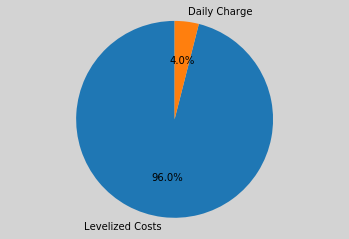

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[99.12043400293996, 200.55168515464032, 145.41482616277955, 32.45625732959833, 50.751292758956254, 47.263361424408366, 0.3230452453151262, 0.7075934519910381, 0.48092835994249916, 3355.8, 324.474, 0.0, 113.984, 210.49, {'Levelized Costs': 3222.739, 'Energy Charge': 0.019000000000175987, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59977206313, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.35449865281916, 99.76101314134911, 133.20841332500993, 41.86657499939801, 20.013608188600934, 35.982713163437715, 0.46971799766394734, 0.38072864697501263, 0.31336252847784385)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 41.9
                                           and a gcr of 0.470


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7832694053649902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 20.0
                                           and a gcr of 0.381


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.60971736907959 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 133
                                           a tilt of 36.0
                                           and a gcr of 0.313


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5864295959472656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 199 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [281.249, 0.0, 0.0]


ERROR:ga_logger:Cost: 4001.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0174 /kWh
Total Cost of the system: $ 4,002 per year


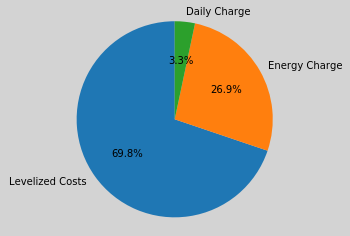

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[130.35449865281916, 99.76101314134911, 133.20841332500993, 41.86657499939801, 20.013608188600934, 35.982713163437715, 0.46971799766394734, 0.38072864697501263, 0.31336252847784385, 4001.74, 281.249, 281.249, 0.0, 0.0, {'Levelized Costs': 2793.4249999999997, 'Energy Charge': 1075.2730000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53264.11989455976, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (251.72331702073944, 232.84780923290688, 233.9617431082512, 50.88669007024008, 39.449743440530305, 34.02196571334742, 0.6157936186525629, 0.3820843411136996, 0.30506133020319937)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 50.9
                                           and a gcr of 0.616


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8896162509918213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 233
                                           a tilt of 39.4
                                           and a gcr of 0.382


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8629634380340576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 34.0
                                           and a gcr of 0.305


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8418142795562744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 133s


ERROR:ga_logger:panel relevance: [368.714, 0.0, 0.0]


ERROR:ga_logger:Cost: 4496.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0113 /kWh
Total Cost of the system: $ 4,497 per year


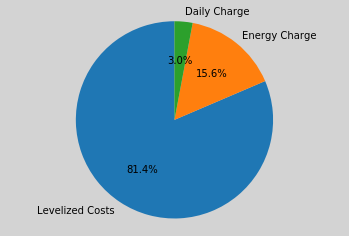

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[251.72331702073944, 232.84780923290688, 233.9617431082512, 50.88669007024008, 39.449743440530305, 34.02196571334742, 0.6157936186525629, 0.3820843411136996, 0.30506133020319937, 4496.91, 368.714, 368.714, 0.0, 0.0, {'Levelized Costs': 3662.1389999999997, 'Energy Charge': 701.7290000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56245.335731874926, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (174.75830410176673, 254.10814605617674, 98.47370645975222, 13.807265731654796, 3.6328075700042657, 11.508741768117458, 0.3409284191794675, 0.8405143692617776, 0.8580151524899711)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 13.8
                                           and a gcr of 0.341


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.617802143096924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 254
                                           a tilt of 3.6
                                           and a gcr of 0.841


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.468688726425171 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 11.5
                                           and a gcr of 0.858


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5205485820770264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [123.051, 199.903, 0.0]


ERROR:ga_logger:Cost: 3340.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,341 per year


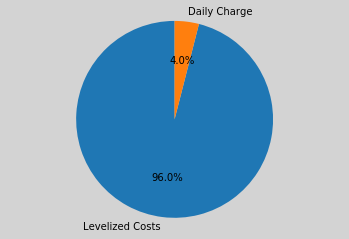

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[174.75830410176673, 254.10814605617674, 98.47370645975222, 13.807265731654796, 3.6328075700042657, 11.508741768117458, 0.3409284191794675, 0.8405143692617776, 0.8580151524899711, 3340.69, 322.954, 123.051, 199.903, 0.0, {'Levelized Costs': 3207.6270000000004, 'Energy Charge': 0.020999999999844476, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602017412326, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (244.21480549000057, 203.03636665757324, 228.78937465033871, 52.86796146317536, 43.57008900475708, 27.224634037788615, 0.6679838653228212, 0.2441238672971575, 0.4575038727632449)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 244
                                           a tilt of 52.9
                                           and a gcr of 0.668


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6336822509765625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 43.6
                                           and a gcr of 0.244


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.545067071914673 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 229
                                           a tilt of 27.2
                                           and a gcr of 0.458


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.54821515083313 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 187 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 273.936]


ERROR:ga_logger:Cost: 3890.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0168 /kWh
Total Cost of the system: $ 3,891 per year


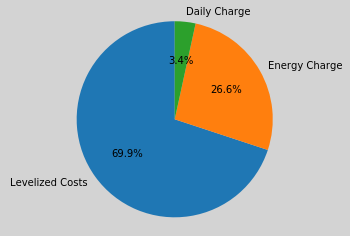

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[244.21480549000057, 203.03636665757324, 228.78937465033871, 52.86796146317536, 43.57008900475708, 27.224634037788615, 0.6679838653228212, 0.2441238672971575, 0.4575038727632449, 3890.59, 273.936, 0.0, 0.0, 273.936, {'Levelized Costs': 2720.787, 'Energy Charge': 1036.7610000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53571.47245022772, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (122.91858948464883, 191.75405153784033, 259.78351691898126, 40.07017484329424, 14.148011306665843, 18.50104520225595, 0.2060979736718001, 0.5021394480685677, 0.5761156546497012)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 123
                                           a tilt of 40.1
                                           and a gcr of 0.206


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5300076007843018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 14.1
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.378156900405884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 18.5
                                           and a gcr of 0.576


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5808022022247314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 300.662, 0.0]


ERROR:ga_logger:Cost: 3266.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0024 /kWh
Total Cost of the system: $ 3,266 per year


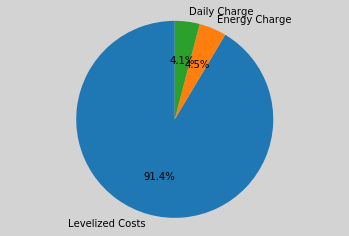

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[122.91858948464883, 191.75405153784033, 259.78351691898126, 40.07017484329424, 14.148011306665843, 18.50104520225595, 0.2060979736718001, 0.5021394480685677, 0.5761156546497012, 3266.11, 300.662, 0.0, 300.662, 0.0, {'Levelized Costs': 2986.242, 'Energy Charge': 146.82599999999996, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60673.8570056244, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (191.90534471346095, 136.61450366221533, 129.5843773582368, 3.4105282528106726, 15.344539838568158, 3.806057797824314, 0.4432647309367307, 0.4896716889052001, 0.2514954533793331)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 3.4
                                           and a gcr of 0.443


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.427136659622192 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 137
                                           a tilt of 15.3
                                           and a gcr of 0.490


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4442219734191895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 3.8
                                           and a gcr of 0.251


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3277041912078857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 293.197, 0.0]


ERROR:ga_logger:Cost: 3521.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0077 /kWh
Total Cost of the system: $ 3,522 per year


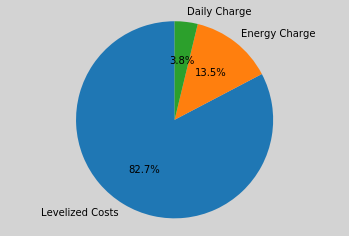

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[191.90534471346095, 136.61450366221533, 129.5843773582368, 3.4105282528106726, 15.344539838568158, 3.806057797824314, 0.4432647309367307, 0.4896716889052001, 0.2514954533793331, 3521.78, 293.197, 0.0, 293.197, 0.0, {'Levelized Costs': 2912.09, 'Energy Charge': 476.64800000000025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58041.67071552988, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (94.54778450311265, 173.5693887765135, 113.39802803541062, 24.449645208357843, 49.50372257421952, 46.39337094266579, 0.2687091662949369, 0.20560677102974423, 0.3250352237311802)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 24.4
                                           and a gcr of 0.269


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5343425273895264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 49.5
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.438967227935791 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 113
                                           a tilt of 46.4
                                           and a gcr of 0.325


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.455446720123291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 180 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 121s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 194.619]


ERROR:ga_logger:Cost: 5445.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0546 /kWh
Total Cost of the system: $ 5,446 per year


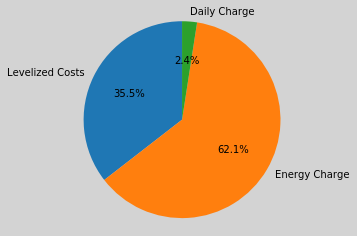

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[94.54778450311265, 173.5693887765135, 113.39802803541062, 24.449645208357843, 49.50372257421952, 46.39337094266579, 0.2687091662949369, 0.20560677102974423, 0.3250352237311802, 5445.87, 194.619, 0.0, 0.0, 194.619, {'Levelized Costs': 1932.9941999999996, 'Energy Charge': 3379.8338000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 34871.79072993009, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (213.68379566202262, 246.51292209637094, 174.24518242456924, 54.22013352843344, 15.830369129031805, 32.56569285216939, 0.8050349357170818, 0.5828930990846248, 0.2803844840702177)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 54.2
                                           and a gcr of 0.805


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7892134189605713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 247
                                           a tilt of 15.8
                                           and a gcr of 0.583


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7817306518554688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 32.6
                                           and a gcr of 0.280


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8112852573394775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 201 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 126s


ERROR:ga_logger:panel relevance: [0.0, 308.309, 19.5798]


ERROR:ga_logger:Cost: 3389.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,390 per year


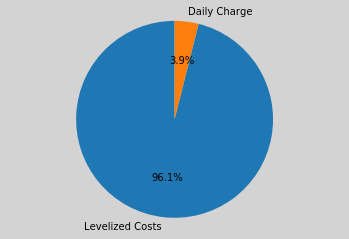

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[213.68379566202262, 246.51292209637094, 174.24518242456924, 54.22013352843344, 15.830369129031805, 32.56569285216939, 0.8050349357170818, 0.5828930990846248, 0.2803844840702177, 3389.72, 327.8888, 0.0, 308.309, 19.5798, {'Levelized Costs': 3256.6649999999995, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601740392885, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (106.2212756447475, 134.7681647997353, 221.85557123016446, 9.903757412749034, 23.4683180044396, 6.246533367325864, 0.5877723009818365, 0.7345757946632574, 0.3869990113259594)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 9.9
                                           and a gcr of 0.588


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.508908987045288 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 23.5
                                           and a gcr of 0.735


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4908602237701416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 6.2
                                           and a gcr of 0.387


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5193228721618652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 324.647, 0.0]


ERROR:ga_logger:Cost: 3357.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,358 per year


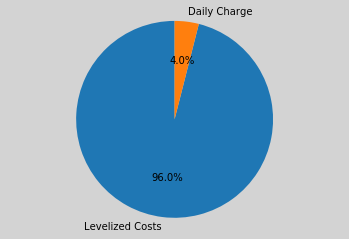

Total roof area of the  building: 599 m2
Total roof area used 442 m2
Percentage: 73.8%
succes
[[106.2212756447475, 134.7681647997353, 221.85557123016446, 9.903757412749034, 23.4683180044396, 6.246533367325864, 0.5877723009818365, 0.7345757946632574, 0.3869990113259594, 3357.52, 324.647, 0.0, 324.647, 0.0, {'Levelized Costs': 3224.457, 'Energy Charge': 0.02100000000007185, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6014384299, 61845.7, 441.952]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (182.2934826653714, 171.86534859497496, 91.51074851135222, 6.917401434131564, 6.315098438750291, 45.29418388079285, 0.46427246299389124, 0.374498030998629, 0.2059178398608759)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 6.9
                                           and a gcr of 0.464


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.167258262634277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 6.3
                                           and a gcr of 0.374


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.590616464614868 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 45.3
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6046409606933594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [277.989, 0.0, 0.0]


ERROR:ga_logger:Cost: 3872.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0158 /kWh
Total Cost of the system: $ 3,872 per year


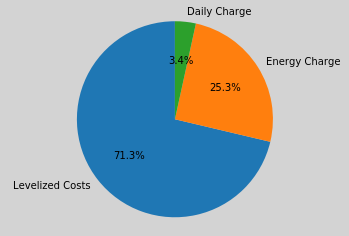

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[182.2934826653714, 171.86534859497496, 91.51074851135222, 6.917401434131564, 6.315098438750291, 45.29418388079285, 0.46427246299389124, 0.374498030998629, 0.2059178398608759, 3872.32, 277.989, 277.989, 0.0, 0.0, {'Levelized Costs': 2761.046, 'Energy Charge': 978.2320000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 54038.54578173062, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.89276670229103, 180.07163308030493, 109.66536542061284, 19.639498290208163, 41.611919082185544, 53.85886749325401, 0.7132287622875186, 0.40594713461334503, 0.8122866319777913)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 19.6
                                           and a gcr of 0.713


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3703393936157227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 41.6
                                           and a gcr of 0.406


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4750759601593018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 53.9
                                           and a gcr of 0.812


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4361636638641357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 179 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [132.036, 167.915, 0.0]


ERROR:ga_logger:Cost: 3112.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,112 per year


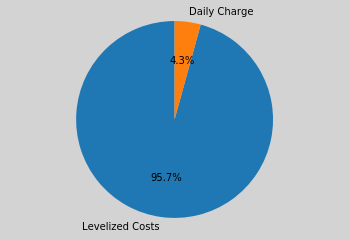

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[172.89276670229103, 180.07163308030493, 109.66536542061284, 19.639498290208163, 41.611919082185544, 53.85886749325401, 0.7132287622875186, 0.40594713461334503, 0.8122866319777913, 3112.23, 299.951, 132.036, 167.915, 0.0, {'Levelized Costs': 2979.171, 'Energy Charge': 0.01700000000039381, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600483257425, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (194.50960001669367, 211.24551876411482, 225.7588026366408, 15.843873751754368, 52.771202931973114, 7.419613958311166, 0.2694321901258722, 0.5160187143119567, 0.7529415581186054)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 15.8
                                           and a gcr of 0.269


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.518925189971924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 52.8
                                           and a gcr of 0.516


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.460897207260132 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 7.4
                                           and a gcr of 0.753


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.025099515914917 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 189 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [72.6936, 0.0, 247.687]


ERROR:ga_logger:Cost: 3315.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,315 per year


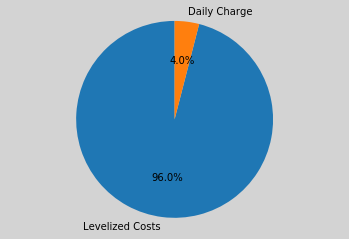

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[194.50960001669367, 211.24551876411482, 225.7588026366408, 15.843873751754368, 52.771202931973114, 7.419613958311166, 0.2694321901258722, 0.5160187143119567, 0.7529415581186054, 3315.14, 320.3806, 72.6936, 0.0, 247.687, {'Levelized Costs': 3182.082, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60252720471, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (227.98563230189276, 161.0044801962722, 102.3520270145685, 18.85798583890826, 24.91099524479904, 18.39247813502618, 0.7071704625069946, 0.6301273625660224, 0.29931872231233686)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 18.9
                                           and a gcr of 0.707


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6417577266693115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 24.9
                                           and a gcr of 0.630


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6017792224884033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 18.4
                                           and a gcr of 0.299


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.610989809036255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [0.0, 303.987, 0.0]


ERROR:ga_logger:Cost: 3152.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,152 per year


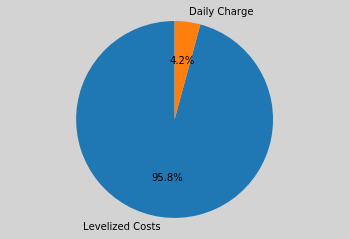

Total roof area of the  building: 599 m2
Total roof area used 482 m2
Percentage: 80.6%
succes
[[227.98563230189276, 161.0044801962722, 102.3520270145685, 18.85798583890826, 24.91099524479904, 18.39247813502618, 0.7071704625069946, 0.6301273625660224, 0.29931872231233686, 3152.32, 303.987, 0.0, 303.987, 0.0, {'Levelized Costs': 3019.259, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60265659986, 61845.7, 482.422]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105.80635906555997, 133.1110885267479, 143.9103726799242, 46.710856068699776, 30.355881606514643, 4.397659868240813, 0.3817122775993967, 0.21777599496835742, 0.7877252850203289)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 46.7
                                           and a gcr of 0.382


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5072035789489746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 30.4
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6604456901550293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 4.4
                                           and a gcr of 0.788


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3755946159362793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 179 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 56.9894, 265.521]


ERROR:ga_logger:Cost: 3336.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,336 per year


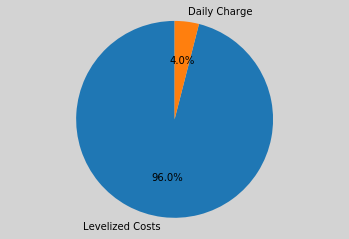

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[105.80635906555997, 133.1110885267479, 143.9103726799242, 46.710856068699776, 30.355881606514643, 4.397659868240813, 0.3817122775993967, 0.21777599496835742, 0.7877252850203289, 3336.3, 322.5104, 0.0, 56.9894, 265.521, {'Levelized Costs': 3203.2380000000003, 'Energy Charge': 0.01999999999998181, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60142925301, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (204.19834931795475, 242.23210564528057, 100.50832674670507, 23.476934341703416, 6.816769570268646, 47.979821329949665, 0.3316742728653498, 0.3395855148100918, 0.7723941794369358)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 23.5
                                           and a gcr of 0.332


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6014983654022217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 242
                                           a tilt of 6.8
                                           and a gcr of 0.340


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.421751499176025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 48.0
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6766483783721924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [25.0766, 0.0, 404.082]


ERROR:ga_logger:Cost: 4395.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,396 per year


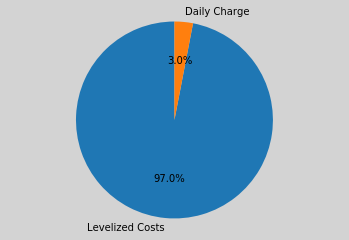

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[204.19834931795475, 242.23210564528057, 100.50832674670507, 23.476934341703416, 6.816769570268646, 47.979821329949665, 0.3316742728653498, 0.3395855148100918, 0.7723941794369358, 4395.55, 429.1586, 25.0766, 0.0, 404.082, {'Levelized Costs': 4262.491, 'Energy Charge': 0.016999999999939064, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60140480009, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.3671707292615, 187.5018596819347, 239.00376245372271, 4.792571070977641, 19.45666453232926, 4.4179413424047045, 0.44043182198380637, 0.6789482881678666, 0.871979983397817)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 4.8
                                           and a gcr of 0.440


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.411677122116089 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 19.5
                                           and a gcr of 0.679


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4698243141174316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 239
                                           a tilt of 4.4
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.419910430908203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 203 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 304.268, 0.0]


ERROR:ga_logger:Cost: 3155.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,155 per year


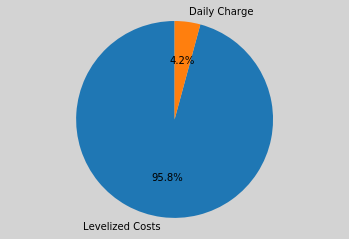

Total roof area of the  building: 599 m2
Total roof area used 448 m2
Percentage: 74.8%
succes
[[144.3671707292615, 187.5018596819347, 239.00376245372271, 4.792571070977641, 19.45666453232926, 4.4179413424047045, 0.44043182198380637, 0.6789482881678666, 0.871979983397817, 3155.11, 304.268, 0.0, 304.268, 0.0, {'Levelized Costs': 3022.0570000000002, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59941654269, 61845.7, 448.146]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (159.16439248936135, 252.5674026543399, 250.38155826877713, 3.5096371510282944, 13.611961970159173, 34.11459592039124, 0.23194184971276605, 0.5453459584735512, 0.6725300162177119)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 3.5
                                           and a gcr of 0.232


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7426116466522217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 13.6
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6940853595733643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 34.1
                                           and a gcr of 0.673


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.73774790763855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 271.457, 67.9192]


ERROR:ga_logger:Cost: 3503.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,504 per year


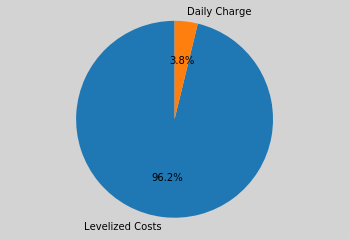

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[159.16439248936135, 252.5674026543399, 250.38155826877713, 3.5096371510282944, 13.611961970159173, 34.11459592039124, 0.23194184971276605, 0.5453459584735512, 0.6725300162177119, 3503.81, 339.3762, 0.0, 271.457, 67.9192, {'Levelized Costs': 3370.761, 'Energy Charge': 0.0070000000001755325, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60153452421, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.0958595453448, 107.45292213252138, 234.38263663335897, 34.35169408243125, 14.493160638376512, 55.305800439896004, 0.7175270322562843, 0.8910012230393745, 0.8647836843941956)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 34.4
                                           and a gcr of 0.718


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.423367738723755 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 107
                                           a tilt of 14.5
                                           and a gcr of 0.891


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4174857139587402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 55.3
                                           and a gcr of 0.865


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.443023920059204 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [318.77, 0.0, 0.0]


ERROR:ga_logger:Cost: 3299.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,299 per year


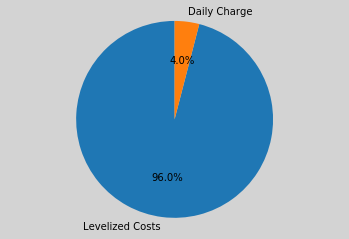

Total roof area of the  building: 599 m2
Total roof area used 444 m2
Percentage: 74.2%
succes
[[152.0958595453448, 107.45292213252138, 234.38263663335897, 34.35169408243125, 14.493160638376512, 55.305800439896004, 0.7175270322562843, 0.8910012230393745, 0.8647836843941956, 3299.14, 318.77, 318.77, 0.0, 0.0, {'Levelized Costs': 3166.0739999999996, 'Energy Charge': 0.024000000000228283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60078674006, 61845.7, 444.262]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (251.38918273722982, 186.33704084368395, 262.56634065934765, 13.555681134795451, 35.0582810167159, 14.319770876525926, 0.2155935089613696, 0.654200710056349, 0.8144927370449764)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 13.6
                                           and a gcr of 0.216


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.593994617462158 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 35.1
                                           and a gcr of 0.654


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4877912998199463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 14.3
                                           and a gcr of 0.814


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5321314334869385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 303.02, 0.0]


ERROR:ga_logger:Cost: 3142.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,143 per year


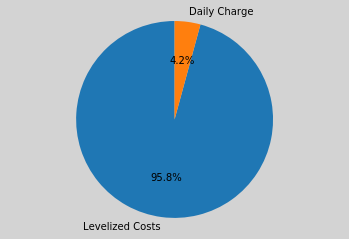

Total roof area of the  building: 599 m2
Total roof area used 463 m2
Percentage: 77.4%
succes
[[251.38918273722982, 186.33704084368395, 262.56634065934765, 13.555681134795451, 35.0582810167159, 14.319770876525926, 0.2155935089613696, 0.654200710056349, 0.8144927370449764, 3142.71, 303.02, 0.0, 303.02, 0.0, {'Levelized Costs': 3009.654, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602360732075, 61845.7, 463.19]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.3920392444558, 195.80481789478173, 253.55365202304944, 34.75502185478285, 19.63694614287304, 14.56187160533054, 0.42487059867402244, 0.5204951194735634, 0.5673224063366346)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 132
                                           a tilt of 34.8
                                           and a gcr of 0.425


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4838809967041016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 196
                                           a tilt of 19.6
                                           and a gcr of 0.520


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.629002809524536 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 14.6
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7903192043304443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 175 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 301.928, 0.0]


ERROR:ga_logger:Cost: 3131.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,132 per year


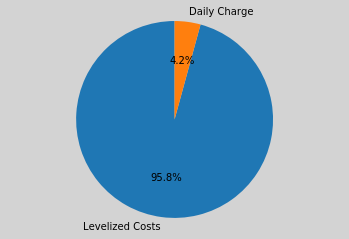

Total roof area of the  building: 599 m2
Total roof area used 580 m2
Percentage: 96.9%
succes
[[132.3920392444558, 195.80481789478173, 253.55365202304944, 34.75502185478285, 19.63694614287304, 14.56187160533054, 0.42487059867402244, 0.5204951194735634, 0.5673224063366346, 3131.87, 301.928, 0.0, 301.928, 0.0, {'Levelized Costs': 2998.805, 'Energy Charge': 0.022999999999967713, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59986928659, 61845.7, 580.078]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.87402297993445, 109.25152029690076, 210.5125928512506, 30.080969952600515, 14.365725630460808, 50.75153518335342, 0.8811397267315075, 0.5743988806320486, 0.737579788247618)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 30.1
                                           and a gcr of 0.881


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6619322299957275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 109
                                           a tilt of 14.4
                                           and a gcr of 0.574


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.637132406234741 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 50.8
                                           and a gcr of 0.738


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.67737078666687 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [0.0, 329.087, 0.0]


ERROR:ga_logger:Cost: 3401.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,402 per year


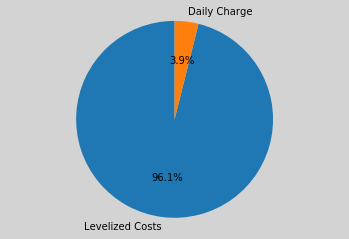

Total roof area of the  building: 599 m2
Total roof area used 573 m2
Percentage: 95.7%
succes
[[120.87402297993445, 109.25152029690076, 210.5125928512506, 30.080969952600515, 14.365725630460808, 50.75153518335342, 0.8811397267315075, 0.5743988806320486, 0.737579788247618, 3401.62, 329.087, 0.0, 329.087, 0.0, {'Levelized Costs': 3268.561, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60080591999, 61845.7, 572.925]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (209.81558040273825, 153.98257320741922, 189.00768956769812, 18.984347857343646, 2.6845856915527104, 5.942772498541139, 0.43396387200515985, 0.8926328650661577, 0.5335394163305481)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 19.0
                                           and a gcr of 0.434


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6178066730499268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 2.7
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.413867950439453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 5.9
                                           and a gcr of 0.534


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4747538566589355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 179 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [208.956, 104.666, 0.0]


ERROR:ga_logger:Cost: 3248.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,248 per year


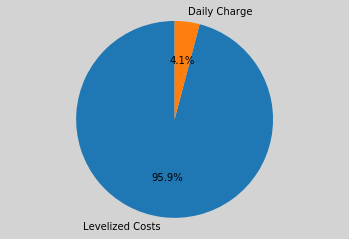

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[209.81558040273825, 153.98257320741922, 189.00768956769812, 18.984347857343646, 2.6845856915527104, 5.942772498541139, 0.43396387200515985, 0.8926328650661577, 0.5335394163305481, 3248.02, 313.62199999999996, 208.956, 104.666, 0.0, {'Levelized Costs': 3114.963, 'Energy Charge': 0.01499999999987267, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59933875296, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (206.54258529421094, 149.3253655745622, 95.46945502080482, 48.306132149971845, 42.43299752687081, 43.47003849119679, 0.5692844874666407, 0.6442813777307056, 0.2717304916758859)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 207
                                           a tilt of 48.3
                                           and a gcr of 0.569


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.486423969268799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 42.4
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7449426651000977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 43.5
                                           and a gcr of 0.272


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.637331008911133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [322.434, 0.0, 0.0]


ERROR:ga_logger:Cost: 3335.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,336 per year


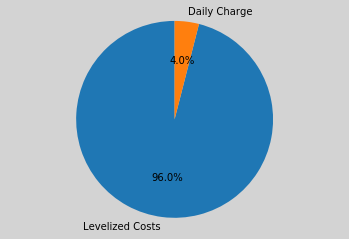

Total roof area of the  building: 599 m2
Total roof area used 566 m2
Percentage: 94.6%
succes
[[206.54258529421094, 149.3253655745622, 95.46945502080482, 48.306132149971845, 42.43299752687081, 43.47003849119679, 0.5692844874666407, 0.6442813777307056, 0.2717304916758859, 3335.54, 322.434, 322.434, 0.0, 0.0, {'Levelized Costs': 3202.4819999999995, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60018262467, 61845.7, 566.385]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (216.29133463786644, 177.76075627509437, 139.945243704608, 7.053240174029014, 43.74261566513866, 26.052042639287496, 0.8942875080136417, 0.7558165065078888, 0.7696715232144288)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 7.1
                                           and a gcr of 0.894


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.446739673614502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 43.7
                                           and a gcr of 0.756


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.537665843963623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 26.1
                                           and a gcr of 0.770


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5443832874298096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 318.077, 0.0]


ERROR:ga_logger:Cost: 3292.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,292 per year


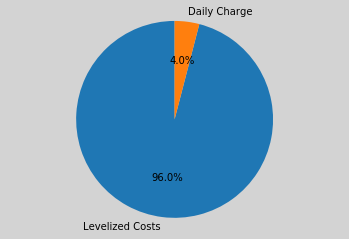

Total roof area of the  building: 599 m2
Total roof area used 421 m2
Percentage: 70.3%
succes
[[216.29133463786644, 177.76075627509437, 139.945243704608, 7.053240174029014, 43.74261566513866, 26.052042639287496, 0.8942875080136417, 0.7558165065078888, 0.7696715232144288, 3292.27, 318.077, 0.0, 318.077, 0.0, {'Levelized Costs': 3159.2140000000004, 'Energy Charge': 0.01399999999978263, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60096221001, 61845.7, 420.84]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (109.79385215454414, 92.6097355325272, 124.32134300198734, 5.183957834380761, 9.601012813525056, 6.829310494265761, 0.2710497144883105, 0.7083335610055437, 0.4292449360819479)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 5.2
                                           and a gcr of 0.271


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.579071521759033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 9.6
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6276185512542725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 6.8
                                           and a gcr of 0.429


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6299185752868652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 126s


ERROR:ga_logger:panel relevance: [0.0, 191.93, 140.707]


ERROR:ga_logger:Cost: 3436.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,437 per year


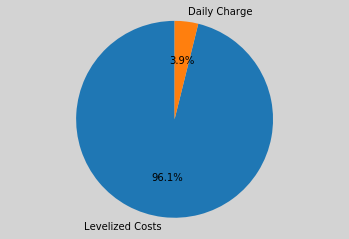

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[109.79385215454414, 92.6097355325272, 124.32134300198734, 5.183957834380761, 9.601012813525056, 6.829310494265761, 0.2710497144883105, 0.7083335610055437, 0.4292449360819479, 3436.88, 332.637, 0.0, 191.93, 140.707, {'Levelized Costs': 3303.8249999999994, 'Energy Charge': 0.013000000000602085, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603198890174, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (213.7995608617461, 237.28095921701183, 208.4225486566374, 48.72953631092352, 5.452947072788282, 21.06776983365225, 0.6024421980811137, 0.6087383845151946, 0.7114760269855152)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 48.7
                                           and a gcr of 0.602


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4194931983947754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 5.5
                                           and a gcr of 0.609


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.445958137512207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 21.1
                                           and a gcr of 0.711


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6390130519866943 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 312.78]


ERROR:ga_logger:Cost: 3239.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,240 per year


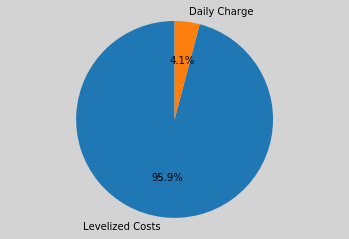

Total roof area of the  building: 599 m2
Total roof area used 440 m2
Percentage: 73.4%
succes
[[213.7995608617461, 237.28095921701183, 208.4225486566374, 48.72953631092352, 5.452947072788282, 21.06776983365225, 0.6024421980811137, 0.6087383845151946, 0.7114760269855152, 3239.65, 312.78, 0.0, 0.0, 312.78, {'Levelized Costs': 3106.59, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59950862847, 61845.7, 439.622]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (197.7597136082544, 231.3664514283177, 158.4040075066036, 37.10047391034783, 29.944905038251477, 23.447246048712344, 0.3805855787908746, 0.4664772921731505, 0.36160952232041366)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 37.1
                                           and a gcr of 0.381


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4680771827697754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 231
                                           a tilt of 29.9
                                           and a gcr of 0.466


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3938398361206055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 158
                                           a tilt of 23.4
                                           and a gcr of 0.362


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.58553409576416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 279.309, 0.0]


ERROR:ga_logger:Cost: 3894.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0160 /kWh
Total Cost of the system: $ 3,895 per year


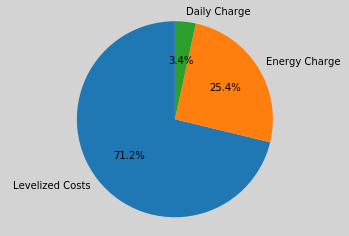

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[197.7597136082544, 231.3664514283177, 158.4040075066036, 37.10047391034783, 29.944905038251477, 23.447246048712344, 0.3805855787908746, 0.4664772921731505, 0.36160952232041366, 3894.91, 279.309, 0.0, 279.309, 0.0, {'Levelized Costs': 2774.1549999999997, 'Energy Charge': 987.7130000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53962.90632736503, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (228.39004638039222, 204.32570763663776, 210.5125928512506, 44.94709372394846, 53.20017481908536, 53.09448978607101, 0.8849770992034991, 0.5658104942249037, 0.7181137887534393)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 44.9
                                           and a gcr of 0.885


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5764503479003906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 53.2
                                           and a gcr of 0.566


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.411442756652832 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 53.1
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.41776442527771 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 175 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 124s


ERROR:ga_logger:panel relevance: [0.0, 328.649, 0.0]


ERROR:ga_logger:Cost: 3397.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,397 per year


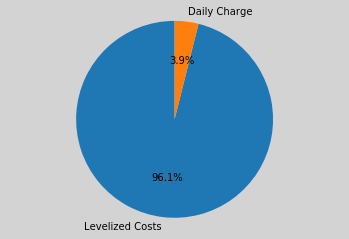

Total roof area of the  building: 599 m2
Total roof area used 581 m2
Percentage: 97.0%
succes
[[228.39004638039222, 204.32570763663776, 210.5125928512506, 44.94709372394846, 53.20017481908536, 53.09448978607101, 0.8849770992034991, 0.5658104942249037, 0.7181137887534393, 3397.26, 328.649, 0.0, 328.649, 0.0, {'Levelized Costs': 3264.205, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601731680996, 61845.7, 580.846]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (118.6355708939686, 112.67253139598941, 94.39573631253685, 31.025567390916738, 13.184150615442402, 16.383391407164133, 0.44613666633526944, 0.862692728388111, 0.591057310286746)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 31.0
                                           and a gcr of 0.446


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.550779104232788 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 113
                                           a tilt of 13.2
                                           and a gcr of 0.863


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.358444929122925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 16.4
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.402287006378174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 132s


ERROR:ga_logger:panel relevance: [197.512, 134.619, 0.0]


ERROR:ga_logger:Cost: 3431.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,432 per year


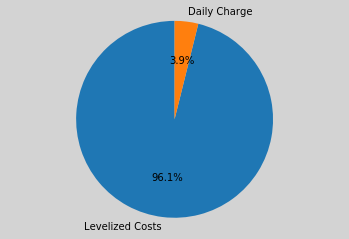

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[118.6355708939686, 112.67253139598941, 94.39573631253685, 31.025567390916738, 13.184150615442402, 16.383391407164133, 0.44613666633526944, 0.862692728388111, 0.591057310286746, 3431.85, 332.131, 197.512, 134.619, 0.0, {'Levelized Costs': 3298.7889999999998, 'Energy Charge': 0.019000000000175987, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601427460024, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (168.88352653330844, 99.81926509568159, 214.92361764365714, 39.2426449644676, 54.948900731184374, 24.777154965821804, 0.8975275311896806, 0.5551235442878486, 0.4353629036130132)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 39.2
                                           and a gcr of 0.898


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5836336612701416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 54.9
                                           and a gcr of 0.555


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.416602373123169 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 24.8
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.493786573410034 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [102.616, 0.0, 210.903]


ERROR:ga_logger:Cost: 3246.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,247 per year


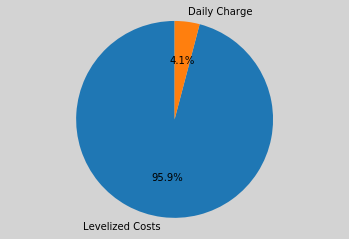

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[168.88352653330844, 99.81926509568159, 214.92361764365714, 39.2426449644676, 54.948900731184374, 24.777154965821804, 0.8975275311896806, 0.5551235442878486, 0.4353629036130132, 3246.99, 313.519, 102.616, 0.0, 210.903, {'Levelized Costs': 3113.942, 'Energy Charge': 0.006000000000028649, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60346207799, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (94.46930204335946, 99.18156661777665, 209.70625566747492, 1.878606315624431, 46.59724005928214, 10.101904851627621, 0.8102442703924808, 0.2270205051896407, 0.42392581047199174)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 1.9
                                           and a gcr of 0.810


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3833062648773193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 46.6
                                           and a gcr of 0.227


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.512148857116699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 10.1
                                           and a gcr of 0.424


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.680689811706543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 189 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [148.162, 0.0, 176.311]


ERROR:ga_logger:Cost: 3355.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


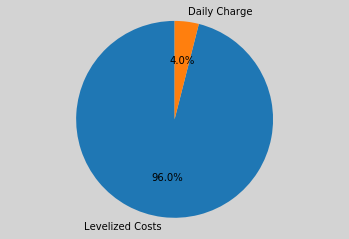

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[94.46930204335946, 99.18156661777665, 209.70625566747492, 1.878606315624431, 46.59724005928214, 10.101904851627621, 0.8102442703924808, 0.2270205051896407, 0.42392581047199174, 3355.79, 324.473, 148.162, 0.0, 176.311, {'Levelized Costs': 3222.739, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60185716506, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (174.75830410176673, 254.10814605617674, 150.80092312000545, 54.83942074937427, 15.903606560115392, 11.120299930088091, 0.4239356313276441, 0.8933371745180526, 0.8398730424160107)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 54.8
                                           and a gcr of 0.424


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.865389585494995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 254
                                           a tilt of 15.9
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.677217721939087 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 11.1
                                           and a gcr of 0.840


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.673933744430542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 201 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [189.791, 0.0, 126.883]


ERROR:ga_logger:Cost: 3278.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,278 per year


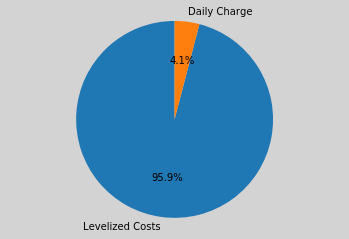

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[174.75830410176673, 254.10814605617674, 150.80092312000545, 54.83942074937427, 15.903606560115392, 11.120299930088091, 0.4239356313276441, 0.8933371745180526, 0.8398730424160107, 3278.32, 316.674, 189.791, 0.0, 126.883, {'Levelized Costs': 3145.2630000000004, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600849462164, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (137.70015391838209, 242.17941022474758, 99.9936074403721, 12.62759531628545, 3.6129214552586966, 2.766733634541192, 0.33483107219135144, 0.8155157088977292, 0.6313579972322771)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 12.6
                                           and a gcr of 0.335


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.429253101348877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 242
                                           a tilt of 3.6
                                           and a gcr of 0.816


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3918237686157227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 2.8
                                           and a gcr of 0.631


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.392693281173706 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 233 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [113.309, 212.324, 0.0]


ERROR:ga_logger:Cost: 3367.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,367 per year


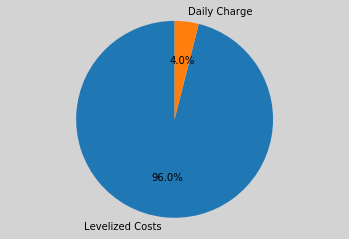

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[137.70015391838209, 242.17941022474758, 99.9936074403721, 12.62759531628545, 3.6129214552586966, 2.766733634541192, 0.33483107219135144, 0.8155157088977292, 0.6313579972322771, 3367.31, 325.63300000000004, 113.309, 212.324, 0.0, {'Levelized Costs': 3234.2649999999994, 'Energy Charge': 0.0030000000006111804, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601444381806, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.5479728601986, 215.67170928679053, 155.5731005782427, 52.39355133351798, 30.355881606514643, 43.49842694384231, 0.8348542653563881, 0.5430236218300553, 0.8016985487396405)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 52.4
                                           and a gcr of 0.835


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.817650318145752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 30.4
                                           and a gcr of 0.543


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6594293117523193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 156
                                           a tilt of 43.5
                                           and a gcr of 0.802


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6842947006225586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 310.482, 0.0]


ERROR:ga_logger:Cost: 3216.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,217 per year


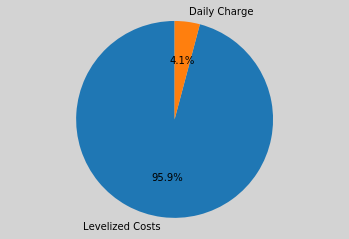

Total roof area of the  building: 599 m2
Total roof area used 572 m2
Percentage: 95.5%
succes
[[199.5479728601986, 215.67170928679053, 155.5731005782427, 52.39355133351798, 30.355881606514643, 43.49842694384231, 0.8348542653563881, 0.5430236218300553, 0.8016985487396405, 3216.83, 310.482, 0.0, 310.482, 0.0, {'Levelized Costs': 3083.7719999999995, 'Energy Charge': 0.016000000000531145, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601001892166, 61845.7, 571.765]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110.10172418828172, 132.5482168845419, 174.42769069150796, 18.017817663451822, 4.270432516112076, 4.419519691231194, 0.36446926777312066, 0.24349001920311852, 0.23787712030580158)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 18.0
                                           and a gcr of 0.364


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4010605812072754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 4.3
                                           and a gcr of 0.243


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5209121704101562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 4.4
                                           and a gcr of 0.238


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.400731325149536 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 185 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [218.23, 0.0, 0.0]


ERROR:ga_logger:Cost: 4846.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0412 /kWh
Total Cost of the system: $ 4,847 per year


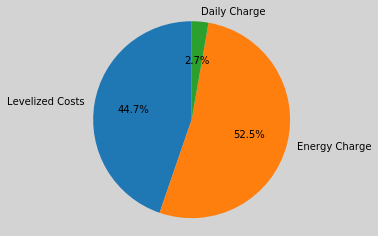

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[110.10172418828172, 132.5482168845419, 174.42769069150796, 18.017817663451822, 4.270432516112076, 4.419519691231194, 0.36446926777312066, 0.24349001920311852, 0.23787712030580158, 4846.62, 218.23, 218.23, 0.0, 0.0, {'Levelized Costs': 2167.5061999999994, 'Energy Charge': 2546.0718000000006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 41525.904389580064, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (209.32409940380833, 210.9860843384584, 196.14325549064247, 48.93977865401399, 6.152488567836616, 10.953439464279949, 0.3876905312201726, 0.8746284881836869, 0.8709471645781351)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 209
                                           a tilt of 48.9
                                           and a gcr of 0.388


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4375321865081787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 6.2
                                           and a gcr of 0.875


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.590742349624634 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 11.0
                                           and a gcr of 0.871


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.464520215988159 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 207 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [163.857, 0.0, 153.385]


ERROR:ga_logger:Cost: 3283.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,284 per year


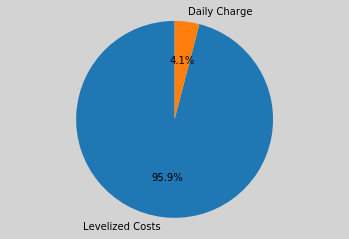

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[209.32409940380833, 210.9860843384584, 196.14325549064247, 48.93977865401399, 6.152488567836616, 10.953439464279949, 0.3876905312201726, 0.8746284881836869, 0.8709471645781351, 3283.97, 317.24199999999996, 163.857, 0.0, 153.385, {'Levelized Costs': 3150.9149999999995, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6015886085, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200.3197617352017, 153.98257320741922, 205.07160162765783, 18.984347857343646, 1.5843146514032433, 5.942772498541139, 0.20037875988452022, 0.5705251078062, 0.528580209031407)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 19.0
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6296133995056152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 1.6
                                           and a gcr of 0.571


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.570984363555908 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 5.9
                                           and a gcr of 0.529


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.686671257019043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 198 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.494]


ERROR:ga_logger:Cost: 3420.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0023 /kWh
Total Cost of the system: $ 3,420 per year


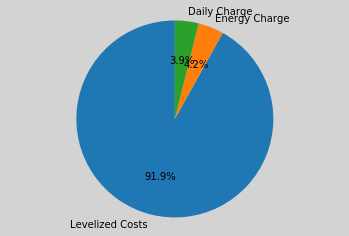

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[200.3197617352017, 153.98257320741922, 205.07160162765783, 18.984347857343646, 1.5843146514032433, 5.942772498541139, 0.20037875988452022, 0.5705251078062, 0.528580209031407, 3420.24, 316.494, 0.0, 0.0, 316.494, {'Levelized Costs': 3143.4869999999996, 'Energy Charge': 143.71100000000013, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60698.718481729935, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (244.88455206141413, 181.41984319393174, 187.88005869691537, 51.878852579531944, 27.23871374492796, 41.124037928774165, 0.7750079570746213, 0.5787354673144083, 0.7328114893835609)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 51.9
                                           and a gcr of 0.775


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.484095811843872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 27.2
                                           and a gcr of 0.579


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.428628444671631 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 41.1
                                           and a gcr of 0.733


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4228241443634033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 201 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [0.0, 296.897, 0.0]


ERROR:ga_logger:Cost: 3081.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,082 per year


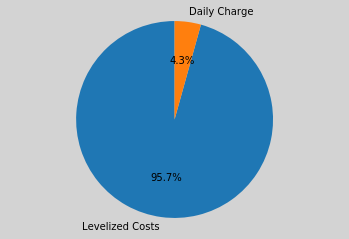

Total roof area of the  building: 599 m2
Total roof area used 513 m2
Percentage: 85.7%
succes
[[244.88455206141413, 181.41984319393174, 187.88005869691537, 51.878852579531944, 27.23871374492796, 41.124037928774165, 0.7750079570746213, 0.5787354673144083, 0.7328114893835609, 3081.89, 296.897, 0.0, 296.897, 0.0, {'Levelized Costs': 2948.8309999999997, 'Energy Charge': 0.01700000000039381, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603145957684, 61845.7, 513.009]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (173.79394184323584, 121.20268091695759, 172.3810102766104, 30.10115234303109, 12.69492938065386, 13.53816540839529, 0.4854608547223059, 0.46941837192278796, 0.6488869826469732)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 174
                                           a tilt of 30.1
                                           and a gcr of 0.485


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6766059398651123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 12.7
                                           and a gcr of 0.469


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7473561763763428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 13.5
                                           and a gcr of 0.649


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.856192111968994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [274.446, 0.0, 21.6926]


ERROR:ga_logger:Cost: 3074.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,074 per year


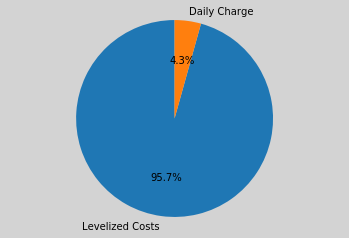

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[173.79394184323584, 121.20268091695759, 172.3810102766104, 30.10115234303109, 12.69492938065386, 13.53816540839529, 0.4854608547223059, 0.46941837192278796, 0.6488869826469732, 3074.37, 296.1386, 274.446, 0.0, 21.6926, {'Levelized Costs': 2941.3179999999998, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60192147352, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (224.1710357708881, 174.32720756465366, 247.16110167230747, 39.11115258436179, 30.355881606514643, 9.842296605304284, 0.8020630926989492, 0.6254491242256299, 0.7489313406140495)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 39.1
                                           and a gcr of 0.802


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6703121662139893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 30.4
                                           and a gcr of 0.625


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3845810890197754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 247
                                           a tilt of 9.8
                                           and a gcr of 0.749


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.117487192153931 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 188 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 300.851, 0.0]


ERROR:ga_logger:Cost: 3121.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,121 per year


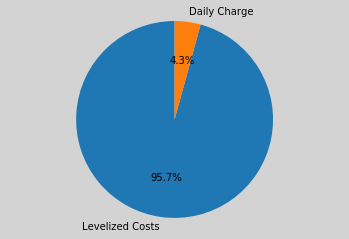

Total roof area of the  building: 599 m2
Total roof area used 481 m2
Percentage: 80.3%
succes
[[224.1710357708881, 174.32720756465366, 247.16110167230747, 39.11115258436179, 30.355881606514643, 9.842296605304284, 0.8020630926989492, 0.6254491242256299, 0.7489313406140495, 3121.17, 300.851, 0.0, 300.851, 0.0, {'Levelized Costs': 2988.1130000000003, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601496599826, 61845.7, 481.016]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (104.15384652778512, 130.09793748064453, 139.3242322176053, 30.789264860425572, 19.03361320167664, 4.798097442094173, 0.4527084182874639, 0.20778024930612166, 0.2793724459074169)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 104
                                           a tilt of 30.8
                                           and a gcr of 0.453


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7091591358184814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 19.0
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6782784461975098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 4.8
                                           and a gcr of 0.279


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.68117356300354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [271.064, 0.0, 0.0]


ERROR:ga_logger:Cost: 4476.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0267 /kWh
Total Cost of the system: $ 4,476 per year


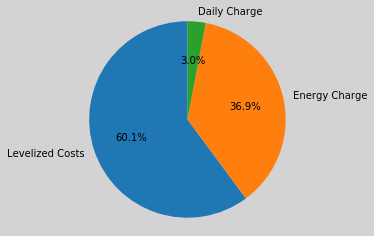

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[104.15384652778512, 130.09793748064453, 139.3242322176053, 30.789264860425572, 19.03361320167664, 4.798097442094173, 0.4527084182874639, 0.20778024930612166, 0.2793724459074169, 4476.02, 271.064, 271.064, 0.0, 0.0, {'Levelized Costs': 2692.2720000000004, 'Energy Charge': 1650.7060000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 48671.681313299894, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230.10266766341752, 227.67057195355932, 181.47738283225868, 20.403945090137015, 53.6583163393885, 43.139330103437665, 0.8242405316954411, 0.35271975708383935, 0.7982027287364696)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 20.4
                                           and a gcr of 0.824


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.77799916267395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 228
                                           a tilt of 53.7
                                           and a gcr of 0.353


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5083329677581787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 43.1
                                           and a gcr of 0.798


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5527865886688232 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 215 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.74]


ERROR:ga_logger:Cost: 3288.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,289 per year


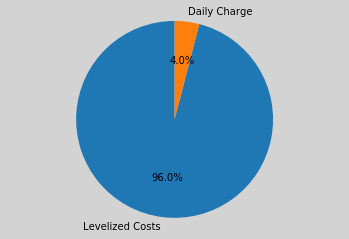

Total roof area of the  building: 599 m2
Total roof area used 398 m2
Percentage: 66.5%
succes
[[230.10266766341752, 227.67057195355932, 181.47738283225868, 20.403945090137015, 53.6583163393885, 43.139330103437665, 0.8242405316954411, 0.35271975708383935, 0.7982027287364696, 3288.92, 317.74, 0.0, 0.0, 317.74, {'Levelized Costs': 3155.8579999999997, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6016943338, 61845.7, 398.07]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (119.67994037513006, 148.12380837170477, 171.8252237884858, 4.90025828402149, 2.583959446891541, 19.380288106132177, 0.8198030192567762, 0.32626504529964645, 0.7461683119584557)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 4.9
                                           and a gcr of 0.820


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6853418350219727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 148
                                           a tilt of 2.6
                                           and a gcr of 0.326


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3523201942443848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 19.4
                                           and a gcr of 0.746


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.437368869781494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 308.392]


ERROR:ga_logger:Cost: 3196.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,196 per year


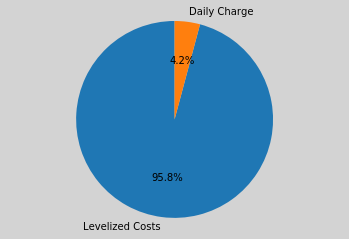

Total roof area of the  building: 599 m2
Total roof area used 413 m2
Percentage: 69.0%
succes
[[119.67994037513006, 148.12380837170477, 171.8252237884858, 4.90025828402149, 2.583959446891541, 19.380288106132177, 0.8198030192567762, 0.32626504529964645, 0.7461683119584557, 3196.07, 308.392, 0.0, 0.0, 308.392, {'Levelized Costs': 3063.0119999999997, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600935735296, 61845.7, 413.301]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (153.30540737217905, 220.30944736076407, 247.51151608609698, 47.249681375698, 26.34404718698672, 14.553960716501514, 0.46577292307170187, 0.5493419007185666, 0.8628678978820632)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 153
                                           a tilt of 47.2
                                           and a gcr of 0.466


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.744070053100586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 26.3
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6585981845855713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 14.6
                                           and a gcr of 0.863


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.053843259811401 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [0.0, 312.731, 0.0]


ERROR:ga_logger:Cost: 3239.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,239 per year


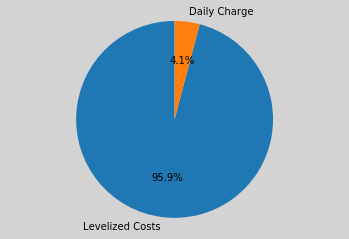

Total roof area of the  building: 599 m2
Total roof area used 569 m2
Percentage: 95.1%
succes
[[153.30540737217905, 220.30944736076407, 247.51151608609698, 47.249681375698, 26.34404718698672, 14.553960716501514, 0.46577292307170187, 0.5493419007185666, 0.8628678978820632, 3239.17, 312.731, 0.0, 312.731, 0.0, {'Levelized Costs': 3106.1119999999996, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6036117495, 61845.7, 569.284]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.2828557765148, 181.72508834880117, 197.00854868487252, 4.375549888693313, 26.070937651449558, 4.4179413424047045, 0.44043182198380637, 0.5843634155901177, 0.3292426928762532)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 4.4
                                           and a gcr of 0.440


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.76652193069458 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 26.1
                                           and a gcr of 0.584


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.701010227203369 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 4.4
                                           and a gcr of 0.329


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.050781488418579 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 201 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 124s


ERROR:ga_logger:panel relevance: [0.0, 297.354, 0.0]


ERROR:ga_logger:Cost: 3086.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,086 per year


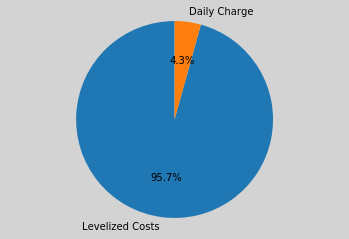

Total roof area of the  building: 599 m2
Total roof area used 509 m2
Percentage: 85.0%
succes
[[134.2828557765148, 181.72508834880117, 197.00854868487252, 4.375549888693313, 26.070937651449558, 4.4179413424047045, 0.44043182198380637, 0.5843634155901177, 0.3292426928762532, 3086.43, 297.354, 0.0, 297.354, 0.0, {'Levelized Costs': 2953.3759999999997, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599839124836, 61845.7, 508.851]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225.35999663002582, 142.59877544454704, 164.1428589192954, 37.69852963685263, 53.811844764075325, 26.634813455041602, 0.8264310119800239, 0.6718854090401308, 0.827251266442149)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 37.7
                                           and a gcr of 0.826


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.653353691101074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 143
                                           a tilt of 53.8
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4216396808624268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 26.6
                                           and a gcr of 0.827


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4031662940979004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 190 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.205]


ERROR:ga_logger:Cost: 3283.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,284 per year


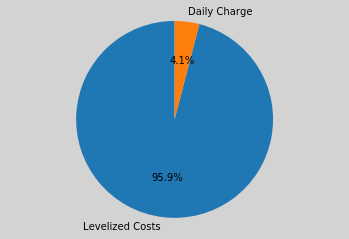

Total roof area of the  building: 599 m2
Total roof area used 383 m2
Percentage: 64.0%
succes
[[225.35999663002582, 142.59877544454704, 164.1428589192954, 37.69852963685263, 53.811844764075325, 26.634813455041602, 0.8264310119800239, 0.6718854090401308, 0.827251266442149, 3283.6, 317.205, 0.0, 0.0, 317.205, {'Levelized Costs': 3150.5519999999997, 'Energy Charge': 0.006000000000312866, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60170471743, 61845.7, 383.445]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.1176988370023, 142.4947093958282, 95.74598657331941, 24.930036360356016, 18.020128733957172, 27.716883973210294, 0.5247029247052523, 0.3473290515265259, 0.22066153427409657)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 24.9
                                           and a gcr of 0.525


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6336350440979004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 142
                                           a tilt of 18.0
                                           and a gcr of 0.347


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8888070583343506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 27.7
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6857683658599854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [314.172, 0.0, 0.0]


ERROR:ga_logger:Cost: 3271.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0003 /kWh
Total Cost of the system: $ 3,271 per year


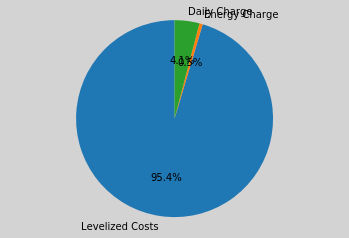

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.1176988370023, 142.4947093958282, 95.74598657331941, 24.930036360356016, 18.020128733957172, 27.716883973210294, 0.5247029247052523, 0.3473290515265259, 0.22066153427409657, 3271.38, 314.172, 314.172, 0.0, 0.0, {'Levelized Costs': 3120.423, 'Energy Charge': 17.915000000000305, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61702.68486066998, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.75330514828883, 251.48312618358634, 210.5125928512506, 34.149419158220525, 13.195978945693058, 47.435779359654255, 0.8828974911630354, 0.7717499277379161, 0.847861497616986)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 34.1
                                           and a gcr of 0.883


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.601386070251465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 251
                                           a tilt of 13.2
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5812249183654785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 47.4
                                           and a gcr of 0.848


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6139347553253174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 132s


ERROR:ga_logger:panel relevance: [323.04, 0.0, 0.0]


ERROR:ga_logger:Cost: 3341.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,342 per year


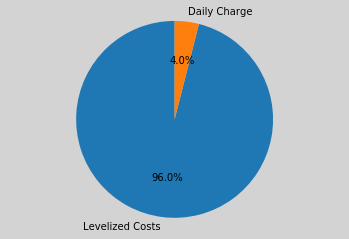

Total roof area of the  building: 599 m2
Total roof area used 366 m2
Percentage: 61.1%
succes
[[172.75330514828883, 251.48312618358634, 210.5125928512506, 34.149419158220525, 13.195978945693058, 47.435779359654255, 0.8828974911630354, 0.7717499277379161, 0.847861497616986, 3341.56, 323.04, 323.04, 0.0, 0.0, {'Levelized Costs': 3208.497, 'Energy Charge': 0.020999999999958163, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602247268, 61845.7, 365.887]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (122.47682287294627, 98.97669863591283, 98.47370645975222, 11.61409583771042, 3.890544526226049, 14.264693343130345, 0.3594007974691624, 0.5777465918745694, 0.7695108437715001)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 122
                                           a tilt of 11.6
                                           and a gcr of 0.359


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3530325889587402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 3.9
                                           and a gcr of 0.578


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4145667552948 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 14.3
                                           and a gcr of 0.770


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6235344409942627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [21.9967, 310.572, 0.0]


ERROR:ga_logger:Cost: 3436.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,436 per year


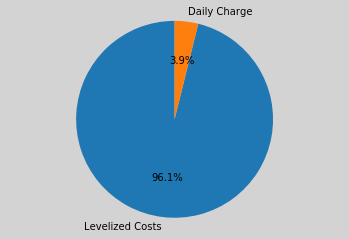

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[122.47682287294627, 98.97669863591283, 98.47370645975222, 11.61409583771042, 3.890544526226049, 14.264693343130345, 0.3594007974691624, 0.5777465918745694, 0.7695108437715001, 3436.2, 332.5687, 21.9967, 310.572, 0.0, {'Levelized Costs': 3303.145, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600236948, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (229.81867909995984, 175.02344898954883, 177.2188826562279, 30.885529946264345, 8.613382670233246, 26.57567812220115, 0.5964977934536353, 0.8926328650661577, 0.5335394163305481)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 30.9
                                           and a gcr of 0.596


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8234474658966064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 8.6
                                           and a gcr of 0.893


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.014462471008301 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 26.6
                                           and a gcr of 0.534


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 10.457533359527588 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 897 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 436s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.873]


ERROR:ga_logger:Cost: 3081.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,082 per year


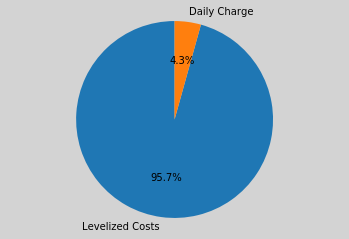

Total roof area of the  building: 599 m2
Total roof area used 556 m2
Percentage: 92.9%
succes
[[229.81867909995984, 175.02344898954883, 177.2188826562279, 30.885529946264345, 8.613382670233246, 26.57567812220115, 0.5964977934536353, 0.8926328650661577, 0.5335394163305481, 3081.66, 296.873, 0.0, 0.0, 296.873, {'Levelized Costs': 2948.618, 'Energy Charge': 0.0, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601615720756, 61845.7, 556.422]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (209.773328536747, 161.4111908003252, 96.94756660141346, 17.529117525174733, 15.856889555078357, 2.385138614120521, 0.4066570789033358, 0.6068146976314517, 0.22413215719182422)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 17.5
                                           and a gcr of 0.407


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.147720575332642 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 15.9
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.128042221069336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 97
                                           a tilt of 2.4
                                           and a gcr of 0.224


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 11.715940475463867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  40 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 870 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 382s


ERROR:ga_logger:panel relevance: [0.0, 306.758, 0.0]


ERROR:ga_logger:Cost: 3179.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,180 per year


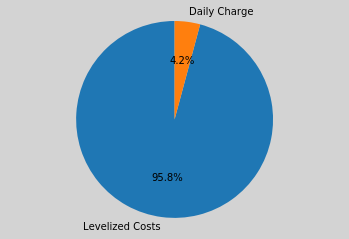

Total roof area of the  building: 599 m2
Total roof area used 506 m2
Percentage: 84.4%
succes
[[209.773328536747, 161.4111908003252, 96.94756660141346, 17.529117525174733, 15.856889555078357, 2.385138614120521, 0.4066570789033358, 0.6068146976314517, 0.22413215719182422, 3179.84, 306.758, 0.0, 306.758, 0.0, {'Levelized Costs': 3046.78, 'Energy Charge': 0.01799999999997226, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59903520003, 61845.7, 505.522]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.5762248687131, 195.80481789478173, 255.63859974868802, 37.91888215171789, 21.454288004349774, 11.131465081164382, 0.8690526244414304, 0.5636525129177358, 0.6137063110410764)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 37.9
                                           and a gcr of 0.869


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.127838373184204 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 196
                                           a tilt of 21.5
                                           and a gcr of 0.564


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.560454368591309 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 256
                                           a tilt of 11.1
                                           and a gcr of 0.614


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.133726119995117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  48 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 899 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 481s


ERROR:ga_logger:panel relevance: [0.0, 301.736, 0.0]


ERROR:ga_logger:Cost: 3129.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,130 per year


Total roof area of the  building: 599 m2
Total roof area used 535 m2
Percentage: 89.4%
succes
[[135.5762248687131, 195.80481789478173, 255.63859974868802, 37.91888215171789, 21.454288004349774, 11.131465081164382, 0.8690526244414304, 0.5636525129177358, 0.6137063110410764, 3129.96, 301.736, 0.0, 301.736, 0.0, {'Levelized Costs': 2996.906, 'Energy Charge': 0.012000000000227828, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601806267725, 61845.7, 535.323]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.87402297993445, 109.25152029690076, 211.41334660831035, 30.567162649630905, 14.063447296998595, 50.16390774657058, 0.45474363144531, 0.5233949200337152, 0.5689732475782178)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 30.6
                                           and a gcr of 0.455


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.199969291687012 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 109
                                           a tilt of 14.1
                                           and a gcr of 0.523


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.324586868286133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 50.2
                                           and a gcr of 0.569


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 16.794473886489868 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  49 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 914 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 414s


ERROR:ga_logger:panel relevance: [0.0, 130.259, 199.077]


ERROR:ga_logger:Cost: 3404.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,404 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[120.87402297993445, 109.25152029690076, 211.41334660831035, 30.567162649630905, 14.063447296998595, 50.16390774657058, 0.45474363144531, 0.5233949200337152, 0.5689732475782178, 3404.09, 329.336, 0.0, 130.259, 199.077, {'Levelized Costs': 3271.034, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60170910006, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (219.1770996507652, 256.766482638181, 179.37379276210618, 45.53452772661074, 50.67102095355979, 23.234183288730712, 0.6323884364764941, 0.7127308567674169, 0.7827931245724024)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 219
                                           a tilt of 45.5
                                           and a gcr of 0.632


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.010982275009155 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 50.7
                                           and a gcr of 0.713


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.782202243804932 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 23.2
                                           and a gcr of 0.783


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.644383907318115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  45 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 922 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 460s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.054]


ERROR:ga_logger:Cost: 3202.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,203 per year


Total roof area of the  building: 599 m2
Total roof area used 395 m2
Percentage: 65.9%
succes
[[219.1770996507652, 256.766482638181, 179.37379276210618, 45.53452772661074, 50.67102095355979, 23.234183288730712, 0.6323884364764941, 0.7127308567674169, 0.7827931245724024, 3202.64, 309.054, 0.0, 0.0, 309.054, {'Levelized Costs': 3069.5829999999996, 'Energy Charge': 0.015000000000270575, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601439761194, 61845.7, 394.809]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (151.10789579058908, 150.73743501536046, 134.2384534059405, 20.052868176599837, 38.670022944201826, 2.101901955119006, 0.528169890427303, 0.6799646161792428, 0.4329463486985257)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 20.1
                                           and a gcr of 0.528


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.046638488769531 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 151
                                           a tilt of 38.7
                                           and a gcr of 0.680


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.137396812438965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 134
                                           a tilt of 2.1
                                           and a gcr of 0.433


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.661860942840576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  45 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 1012 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 392s


ERROR:ga_logger:panel relevance: [304.729, 0.0, 0.0]


ERROR:ga_logger:Cost: 3159.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,160 per year


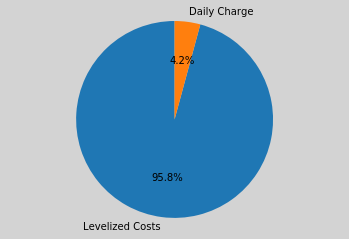

Total roof area of the  building: 599 m2
Total roof area used 577 m2
Percentage: 96.4%
succes
[[151.10789579058908, 150.73743501536046, 134.2384534059405, 20.052868176599837, 38.670022944201826, 2.101901955119006, 0.528169890427303, 0.6799646161792428, 0.4329463486985257, 3159.69, 304.729, 304.729, 0.0, 0.0, {'Levelized Costs': 3026.6319999999996, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60151528994, 61845.7, 576.952]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (227.11907888735217, 237.28095921701183, 240.78081826404696, 49.190000641152, 23.57017934480034, 24.806324345620425, 0.5540848318998521, 0.6087383845151946, 0.7325449986874342)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 227
                                           a tilt of 49.2
                                           and a gcr of 0.554


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.943260908126831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 23.6
                                           and a gcr of 0.609


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.612489223480225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 24.8
                                           and a gcr of 0.733


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.048936605453491 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  47 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 673 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 328.268, 0.0]


ERROR:ga_logger:Cost: 3393.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,393 per year


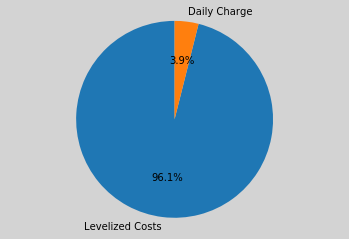

Total roof area of the  building: 599 m2
Total roof area used 539 m2
Percentage: 90.1%
succes
[[227.11907888735217, 237.28095921701183, 240.78081826404696, 49.190000641152, 23.57017934480034, 24.806324345620425, 0.5540848318998521, 0.6087383845151946, 0.7325449986874342, 3393.48, 328.268, 0.0, 328.268, 0.0, {'Levelized Costs': 3260.43, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60079299918, 61845.7, 539.259]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90.34978044403674, 188.44922450799157, 209.77522805251922, 37.163357957600056, 13.604936094049068, 18.92997509765293, 0.4919215752456001, 0.5794575839386653, 0.5017883030614162)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 37.2
                                           and a gcr of 0.492


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.492377281188965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 13.6
                                           and a gcr of 0.579


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.884410381317139 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 18.9
                                           and a gcr of 0.502


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.365087509155273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  36 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 966 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 472s


ERROR:ga_logger:panel relevance: [0.0, 49.0007, 258.019]


ERROR:ga_logger:Cost: 3182.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,182 per year


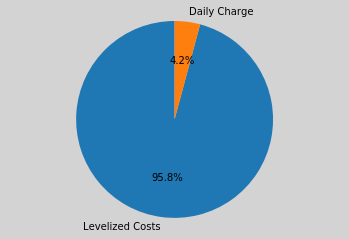

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[90.34978044403674, 188.44922450799157, 209.77522805251922, 37.163357957600056, 13.604936094049068, 18.92997509765293, 0.4919215752456001, 0.5794575839386653, 0.5017883030614162, 3182.44, 307.0197, 0.0, 49.0007, 258.019, {'Levelized Costs': 3049.38, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601215423434, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225.78669290918478, 147.29372434328775, 233.11746391980338, 30.906069068238793, 27.903932822417794, 22.895525533393958, 0.874217917619745, 0.3029681222774704, 0.6291829739734038)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 30.9
                                           and a gcr of 0.874


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.171971559524536 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 147
                                           a tilt of 27.9
                                           and a gcr of 0.303


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.450387477874756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 22.9
                                           and a gcr of 0.629


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 11.994861841201782 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  42 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 884 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 452s


ERROR:ga_logger:panel relevance: [0.0, 52.1713, 268.385]


ERROR:ga_logger:Cost: 3316.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,317 per year


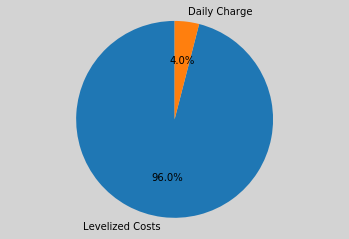

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[225.78669290918478, 147.29372434328775, 233.11746391980338, 30.906069068238793, 27.903932822417794, 22.895525533393958, 0.874217917619745, 0.3029681222774704, 0.6291829739734038, 3316.89, 320.55629999999996, 0.0, 52.1713, 268.385, {'Levelized Costs': 3183.835, 'Energy Charge': 0.012999999999863121, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601702485554, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (211.267971127718, 112.33714922250492, 139.479986293786, 31.067979301666412, 1.9668454584578203, 1.408999654383038, 0.5030267394368169, 0.7079341781727646, 0.2369179229836966)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 211
                                           a tilt of 31.1
                                           and a gcr of 0.503


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5249507427215576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 2.0
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2813076972961426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 1.4
                                           and a gcr of 0.237


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.28019118309021 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 538s


ERROR:ga_logger:panel relevance: [284.595, 23.3591, 0.0]


ERROR:ga_logger:Cost: 3191.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,192 per year


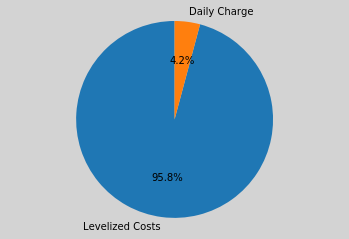

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[211.267971127718, 112.33714922250492, 139.479986293786, 31.067979301666412, 1.9668454584578203, 1.408999654383038, 0.5030267394368169, 0.7079341781727646, 0.2369179229836966, 3191.72, 307.95410000000004, 284.595, 23.3591, 0.0, {'Levelized Costs': 3058.658, 'Energy Charge': 0.02000000000015234, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60187830101, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (264.0896632054747, 165.50569480080597, 192.36502807475108, 32.45875621138248, 16.825942626154117, 46.956405236507315, 0.6177617015541904, 0.6067741632278821, 0.6065039646279067)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 32.5
                                           and a gcr of 0.618


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.6809983253479 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 16.8
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.371171474456787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 47.0
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.717468976974487 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  43 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 957 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 441s


ERROR:ga_logger:panel relevance: [0.0, 305.257, 0.0]


ERROR:ga_logger:Cost: 3164.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,165 per year


Total roof area of the  building: 599 m2
Total roof area used 503 m2
Percentage: 84.0%
succes
[[264.0896632054747, 165.50569480080597, 192.36502807475108, 32.45875621138248, 16.825942626154117, 46.956405236507315, 0.6177617015541904, 0.6067741632278821, 0.6065039646279067, 3164.93, 305.257, 0.0, 305.257, 0.0, {'Levelized Costs': 3031.881, 'Energy Charge': 0.006999999999948159, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60024304307, 61845.7, 503.082]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235.74323805606048, 95.60594349378104, 104.6145552641973, 26.21507544602298, 3.791617767775316, 23.960495132796837, 0.3886277001373937, 0.5445131297566701, 0.24313754444278535)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 236
                                           a tilt of 26.2
                                           and a gcr of 0.389


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.958525896072388 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 3.8
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.317912578582764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 24.0
                                           and a gcr of 0.243


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.642311573028564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  43 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 928 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 423s


ERROR:ga_logger:panel relevance: [0.0, 326.034, 0.0]


ERROR:ga_logger:Cost: 3559.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0030 /kWh
Total Cost of the system: $ 3,559 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[235.74323805606048, 95.60594349378104, 104.6145552641973, 26.21507544602298, 3.791617767775316, 23.960495132796837, 0.3886277001373937, 0.5445131297566701, 0.24313754444278535, 3559.08, 326.034, 0.0, 326.034, 0.0, {'Levelized Costs': 3238.2400000000002, 'Energy Charge': 187.7979999999999, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60346.884438679976, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (238.71767330599943, 241.14155854395685, 264.5891029906319, 11.803431296611063, 37.86374266600137, 28.308920914409732, 0.8246330304135242, 0.4524797259931722, 0.799985528702513)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 239
                                           a tilt of 11.8
                                           and a gcr of 0.825


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.296610832214355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 241
                                           a tilt of 37.9
                                           and a gcr of 0.452


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.287929773330688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 28.3
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.719360589981079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  46 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 1025 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 534s


ERROR:ga_logger:panel relevance: [333.583, 0.0, 0.0]


ERROR:ga_logger:Cost: 3446.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,446 per year


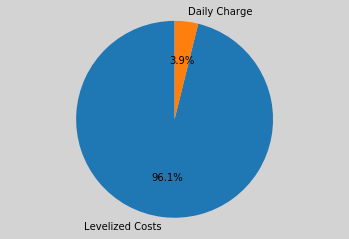

Total roof area of the  building: 599 m2
Total roof area used 405 m2
Percentage: 67.6%
succes
[[238.71767330599943, 241.14155854395685, 264.5891029906319, 11.803431296611063, 37.86374266600137, 28.308920914409732, 0.8246330304135242, 0.4524797259931722, 0.799985528702513, 3446.27, 333.583, 333.583, 0.0, 0.0, {'Levelized Costs': 3313.2049999999995, 'Energy Charge': 0.023000000000365617, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599579669724, 61845.7, 404.523]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (204.65783103615814, 133.2903977185881, 200.13146054721082, 5.005208321177743, 15.941806111999746, 24.010639893512742, 0.562020319619272, 0.2832234896566411, 0.2529031625684643)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 5.0
                                           and a gcr of 0.562


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.076269149780273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 15.9
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.334717512130737 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 24.0
                                           and a gcr of 0.253


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 15.808066844940186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  48 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 743 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [312.632, 0.0, 10.7475]


ERROR:ga_logger:Cost: 3344.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,345 per year


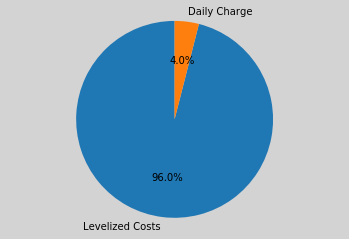

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[204.65783103615814, 133.2903977185881, 200.13146054721082, 5.005208321177743, 15.941806111999746, 24.010639893512742, 0.562020319619272, 0.2832234896566411, 0.2529031625684643, 3344.93, 323.3795, 312.632, 0.0, 10.7475, {'Levelized Costs': 3211.868, 'Energy Charge': 0.01999999999998181, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60185752907, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (103.22694548257863, 261.88735386205667, 191.28078769124073, 41.863128718834076, 34.94868988459369, 54.25128262723635, 0.7457977773978051, 0.27669943634451655, 0.5201091585102551)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 41.9
                                           and a gcr of 0.746


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8754472732543945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 34.9
                                           and a gcr of 0.277


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4682576656341553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 54.3
                                           and a gcr of 0.520


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.640482187271118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.421]


ERROR:ga_logger:Cost: 3404.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0029 /kWh
Total Cost of the system: $ 3,404 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[103.22694548257863, 261.88735386205667, 191.28078769124073, 41.863128718834076, 34.94868988459369, 54.25128262723635, 0.7457977773978051, 0.27669943634451655, 0.5201091585102551, 3404.08, 311.421, 0.0, 0.0, 311.421, {'Levelized Costs': 3093.1, 'Energy Charge': 177.93800000000022, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60425.61425134125, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (117.18538427853579, 237.27489915130883, 172.70644788153177, 11.211266057440952, 28.414767763993552, 12.317872578264625, 0.4072479014566142, 0.2696893768949327, 0.6196723256032823)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 11.2
                                           and a gcr of 0.407


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6087162494659424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 28.4
                                           and a gcr of 0.270


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4841456413269043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 12.3
                                           and a gcr of 0.620


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4684982299804688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.619]


ERROR:ga_logger:Cost: 3208.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,208 per year


Total roof area of the  building: 599 m2
Total roof area used 500 m2
Percentage: 83.4%
succes
[[117.18538427853579, 237.27489915130883, 172.70644788153177, 11.211266057440952, 28.414767763993552, 12.317872578264625, 0.4072479014566142, 0.2696893768949327, 0.6196723256032823, 3208.26, 309.619, 0.0, 0.0, 309.619, {'Levelized Costs': 3075.195, 'Energy Charge': 0.022999999999967713, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60373775256, 61845.7, 499.65]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.95042891643755, 179.2584652397232, 264.6099476755339, 21.476761786964012, 46.43452576489329, 43.44901691843871, 0.7457032788911042, 0.7243562977475183, 0.6224169113460466)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 127
                                           a tilt of 21.5
                                           and a gcr of 0.746


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5424880981445312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 46.4
                                           and a gcr of 0.724


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4369900226593018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 43.4
                                           and a gcr of 0.622


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.48653507232666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 183 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [0.0, 318.342, 0.0]


ERROR:ga_logger:Cost: 3294.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,295 per year


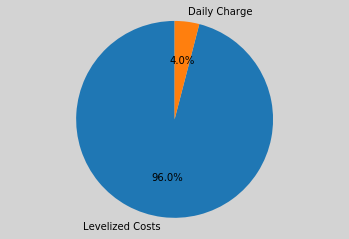

Total roof area of the  building: 599 m2
Total roof area used 439 m2
Percentage: 73.4%
succes
[[126.95042891643755, 179.2584652397232, 264.6099476755339, 21.476761786964012, 46.43452576489329, 43.44901691843871, 0.7457032788911042, 0.7243562977475183, 0.6224169113460466, 3294.89, 318.342, 0.0, 318.342, 0.0, {'Levelized Costs': 3161.831, 'Energy Charge': 0.016999999999825377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6025205001, 61845.7, 439.482]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105.28758880900688, 134.88704654300167, 114.58820665886265, 11.063585367636714, 46.11223621958573, 8.954275541956257, 0.24085677019289353, 0.6996161808925373, 0.7750263119966248)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 11.1
                                           and a gcr of 0.241


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6378674507141113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 46.1
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6266233921051025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 9.0
                                           and a gcr of 0.775


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6858315467834473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [60.4706, 0.0, 269.474]


ERROR:ga_logger:Cost: 3410.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,410 per year


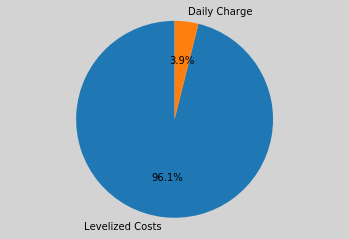

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[105.28758880900688, 134.88704654300167, 114.58820665886265, 11.063585367636714, 46.11223621958573, 8.954275541956257, 0.24085677019289353, 0.6996161808925373, 0.7750263119966248, 3410.14, 329.9446, 60.4706, 0.0, 269.474, {'Levelized Costs': 3277.084, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59946896005, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.7052722133205, 188.59351165560298, 246.6235009777354, 28.537213883940332, 54.83190493962789, 25.059502762269545, 0.8292123368968521, 0.6446659685481361, 0.8449655967372406)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 28.5
                                           and a gcr of 0.829


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.675029993057251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 54.8
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6482057571411133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 247
                                           a tilt of 25.1
                                           and a gcr of 0.845


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.728630542755127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 127s


ERROR:ga_logger:panel relevance: [0.0, 326.568, 0.0]


ERROR:ga_logger:Cost: 3376.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,377 per year


Total roof area of the  building: 599 m2
Total roof area used 507 m2
Percentage: 84.6%
succes
[[136.7052722133205, 188.59351165560298, 246.6235009777354, 28.537213883940332, 54.83190493962789, 25.059502762269545, 0.8292123368968521, 0.6446659685481361, 0.8449655967372406, 3376.6, 326.568, 0.0, 326.568, 0.0, {'Levelized Costs': 3243.5429999999997, 'Energy Charge': 0.015000000000384262, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60172950203, 61845.7, 506.569]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.34230306565692, 144.27801721135646, 163.31261256578208, 23.59171341295657, 12.370770026047428, 19.422781599154202, 0.5667561534704038, 0.3733031108294004, 0.8000029751824665)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 23.6
                                           and a gcr of 0.567


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.61417555809021 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 12.4
                                           and a gcr of 0.373


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.500791072845459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 163
                                           a tilt of 19.4
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.200809478759766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 145.463, 167.278]


ERROR:ga_logger:Cost: 3239.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,239 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[134.34230306565692, 144.27801721135646, 163.31261256578208, 23.59171341295657, 12.370770026047428, 19.422781599154202, 0.5667561534704038, 0.3733031108294004, 0.8000029751824665, 3239.26, 312.741, 0.0, 145.463, 167.278, {'Levelized Costs': 3106.1990000000005, 'Energy Charge': 0.018999999999834927, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60144880931, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230.33566384555803, 219.12100188569337, 259.4677044290194, 32.589459655141404, 54.712400591463705, 23.526982683606818, 0.744456784024258, 0.5730339959447179, 0.664498344439548)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 32.6
                                           and a gcr of 0.744


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.587219476699829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 54.7
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.497413396835327 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 23.5
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5089573860168457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 141s


ERROR:ga_logger:panel relevance: [342.64, 0.0, 0.0]


ERROR:ga_logger:Cost: 3536.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,536 per year


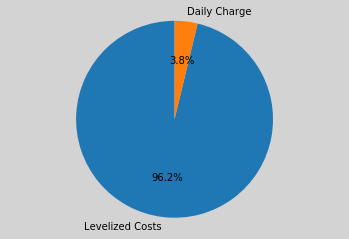

Total roof area of the  building: 599 m2
Total roof area used 460 m2
Percentage: 76.9%
succes
[[230.33566384555803, 219.12100188569337, 259.4677044290194, 32.589459655141404, 54.712400591463705, 23.526982683606818, 0.744456784024258, 0.5730339959447179, 0.664498344439548, 3536.23, 342.64, 342.64, 0.0, 0.0, {'Levelized Costs': 3403.181, 'Energy Charge': 0.006999999999891315, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60299333205, 61845.7, 460.255]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (217.60165107682727, 105.18056981938165, 136.7308741777742, 30.912679684993293, 9.146703493175323, 22.895525533393958, 0.6047526052159968, 0.35433097305051525, 0.24384154374339098)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 218
                                           a tilt of 30.9
                                           and a gcr of 0.605


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8127987384796143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 9.1
                                           and a gcr of 0.354


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.578500986099243 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 22.9
                                           and a gcr of 0.244


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4823029041290283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [282.599, 0.0, 32.0564]


ERROR:ga_logger:Cost: 3258.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,258 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[217.60165107682727, 105.18056981938165, 136.7308741777742, 30.912679684993293, 9.146703493175323, 22.895525533393958, 0.6047526052159968, 0.35433097305051525, 0.24384154374339098, 3258.28, 314.6554, 282.599, 0.0, 32.0564, {'Levelized Costs': 3125.222, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60266158189, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230.33252114763835, 225.62324184066617, 235.26914487856868, 49.42476104862154, 18.465113556155277, 19.11207925914555, 0.8219973915780928, 0.6772277380914331, 0.2827717707212279)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 49.4
                                           and a gcr of 0.822


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.634737014770508 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 226
                                           a tilt of 18.5
                                           and a gcr of 0.677


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.627033233642578 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 19.1
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6061837673187256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 258.955, 61.188]


ERROR:ga_logger:Cost: 3312.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,313 per year


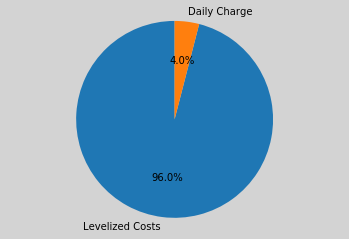

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[230.33252114763835, 225.62324184066617, 235.26914487856868, 49.42476104862154, 18.465113556155277, 19.11207925914555, 0.8219973915780928, 0.6772277380914331, 0.2827717707212279, 3312.78, 320.143, 0.0, 258.955, 61.188, {'Levelized Costs': 3179.717, 'Energy Charge': 0.021000000000299224, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599034127976, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.55606875143313, 169.6510170425302, 201.6869631035829, 32.60324076692122, 13.53452125334077, 3.461985004965018, 0.49703375372093495, 0.5518902239118064, 0.24781483420118866)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 32.6
                                           and a gcr of 0.497


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7065236568450928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 13.5
                                           and a gcr of 0.552


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6758296489715576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 3.5
                                           and a gcr of 0.248


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7427642345428467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 121s


ERROR:ga_logger:panel relevance: [0.0, 307.285, 0.0]


ERROR:ga_logger:Cost: 3185.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,185 per year


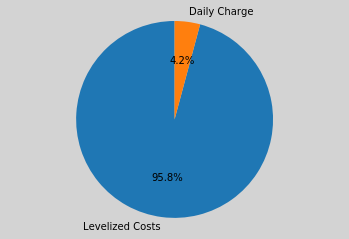

Total roof area of the  building: 599 m2
Total roof area used 557 m2
Percentage: 93.0%
succes
[[125.55606875143313, 169.6510170425302, 201.6869631035829, 32.60324076692122, 13.53452125334077, 3.461985004965018, 0.49703375372093495, 0.5518902239118064, 0.24781483420118866, 3185.07, 307.285, 0.0, 307.285, 0.0, {'Levelized Costs': 3052.0130000000004, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603306194935, 61845.7, 556.786]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (223.80166778408847, 222.20755271132072, 263.25224965239283, 38.410724809584764, 54.64036991124423, 29.430813344163873, 0.8794870637786179, 0.8779129965957082, 0.8426054529725845)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 38.4
                                           and a gcr of 0.879


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.46879243850708 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 222
                                           a tilt of 54.6
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4976842403411865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 29.4
                                           and a gcr of 0.843


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7980105876922607 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [360.735, 0.0, 0.0]


ERROR:ga_logger:Cost: 3715.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,716 per year


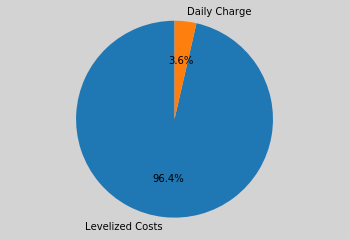

Total roof area of the  building: 599 m2
Total roof area used 410 m2
Percentage: 68.5%
succes
[[223.80166778408847, 222.20755271132072, 263.25224965239283, 38.410724809584764, 54.64036991124423, 29.430813344163873, 0.8794870637786179, 0.8779129965957082, 0.8426054529725845, 3715.95, 360.735, 360.735, 0.0, 0.0, {'Levelized Costs': 3582.884, 'Energy Charge': 0.024000000000057753, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60203989594, 61845.7, 410.165]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175.64804506262368, 111.52557284109409, 161.64875640271964, 32.91798142949032, 4.403467970152675, 25.41877238193938, 0.760343809385359, 0.6696271819469845, 0.25580176647701713)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 32.9
                                           and a gcr of 0.760


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.497934103012085 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 4.4
                                           and a gcr of 0.670


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.448880910873413 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 25.4
                                           and a gcr of 0.256


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4461851119995117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [230.293, 0.0, 75.6871]


ERROR:ga_logger:Cost: 3172.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,172 per year


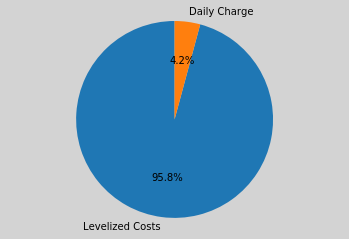

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[175.64804506262368, 111.52557284109409, 161.64875640271964, 32.91798142949032, 4.403467970152675, 25.41877238193938, 0.760343809385359, 0.6696271819469845, 0.25580176647701713, 3172.11, 305.9801, 230.293, 0.0, 75.6871, {'Levelized Costs': 3039.048, 'Energy Charge': 0.020000000000266027, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60180886459, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (224.3747952133917, 171.1248442639798, 262.3159224604915, 45.74834515741427, 36.514414021451515, 21.260668285238893, 0.7680488072383034, 0.537863817837777, 0.7328114893835609)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 45.7
                                           and a gcr of 0.768


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.584838628768921 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 36.5
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.393984794616699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 21.3
                                           and a gcr of 0.733


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.451430082321167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 299.51, 0.0]


ERROR:ga_logger:Cost: 3107.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,108 per year


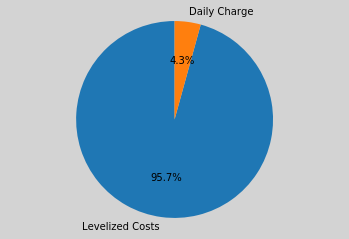

Total roof area of the  building: 599 m2
Total roof area used 557 m2
Percentage: 93.0%
succes
[[224.3747952133917, 171.1248442639798, 262.3159224604915, 45.74834515741427, 36.514414021451515, 21.260668285238893, 0.7680488072383034, 0.537863817837777, 0.7328114893835609, 3107.85, 299.51, 0.0, 299.51, 0.0, {'Levelized Costs': 2974.79, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60230982009, 61845.7, 556.851]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (197.83895225226553, 138.6774623053741, 166.9179046424532, 26.12998771317835, 30.6081177479345, 13.413129396358855, 0.8420877418132104, 0.4771862487423916, 0.39819233882433525)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 26.1
                                           and a gcr of 0.842


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6961734294891357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 139
                                           a tilt of 30.6
                                           and a gcr of 0.477


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4479615688323975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 13.4
                                           and a gcr of 0.398


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5462749004364014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [58.3116, 252.677, 0.0]


ERROR:ga_logger:Cost: 3221.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,222 per year


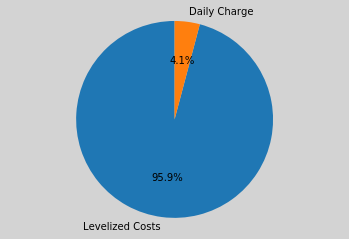

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[197.83895225226553, 138.6774623053741, 166.9179046424532, 26.12998771317835, 30.6081177479345, 13.413129396358855, 0.8420877418132104, 0.4771862487423916, 0.39819233882433525, 3221.86, 310.9886, 58.3116, 252.677, 0.0, {'Levelized Costs': 3088.799, 'Energy Charge': 0.019000000000346517, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600076086645, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (229.56656883924333, 209.85357943248314, 105.28894942166986, 34.71513033224417, 16.665421562303724, 41.60534095836299, 0.6290274744186641, 0.6008130910654458, 0.2803911678822243)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 34.7
                                           and a gcr of 0.629


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.600207567214966 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 16.7
                                           and a gcr of 0.601


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.813123941421509 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 41.6
                                           and a gcr of 0.280


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6849517822265625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [0.0, 310.357, 0.0]


ERROR:ga_logger:Cost: 3215.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,216 per year


Total roof area of the  building: 599 m2
Total roof area used 517 m2
Percentage: 86.3%
succes
[[229.56656883924333, 209.85357943248314, 105.28894942166986, 34.71513033224417, 16.665421562303724, 41.60534095836299, 0.6290274744186641, 0.6008130910654458, 0.2803911678822243, 3215.59, 310.357, 0.0, 310.357, 0.0, {'Levelized Costs': 3082.535, 'Energy Charge': 0.013000000000431555, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60175775624, 61845.7, 516.562]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.23342180663047, 153.57180124262712, 91.13500948289413, 20.185751259015827, 16.55271304222757, 22.660359506340324, 0.6240928406880588, 0.44748569815490846, 0.2317634214644565)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 20.2
                                           and a gcr of 0.624


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.244457483291626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 16.6
                                           and a gcr of 0.447


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3910748958587646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 22.7
                                           and a gcr of 0.232


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.437192916870117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [147.848, 161.928, 0.0]


ERROR:ga_logger:Cost: 3209.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,210 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.23342180663047, 153.57180124262712, 91.13500948289413, 20.185751259015827, 16.55271304222757, 22.660359506340324, 0.6240928406880588, 0.44748569815490846, 0.2317634214644565, 3209.81, 309.776, 147.848, 161.928, 0.0, {'Levelized Costs': 3076.7589999999996, 'Energy Charge': 0.009000000000298769, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602745060045, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (236.76288026723776, 192.71611474621102, 257.4891708857267, 38.76374357604993, 52.852627276799886, 15.489500090770004, 0.2804368393743141, 0.6543566487525446, 0.8223025831026516)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 237
                                           a tilt of 38.8
                                           and a gcr of 0.280


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8263843059539795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 193
                                           a tilt of 52.9
                                           and a gcr of 0.654


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.462449312210083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 15.5
                                           and a gcr of 0.822


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4704277515411377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 195 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [49.0174, 277.429, 0.0]


ERROR:ga_logger:Cost: 3375.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


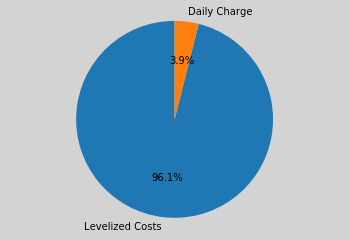

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[236.76288026723776, 192.71611474621102, 257.4891708857267, 38.76374357604993, 52.852627276799886, 15.489500090770004, 0.2804368393743141, 0.6543566487525446, 0.8223025831026516, 3375.39, 326.4464, 49.0174, 277.429, 0.0, {'Levelized Costs': 3242.336, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602338510755, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (137.7554866494162, 160.3404679059307, 113.19035603503359, 13.555681134795451, 30.971802735218326, 18.69649634782065, 0.20015973179738425, 0.6424149082566314, 0.21003798545253075)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 13.6
                                           and a gcr of 0.200


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.571601152420044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4628028869628906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 113
                                           a tilt of 18.7
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5171940326690674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 240 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 137s


ERROR:ga_logger:panel relevance: [0.0, 306.406, 0.0]


ERROR:ga_logger:Cost: 3176.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,176 per year


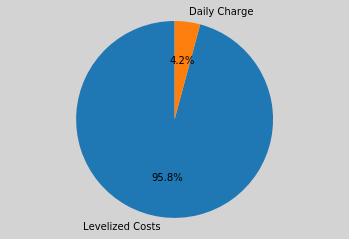

Total roof area of the  building: 599 m2
Total roof area used 477 m2
Percentage: 79.7%
succes
[[137.7554866494162, 160.3404679059307, 113.19035603503359, 13.555681134795451, 30.971802735218326, 18.69649634782065, 0.20015973179738425, 0.6424149082566314, 0.21003798545253075, 3176.34, 306.406, 0.0, 306.406, 0.0, {'Levelized Costs': 3043.28, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60056689992, 61845.7, 476.96]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (263.7287958316419, 214.8623691714383, 157.3057648893842, 43.23460956373509, 47.48073831660152, 46.315903506617815, 0.3889553606329223, 0.6473053750413547, 0.8810733992262032)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 43.2
                                           and a gcr of 0.389


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5212833881378174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 47.5
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.470041513442993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 46.3
                                           and a gcr of 0.881


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5049397945404053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 208 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 336.63, 0.0]


ERROR:ga_logger:Cost: 3476.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,477 per year


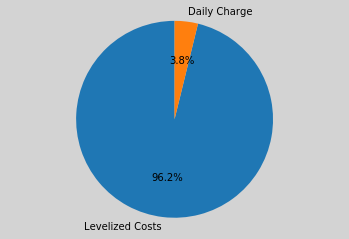

Total roof area of the  building: 599 m2
Total roof area used 520 m2
Percentage: 86.9%
succes
[[263.7287958316419, 214.8623691714383, 157.3057648893842, 43.23460956373509, 47.48073831660152, 46.315903506617815, 0.3889553606329223, 0.6473053750413547, 0.8810733992262032, 3476.53, 336.63, 0.0, 336.63, 0.0, {'Levelized Costs': 3343.474, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601326128875, 61845.7, 520.047]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.0628083935597, 196.92290395077143, 97.66927738369151, 14.046703340027413, 36.886662255609544, 15.21667095778395, 0.20115115549300966, 0.40715894912434736, 0.3236302505814992)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 14.0
                                           and a gcr of 0.201


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5332107543945312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 36.9
                                           and a gcr of 0.407


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.61293625831604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 15.2
                                           and a gcr of 0.324


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.580742597579956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 243.791, 0.0]


ERROR:ga_logger:Cost: 3942.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0224 /kWh
Total Cost of the system: $ 3,942 per year


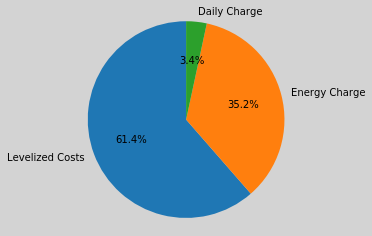

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[139.0628083935597, 196.92290395077143, 97.66927738369151, 14.046703340027413, 36.886662255609544, 15.21667095778395, 0.20115115549300966, 0.40715894912434736, 0.3236302505814992, 3942.02, 243.791, 0.0, 243.791, 0.0, {'Levelized Costs': 2421.3799999999997, 'Energy Charge': 1387.5980000000004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 50771.51610598192, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (248.81070529860403, 119.08058132823246, 195.10420640675193, 26.73514812043354, 9.459367890673263, 40.37227846272777, 0.4854608547223059, 0.5445626023769049, 0.6427822238000435)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 249
                                           a tilt of 26.7
                                           and a gcr of 0.485


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.691248893737793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 119
                                           a tilt of 9.5
                                           and a gcr of 0.545


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.627206325531006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 40.4
                                           and a gcr of 0.643


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.455472469329834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 185 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.954]


ERROR:ga_logger:Cost: 3211.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,212 per year


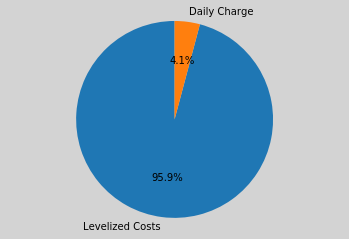

Total roof area of the  building: 599 m2
Total roof area used 482 m2
Percentage: 80.5%
succes
[[248.81070529860403, 119.08058132823246, 195.10420640675193, 26.73514812043354, 9.459367890673263, 40.37227846272777, 0.4854608547223059, 0.5445626023769049, 0.6427822238000435, 3211.58, 309.954, 0.0, 0.0, 309.954, {'Levelized Costs': 3078.527, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60192679943, 61845.7, 482.207]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (248.4772243877343, 110.5365770599157, 202.5568806880593, 29.225078922588214, 8.689964791130183, 39.77948279252103, 0.467466893116243, 0.4552002356130132, 0.5725601849955134)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 248
                                           a tilt of 29.2
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.512539863586426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 111
                                           a tilt of 8.7
                                           and a gcr of 0.455


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5423669815063477 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 39.8
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.507634162902832 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 199 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.57]


ERROR:ga_logger:Cost: 3207.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,208 per year


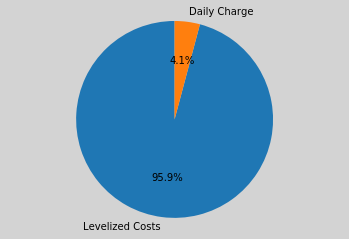

Total roof area of the  building: 599 m2
Total roof area used 541 m2
Percentage: 90.3%
succes
[[248.4772243877343, 110.5365770599157, 202.5568806880593, 29.225078922588214, 8.689964791130183, 39.77948279252103, 0.467466893116243, 0.4552002356130132, 0.5725601849955134, 3207.77, 309.57, 0.0, 0.0, 309.57, {'Levelized Costs': 3074.718, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60108821369, 61845.7, 540.677]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (153.7468368856707, 204.75988104609715, 119.64565497870767, 37.207719673035825, 1.4426135082304845, 38.17674827483877, 0.7390536489978243, 0.7245688331454396, 0.6445105678344919)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 37.2
                                           and a gcr of 0.739


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7684831619262695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 1.4
                                           and a gcr of 0.725


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5116305351257324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 38.2
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.67332124710083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [322.419, 0.0, 0.0]


ERROR:ga_logger:Cost: 3335.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,335 per year


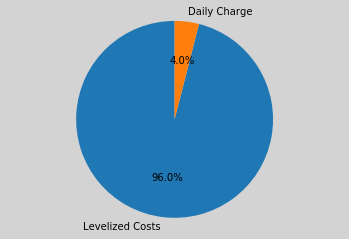

Total roof area of the  building: 599 m2
Total roof area used 436 m2
Percentage: 72.9%
succes
[[153.7468368856707, 204.75988104609715, 119.64565497870767, 37.207719673035825, 1.4426135082304845, 38.17674827483877, 0.7390536489978243, 0.7245688331454396, 0.6445105678344919, 3335.39, 322.419, 322.419, 0.0, 0.0, {'Levelized Costs': 3202.334, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601243402496, 61845.7, 436.26]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (156.9606095838866, 196.27362409345648, 113.87123255593636, 1.7561383115884484, 1.4611856143201054, 25.091976171306598, 0.40097032547308853, 0.3436650788054448, 0.3775927390538406)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 1.8
                                           and a gcr of 0.401


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4884707927703857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 196
                                           a tilt of 1.5
                                           and a gcr of 0.344


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4077887535095215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 114
                                           a tilt of 25.1
                                           and a gcr of 0.378


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5906593799591064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 226 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [240.086, 0.0, 0.0]


ERROR:ga_logger:Cost: 4650.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0345 /kWh
Total Cost of the system: $ 4,650 per year


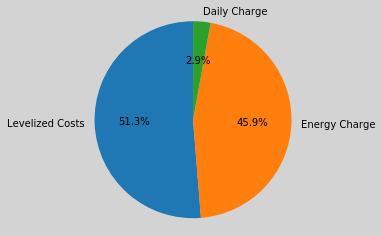

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[156.9606095838866, 196.27362409345648, 113.87123255593636, 1.7561383115884484, 1.4611856143201054, 25.091976171306598, 0.40097032547308853, 0.3436650788054448, 0.3775927390538406, 4650.05, 240.086, 240.086, 0.0, 0.0, {'Levelized Costs': 2384.5824999999995, 'Energy Charge': 2132.4255000000007, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 44827.159619127575, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230.00428690396427, 198.47160174969366, 202.8389251311389, 43.90647661037387, 37.13873153445054, 48.2508489047085, 0.6152209124357974, 0.5806191461730889, 0.7608196062507218)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 43.9
                                           and a gcr of 0.615


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.671027660369873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 37.1
                                           and a gcr of 0.581


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4774880409240723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 48.3
                                           and a gcr of 0.761


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.787879705429077 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 215 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 305.303, 0.0]


ERROR:ga_logger:Cost: 3165.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,165 per year


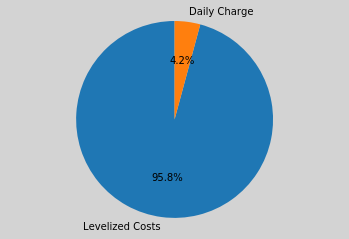

Total roof area of the  building: 599 m2
Total roof area used 526 m2
Percentage: 87.8%
succes
[[230.00428690396427, 198.47160174969366, 202.8389251311389, 43.90647661037387, 37.13873153445054, 48.2508489047085, 0.6152209124357974, 0.5806191461730889, 0.7608196062507218, 3165.38, 305.303, 0.0, 305.303, 0.0, {'Levelized Costs': 3032.328, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60253360266, 61845.7, 525.822]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.71364111393768, 172.68279063253541, 164.05613114475508, 13.922495008660398, 50.12582477266668, 34.125494952330385, 0.6106231824312432, 0.4453853154246042, 0.4414484847028176)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 13.9
                                           and a gcr of 0.611


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.600581169128418 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 50.1
                                           and a gcr of 0.445


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5170395374298096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 34.1
                                           and a gcr of 0.441


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.587660551071167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [142.417, 0.0, 161.362]


ERROR:ga_logger:Cost: 3150.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,150 per year


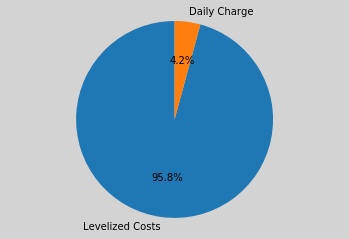

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.71364111393768, 172.68279063253541, 164.05613114475508, 13.922495008660398, 50.12582477266668, 34.125494952330385, 0.6106231824312432, 0.4453853154246042, 0.4414484847028176, 3150.26, 303.779, 142.417, 0.0, 161.362, {'Levelized Costs': 3017.2110000000002, 'Energy Charge': 0.0070000000001755325, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601368239935, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (264.67708489768427, 264.0825517755569, 197.06629838256993, 55.08223634527649, 36.23863055518437, 29.485624231878415, 0.7263842404570859, 0.8421758374725608, 0.8902980271737193)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 55.1
                                           and a gcr of 0.726


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5160555839538574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 36.2
                                           and a gcr of 0.842


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4737155437469482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 29.5
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4989545345306396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 324.937]


ERROR:ga_logger:Cost: 3360.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,360 per year


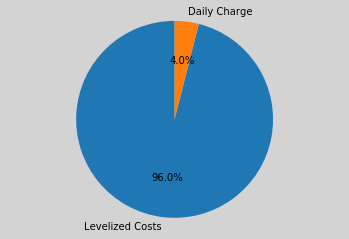

Total roof area of the  building: 599 m2
Total roof area used 365 m2
Percentage: 61.0%
succes
[[264.67708489768427, 264.0825517755569, 197.06629838256993, 55.08223634527649, 36.23863055518437, 29.485624231878415, 0.7263842404570859, 0.8421758374725608, 0.8902980271737193, 3360.4, 324.937, 0.0, 0.0, 324.937, {'Levelized Costs': 3227.3439999999996, 'Energy Charge': 0.014000000000464752, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60150571595, 61845.7, 364.976]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.83897993272117, 214.7337988158772, 173.046625287926, 49.26511590374583, 30.741564410475288, 13.961358840605364, 0.3804555010986737, 0.628582068446595, 0.2313195779273507)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 49.3
                                           and a gcr of 0.380


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9082119464874268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 30.7
                                           and a gcr of 0.629


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7668511867523193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 14.0
                                           and a gcr of 0.231


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.056529760360718 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 143s


ERROR:ga_logger:panel relevance: [0.0, 277.313, 36.4535]


ERROR:ga_logger:Cost: 3249.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,249 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[134.83897993272117, 214.7337988158772, 173.046625287926, 49.26511590374583, 30.741564410475288, 13.961358840605364, 0.3804555010986737, 0.628582068446595, 0.2313195779273507, 3249.45, 313.7665, 0.0, 277.313, 36.4535, {'Levelized Costs': 3116.3929999999996, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602627009925, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (142.30495360627737, 260.18875304789606, 207.3072166378404, 22.927261623892978, 50.67102095355979, 1.2644256553289315, 0.5258926655558795, 0.7322432179659689, 0.36067049183157335)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 22.9
                                           and a gcr of 0.526


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.526610851287842 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 50.7
                                           and a gcr of 0.732


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.516122579574585 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 207
                                           a tilt of 1.3
                                           and a gcr of 0.361


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.359143018722534 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 198 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [307.734, 0.0, 0.0]


ERROR:ga_logger:Cost: 3189.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,190 per year


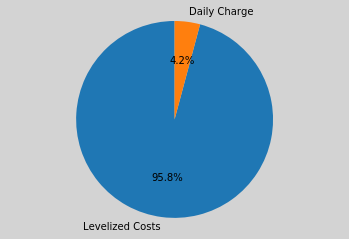

Total roof area of the  building: 599 m2
Total roof area used 585 m2
Percentage: 97.7%
succes
[[142.30495360627737, 260.18875304789606, 207.3072166378404, 22.927261623892978, 50.67102095355979, 1.2644256553289315, 0.5258926655558795, 0.7322432179659689, 0.36067049183157335, 3189.53, 307.734, 307.734, 0.0, 0.0, {'Levelized Costs': 3056.467, 'Energy Charge': 0.021000000000128694, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59980014981, 61845.7, 585.165]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (137.3287941577493, 260.18875304789606, 201.06416019084776, 20.32799453237936, 46.74941619162122, 5.599297900044673, 0.5207118319897212, 0.7133340523963886, 0.3112723907489856)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 20.3
                                           and a gcr of 0.521


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.465059518814087 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 46.7
                                           and a gcr of 0.713


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.865729808807373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 201
                                           a tilt of 5.6
                                           and a gcr of 0.311


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8312478065490723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 198 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [310.608, 0.0, 0.0]


ERROR:ga_logger:Cost: 3218.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,218 per year


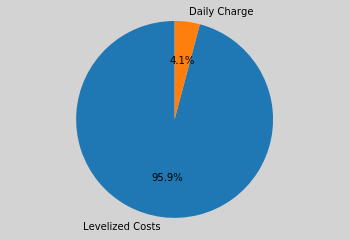

Total roof area of the  building: 599 m2
Total roof area used 597 m2
Percentage: 99.6%
succes
[[137.3287941577493, 260.18875304789606, 201.06416019084776, 20.32799453237936, 46.74941619162122, 5.599297900044673, 0.5207118319897212, 0.7133340523963886, 0.3112723907489856, 3218.07, 310.608, 310.608, 0.0, 0.0, {'Levelized Costs': 3085.0240000000003, 'Energy Charge': 0.0039999999999054126, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600153060164, 61845.7, 596.506]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (226.45950180500748, 195.9925219908094, 225.7588026366408, 20.08378587630786, 52.771202931973114, 24.1930203385567, 0.6621027914369458, 0.6953043377412549, 0.7529415581186054)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 20.1
                                           and a gcr of 0.662


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5214171409606934 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 196
                                           a tilt of 52.8
                                           and a gcr of 0.695


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.513644218444824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 24.2
                                           and a gcr of 0.753


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5081045627593994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [320.629, 0.0, 0.0]


ERROR:ga_logger:Cost: 3317.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,318 per year


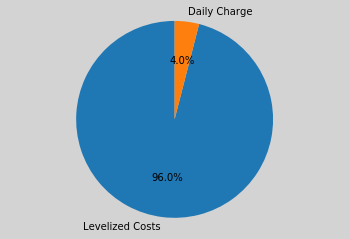

Total roof area of the  building: 599 m2
Total roof area used 484 m2
Percentage: 80.9%
succes
[[226.45950180500748, 195.9925219908094, 225.7588026366408, 20.08378587630786, 52.771202931973114, 24.1930203385567, 0.6621027914369458, 0.6953043377412549, 0.7529415581186054, 3317.61, 320.629, 320.629, 0.0, 0.0, {'Levelized Costs': 3184.546, 'Energy Charge': 0.02200000000016189, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60251193714, 61845.7, 484.258]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (203.94155224320662, 169.35497109670476, 102.3520270145685, 15.258759598534517, 24.91099524479904, 7.362058990088769, 0.3033982423763864, 0.556490150825114, 0.4155985859987603)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 15.3
                                           and a gcr of 0.303


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.7040793895721436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 24.9
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.535632848739624 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 7.4
                                           and a gcr of 0.416


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.518240213394165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 198 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 298.861, 0.0]


ERROR:ga_logger:Cost: 3101.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,101 per year


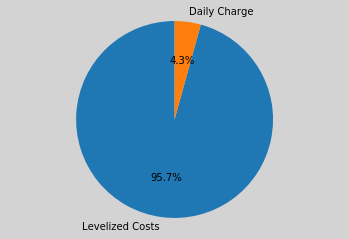

Total roof area of the  building: 599 m2
Total roof area used 537 m2
Percentage: 89.7%
succes
[[203.94155224320662, 169.35497109670476, 102.3520270145685, 15.258759598534517, 24.91099524479904, 7.362058990088769, 0.3033982423763864, 0.556490150825114, 0.4155985859987603, 3101.4, 298.861, 0.0, 298.861, 0.0, {'Levelized Costs': 2968.344, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60208143996, 61845.7, 537.046]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (247.38176279434398, 209.88812641442266, 187.9166752951188, 55.92246945352824, 50.42848451252803, 27.95852583927667, 0.6189484107143652, 0.6465742976831224, 0.5250082189056835)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 247
                                           a tilt of 55.9
                                           and a gcr of 0.619


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.916735887527466 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 50.4
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7313461303710938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 28.0
                                           and a gcr of 0.525


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7818641662597656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.451]


ERROR:ga_logger:Cost: 3077.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,077 per year


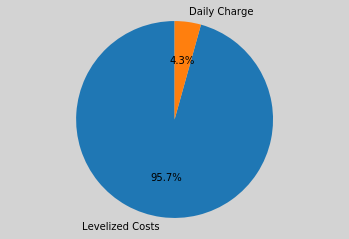

Total roof area of the  building: 599 m2
Total roof area used 565 m2
Percentage: 94.3%
succes
[[247.38176279434398, 209.88812641442266, 187.9166752951188, 55.92246945352824, 50.42848451252803, 27.95852583927667, 0.6189484107143652, 0.6465742976831224, 0.5250082189056835, 3077.47, 296.451, 0.0, 0.0, 296.451, {'Levelized Costs': 2944.4139999999998, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60187829865, 61845.7, 564.661]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (234.97329010884866, 198.78088921255852, 164.0281245456918, 8.777095363506248, 28.08813035684964, 13.52569003404365, 0.3513071189613872, 0.44120985006325164, 0.21800788459697718)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 8.8
                                           and a gcr of 0.351


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9779739379882812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 199
                                           a tilt of 28.1
                                           and a gcr of 0.441


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.477724075317383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 13.5
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4240121841430664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 264.18, 0.0]


ERROR:ga_logger:Cost: 3624.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0140 /kWh
Total Cost of the system: $ 3,624 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[234.97329010884866, 198.78088921255852, 164.0281245456918, 8.777095363506248, 28.08813035684964, 13.52569003404365, 0.3513071189613872, 0.44120985006325164, 0.21800788459697718, 3624.02, 264.18, 0.0, 264.18, 0.0, {'Levelized Costs': 2623.882, 'Energy Charge': 867.0959999999998, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 54925.56378402146, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (226.92038928123702, 232.42910434380363, 191.61978785725378, 51.17437381179368, 42.86556209600738, 45.80496160038713, 0.8242405316954411, 0.6388777511148162, 0.7853186160564296)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 227
                                           a tilt of 51.2
                                           and a gcr of 0.824


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7227251529693604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 232
                                           a tilt of 42.9
                                           and a gcr of 0.639


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8037326335906982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 45.8
                                           and a gcr of 0.785


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8030190467834473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 325.393]


ERROR:ga_logger:Cost: 3364.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,365 per year


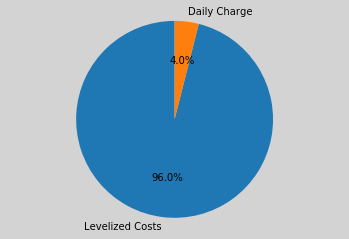

Total roof area of the  building: 599 m2
Total roof area used 414 m2
Percentage: 69.2%
succes
[[226.92038928123702, 232.42910434380363, 191.61978785725378, 51.17437381179368, 42.86556209600738, 45.80496160038713, 0.8242405316954411, 0.6388777511148162, 0.7853186160564296, 3364.92, 325.393, 0.0, 0.0, 325.393, {'Levelized Costs': 3231.8650000000002, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60076992665, 61845.7, 414.345]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190.18054404741548, 149.3253655745622, 95.46945502080482, 2.3955526461616836, 3.840992249146684, 39.2098374092765, 0.6268812130933444, 0.3554289726643193, 0.2717304916758859)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 2.4
                                           and a gcr of 0.627


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.526280641555786 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 3.8
                                           and a gcr of 0.355


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.413818359375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 39.2
                                           and a gcr of 0.272


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.612454652786255 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [268.114, 60.8023, 0.0]


ERROR:ga_logger:Cost: 3399.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,400 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[190.18054404741548, 149.3253655745622, 95.46945502080482, 2.3955526461616836, 3.840992249146684, 39.2098374092765, 0.6268812130933444, 0.3554289726643193, 0.2717304916758859, 3399.91, 328.9163, 268.114, 60.8023, 0.0, {'Levelized Costs': 3266.8509999999997, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599916712614, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (178.86630277270604, 170.54750509466814, 188.50210178289927, 41.99682292930539, 34.04229890928868, 42.42277587695074, 0.8952124110853933, 0.8898523246406397, 0.7607107547776968)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 42.0
                                           and a gcr of 0.895


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.581817626953125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 34.0
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4523916244506836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 42.4
                                           and a gcr of 0.761


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5132923126220703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.213]


ERROR:ga_logger:Cost: 3283.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,284 per year


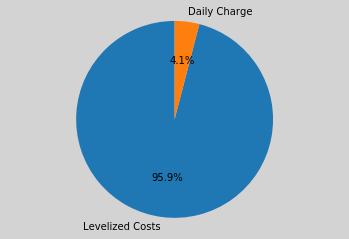

Total roof area of the  building: 599 m2
Total roof area used 417 m2
Percentage: 69.6%
succes
[[178.86630277270604, 170.54750509466814, 188.50210178289927, 41.99682292930539, 34.04229890928868, 42.42277587695074, 0.8952124110853933, 0.8898523246406397, 0.7607107547776968, 3283.68, 317.213, 0.0, 0.0, 317.213, {'Levelized Costs': 3150.6269999999995, 'Energy Charge': 0.011000000000535692, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60272016691, 61845.7, 416.995]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.45607545477186, 111.52557284109409, 154.00318645727222, 36.99864546760008, 2.789926827140521, 27.230263211117055, 0.8470362990296258, 0.5805851264239271, 0.8866775946974353)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 37.0
                                           and a gcr of 0.847


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.2920684814453125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 2.8
                                           and a gcr of 0.581


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5126278400421143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 27.2
                                           and a gcr of 0.887


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.616420030593872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 203 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 329.505]


ERROR:ga_logger:Cost: 3405.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,406 per year


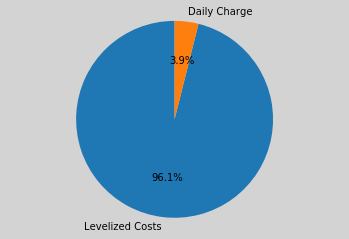

Total roof area of the  building: 599 m2
Total roof area used 372 m2
Percentage: 62.1%
succes
[[124.45607545477186, 111.52557284109409, 154.00318645727222, 36.99864546760008, 2.789926827140521, 27.230263211117055, 0.8470362990296258, 0.5805851264239271, 0.8866775946974353, 3405.77, 329.505, 0.0, 0.0, 329.505, {'Levelized Costs': 3272.7180000000003, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60229896985, 61845.7, 371.618]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255.57218619945272, 183.4391736401554, 256.4381612576628, 33.1441154768823, 41.611919082185544, 54.49391604940743, 0.6629297738611697, 0.6623332475570631, 0.8144783664093027)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 33.1
                                           and a gcr of 0.663


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.570269823074341 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 41.6
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5873916149139404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 256
                                           a tilt of 54.5
                                           and a gcr of 0.814


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7040023803710938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 307.117, 0.0]


ERROR:ga_logger:Cost: 3183.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,183 per year


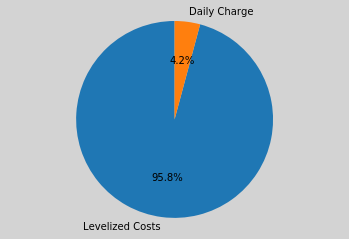

Total roof area of the  building: 599 m2
Total roof area used 464 m2
Percentage: 77.4%
succes
[[255.57218619945272, 183.4391736401554, 256.4381612576628, 33.1441154768823, 41.611919082185544, 54.49391604940743, 0.6629297738611697, 0.6623332475570631, 0.8144783664093027, 3183.4, 307.117, 0.0, 307.117, 0.0, {'Levelized Costs': 3050.348, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599966573835, 61845.7, 463.689]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (171.80744409032684, 180.01282536527154, 102.31398895845204, 13.555681134795451, 35.0582810167159, 14.319770876525926, 0.2155935089613696, 0.3308380845331192, 0.8123010026134649)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 13.6
                                           and a gcr of 0.216


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.637181282043457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 35.1
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.548161268234253 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 14.3
                                           and a gcr of 0.812


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5766139030456543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 180 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 147s


ERROR:ga_logger:panel relevance: [0.0, 111.174, 213.412]


ERROR:ga_logger:Cost: 3356.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,357 per year


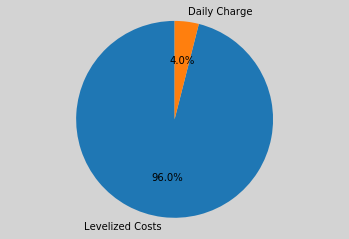

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[171.80744409032684, 180.01282536527154, 102.31398895845204, 13.555681134795451, 35.0582810167159, 14.319770876525926, 0.2155935089613696, 0.3308380845331192, 0.8123010026134649, 3356.9, 324.586, 0.0, 111.174, 213.412, {'Levelized Costs': 3223.8440000000005, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60181113986, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (122.16130329973296, 194.0975693339219, 188.50210178289927, 43.292619655627604, 44.74174900446039, 44.95914124998991, 0.6013477489911988, 0.6043728763696927, 0.7621895287735745)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 122
                                           a tilt of 43.3
                                           and a gcr of 0.601


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4741547107696533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 44.7
                                           and a gcr of 0.604


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3749847412109375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 45.0
                                           and a gcr of 0.762


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4114272594451904 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 311.461, 0.0]


ERROR:ga_logger:Cost: 3226.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,227 per year


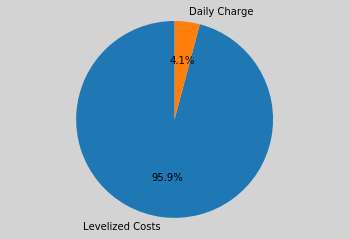

Total roof area of the  building: 599 m2
Total roof area used 515 m2
Percentage: 86.1%
succes
[[122.16130329973296, 194.0975693339219, 188.50210178289927, 43.292619655627604, 44.74174900446039, 44.95914124998991, 0.6013477489911988, 0.6043728763696927, 0.7621895287735745, 3226.55, 311.461, 0.0, 311.461, 0.0, {'Levelized Costs': 3093.4900000000002, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603603386844, 61845.7, 515.345]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115.94351492945128, 169.78954973049892, 115.67984810149667, 1.5389489081448406, 4.7718536594330185, 36.97692139577242, 0.4074982557572941, 0.5855967084213245, 0.33051649800081756)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 1.5
                                           and a gcr of 0.407


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.430446147918701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 4.8
                                           and a gcr of 0.586


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5646579265594482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 116
                                           a tilt of 37.0
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5786218643188477 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 323.216, 0.0]


ERROR:ga_logger:Cost: 3343.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,343 per year


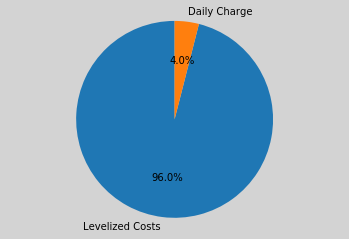

Total roof area of the  building: 599 m2
Total roof area used 552 m2
Percentage: 92.2%
succes
[[115.94351492945128, 169.78954973049892, 115.67984810149667, 1.5389489081448406, 4.7718536594330185, 36.97692139577242, 0.4074982557572941, 0.5855967084213245, 0.33051649800081756, 3343.31, 323.216, 0.0, 323.216, 0.0, {'Levelized Costs': 3210.2419999999997, 'Energy Charge': 0.026000000000067303, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60038155406, 61845.7, 551.944]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (262.14074230635384, 144.39139406915746, 218.32235234489016, 26.775934364927462, 38.59989187359015, 42.479324909221674, 0.6710209343679784, 0.5370332693005392, 0.688490939584742)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 26.8
                                           and a gcr of 0.671


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.75211763381958 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 38.6
                                           and a gcr of 0.537


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7444210052490234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 218
                                           a tilt of 42.5
                                           and a gcr of 0.688


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.66829514503479 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 133s


ERROR:ga_logger:panel relevance: [0.0, 314.433, 0.0]


ERROR:ga_logger:Cost: 3256.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,256 per year


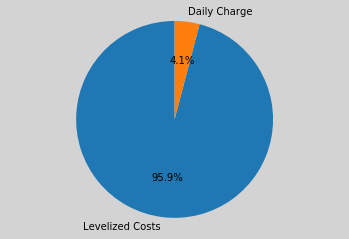

Total roof area of the  building: 599 m2
Total roof area used 585 m2
Percentage: 97.8%
succes
[[262.14074230635384, 144.39139406915746, 218.32235234489016, 26.775934364927462, 38.59989187359015, 42.479324909221674, 0.6710209343679784, 0.5370332693005392, 0.688490939584742, 3256.06, 314.433, 0.0, 314.433, 0.0, {'Levelized Costs': 3123.0029999999997, 'Energy Charge': 0.015000000000441105, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60003903997, 61845.7, 585.499]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (232.07073138944529, 109.80844716761672, 195.70992242147946, 13.864021806054911, 10.898406704440598, 15.671659840736467, 0.5485216381615503, 0.3697509102542795, 0.5988768646510467)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 232
                                           a tilt of 13.9
                                           and a gcr of 0.549


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.62906551361084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 10.9
                                           and a gcr of 0.370


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.528212070465088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 15.7
                                           and a gcr of 0.599


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6126465797424316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 182 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.645]


ERROR:ga_logger:Cost: 3178.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,179 per year


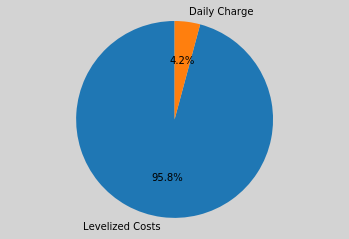

Total roof area of the  building: 599 m2
Total roof area used 512 m2
Percentage: 85.5%
succes
[[232.07073138944529, 109.80844716761672, 195.70992242147946, 13.864021806054911, 10.898406704440598, 15.671659840736467, 0.5485216381615503, 0.3697509102542795, 0.5988768646510467, 3178.71, 306.645, 0.0, 0.0, 306.645, {'Levelized Costs': 3045.639, 'Energy Charge': 0.02900000000011005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60384418173, 61845.7, 512.033]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (217.1357265689864, 191.6561271344908, 257.4328519205322, 31.759734401441705, 46.914932690813586, 53.85886749325401, 0.887690008659046, 0.6844673663717231, 0.8122866319777913)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 217
                                           a tilt of 31.8
                                           and a gcr of 0.888


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5540409088134766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 46.9
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.389084577560425 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 53.9
                                           and a gcr of 0.812


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5016942024230957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [0.0, 318.615, 0.0]


ERROR:ga_logger:Cost: 3297.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,298 per year


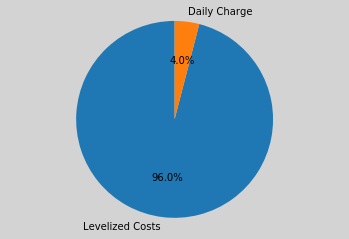

Total roof area of the  building: 599 m2
Total roof area used 465 m2
Percentage: 77.7%
succes
[[217.1357265689864, 191.6561271344908, 257.4328519205322, 31.759734401441705, 46.914932690813586, 53.85886749325401, 0.887690008659046, 0.6844673663717231, 0.8122866319777913, 3297.61, 318.615, 0.0, 318.615, 0.0, {'Levelized Costs': 3164.5579999999995, 'Energy Charge': 0.010000000000445652, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60296372958, 61845.7, 465.494]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (174.1278454349599, 166.53513658283822, 92.6853134688294, 21.443034228391014, 13.562016469037278, 3.6687114230821027, 0.642488537702693, 0.4006194309603173, 0.3070990543377259)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 174
                                           a tilt of 21.4
                                           and a gcr of 0.642


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5963921546936035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 13.6
                                           and a gcr of 0.401


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3941378593444824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 3.7
                                           and a gcr of 0.307


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.375178337097168 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [302.495, 0.0, 0.0]


ERROR:ga_logger:Cost: 3137.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,138 per year


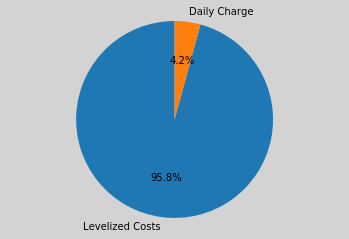

Total roof area of the  building: 599 m2
Total roof area used 471 m2
Percentage: 78.6%
succes
[[174.1278454349599, 166.53513658283822, 92.6853134688294, 21.443034228391014, 13.562016469037278, 3.6687114230821027, 0.642488537702693, 0.4006194309603173, 0.3070990543377259, 3137.5, 302.495, 302.495, 0.0, 0.0, {'Levelized Costs': 3004.443, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60209334374, 61845.7, 470.818]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.42359204003765, 128.1576888301773, 129.95493487428737, 42.99470069587528, 20.013608188600934, 42.18382081678422, 0.8781265554658422, 0.5042031901228361, 0.732506632043877)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 146
                                           a tilt of 43.0
                                           and a gcr of 0.878


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.526780128479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 128
                                           a tilt of 20.0
                                           and a gcr of 0.504


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5457375049591064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 42.2
                                           and a gcr of 0.733


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6904866695404053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 121s


ERROR:ga_logger:panel relevance: [43.0984, 277.151, 0.0]


ERROR:ga_logger:Cost: 3313.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,314 per year


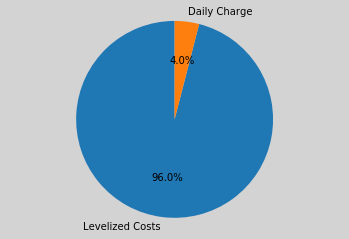

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[146.42359204003765, 128.1576888301773, 129.95493487428737, 42.99470069587528, 20.013608188600934, 42.18382081678422, 0.8781265554658422, 0.5042031901228361, 0.732506632043877, 3313.84, 320.24940000000004, 43.0984, 277.151, 0.0, {'Levelized Costs': 3180.7730000000006, 'Energy Charge': 0.024999999999806732, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59927303989, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (119.17861233802901, 103.30619664665326, 236.9667318656493, 30.080969952600515, 16.177055620651284, 37.02760302773926, 0.44192805760130527, 0.4279353833713217, 0.33131433156924783)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 30.1
                                           and a gcr of 0.442


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.575967311859131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 16.2
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4479782581329346 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 37.0
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7596209049224854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [264.61, 0.0, 0.0]


ERROR:ga_logger:Cost: 4194.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0232 /kWh
Total Cost of the system: $ 4,195 per year


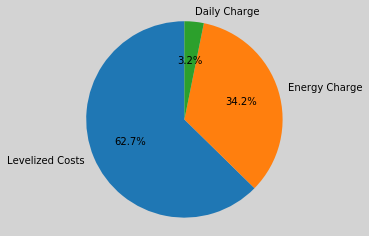

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[119.17861233802901, 103.30619664665326, 236.9667318656493, 30.080969952600515, 16.177055620651284, 37.02760302773926, 0.44192805760130527, 0.4279353833713217, 0.33131433156924783, 4194.51, 264.61, 264.61, 0.0, 0.0, {'Levelized Costs': 2628.1560000000004, 'Energy Charge': 1433.3120000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 50406.67538108013, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (234.30540287838883, 180.1624847690735, 161.73438576541838, 42.36027110382975, 26.30753468987291, 29.09209620457893, 0.6890042015588089, 0.6315732511483539, 0.5799395419599926)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 234
                                           a tilt of 42.4
                                           and a gcr of 0.689


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.61332106590271 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 26.3
                                           and a gcr of 0.632


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.514616012573242 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 29.1
                                           and a gcr of 0.580


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.440098762512207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 126s


ERROR:ga_logger:panel relevance: [0.0, 298.852, 0.0]


ERROR:ga_logger:Cost: 3101.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,101 per year


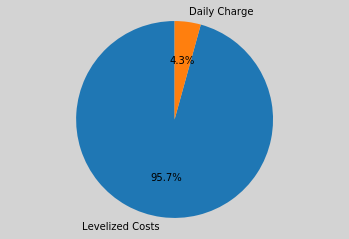

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%
succes
[[234.30540287838883, 180.1624847690735, 161.73438576541838, 42.36027110382975, 26.30753468987291, 29.09209620457893, 0.6890042015588089, 0.6315732511483539, 0.5799395419599926, 3101.31, 298.852, 0.0, 298.852, 0.0, {'Levelized Costs': 2968.2580000000003, 'Energy Charge': 0.009999999999934062, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60441669817, 61845.7, 473.186]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (151.2327590591723, 163.17848840423136, 112.93494169943136, 22.543346335634606, 7.504993304313466, 13.801979665887249, 0.24717207400056018, 0.4921236423074262, 0.5311170682031414)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 22.5
                                           and a gcr of 0.247


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8335788249969482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 7.5
                                           and a gcr of 0.492


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5012149810791016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 113
                                           a tilt of 13.8
                                           and a gcr of 0.531


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.530142068862915 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 185 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.013]


ERROR:ga_logger:Cost: 3475.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0030 /kWh
Total Cost of the system: $ 3,476 per year


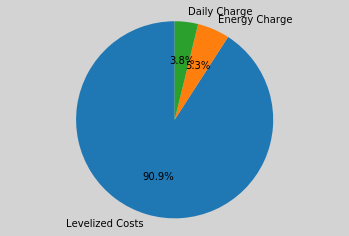

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[151.2327590591723, 163.17848840423136, 112.93494169943136, 22.543346335634606, 7.504993304313466, 13.801979665887249, 0.24717207400056018, 0.4921236423074262, 0.5311170682031414, 3475.51, 318.013, 0.0, 0.0, 318.013, {'Levelized Costs': 3158.5750000000003, 'Energy Charge': 183.89300000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60378.001023249926, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (233.64672679932147, 203.03206348412976, 204.69635080886167, 33.16602556796512, 51.93878893325097, 16.571067000920817, 0.8704772242718346, 0.8975373358571563, 0.8251925461456247)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 234
                                           a tilt of 33.2
                                           and a gcr of 0.870


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7644152641296387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 51.9
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6787712574005127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 16.6
                                           and a gcr of 0.825


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7478394508361816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 122s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.577]


ERROR:ga_logger:Cost: 3297.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,297 per year


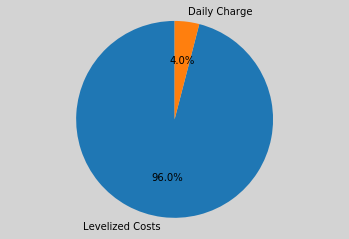

Total roof area of the  building: 599 m2
Total roof area used 386 m2
Percentage: 64.5%
succes
[[233.64672679932147, 203.03206348412976, 204.69635080886167, 33.16602556796512, 51.93878893325097, 16.571067000920817, 0.8704772242718346, 0.8975373358571563, 0.8251925461456247, 3297.23, 318.577, 0.0, 0.0, 318.577, {'Levelized Costs': 3164.175, 'Energy Charge': 0.012999999999806278, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60185106136, 61845.7, 386.064]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (206.21274577078373, 101.60852469151833, 153.64722753895614, 19.71926843537612, 50.41179763833182, 7.428017160010846, 0.7166310242086129, 0.5439279209397081, 0.49603664677874015)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 19.7
                                           and a gcr of 0.717


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6190078258514404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 102
                                           a tilt of 50.4
                                           and a gcr of 0.544


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.549452304840088 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 7.4
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4300734996795654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 140s


ERROR:ga_logger:panel relevance: [312.058, 0.0, 0.0]


ERROR:ga_logger:Cost: 3232.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,232 per year


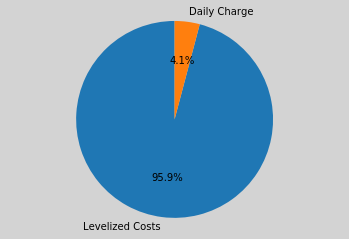

Total roof area of the  building: 599 m2
Total roof area used 435 m2
Percentage: 72.7%
succes
[[206.21274577078373, 101.60852469151833, 153.64722753895614, 19.71926843537612, 50.41179763833182, 7.428017160010846, 0.7166310242086129, 0.5439279209397081, 0.49603664677874015, 3232.47, 312.058, 312.058, 0.0, 0.0, {'Levelized Costs': 3099.4139999999998, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60295847357, 61845.7, 435.451]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (99.70499438634266, 133.10666516519467, 193.26519741373554, 47.65528383790398, 50.82121605122251, 7.426779470621631, 0.8581645967343541, 0.5322674410022423, 0.8590045529788952)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 47.7
                                           and a gcr of 0.858


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5566627979278564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 50.8
                                           and a gcr of 0.532


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4261300563812256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 7.4
                                           and a gcr of 0.859


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5812931060791016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 321.834]


ERROR:ga_logger:Cost: 3329.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,330 per year


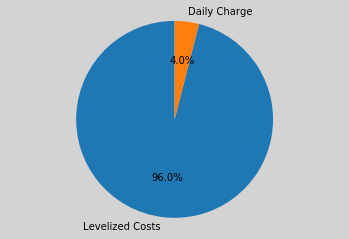

Total roof area of the  building: 599 m2
Total roof area used 375 m2
Percentage: 62.6%
succes
[[99.70499438634266, 133.10666516519467, 193.26519741373554, 47.65528383790398, 50.82121605122251, 7.426779470621631, 0.8581645967343541, 0.5322674410022423, 0.8590045529788952, 3329.57, 321.834, 0.0, 0.0, 321.834, {'Levelized Costs': 3196.5170000000003, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60125579914, 61845.7, 374.659]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (181.5800551355366, 101.60852469151833, 155.4854647215574, 42.98065996213397, 28.265099292284784, 5.6637945946363235, 0.38127076158049605, 0.23707092266982693, 0.49925006171403385)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 43.0
                                           and a gcr of 0.381


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.779196262359619 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 102
                                           a tilt of 28.3
                                           and a gcr of 0.237


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6188762187957764 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 5.7
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.523587703704834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 298.932]


ERROR:ga_logger:Cost: 3651.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0089 /kWh
Total Cost of the system: $ 3,652 per year


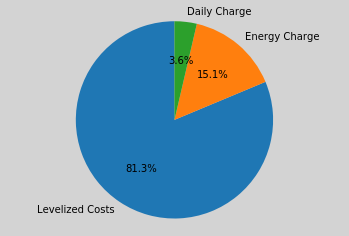

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[181.5800551355366, 101.60852469151833, 155.4854647215574, 42.98065996213397, 28.265099292284784, 5.6637945946363235, 0.38127076158049605, 0.23707092266982693, 0.49925006171403385, 3651.91, 298.932, 0.0, 0.0, 298.932, {'Levelized Costs': 2969.039, 'Energy Charge': 549.829, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57457.68558439006, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (227.45176954766464, 199.76961383792545, 95.64722448301235, 32.61981217152276, 28.97709431534041, 23.960495132796837, 0.6659989770812169, 0.6080655547262659, 0.7793921927569158)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 227
                                           a tilt of 32.6
                                           and a gcr of 0.666


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9582879543304443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 29.0
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7745590209960938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 24.0
                                           and a gcr of 0.779


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.780843496322632 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [0.0, 303.727, 0.0]


ERROR:ga_logger:Cost: 3149.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,150 per year


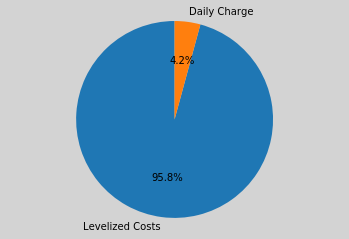

Total roof area of the  building: 599 m2
Total roof area used 499 m2
Percentage: 83.4%
succes
[[227.45176954766464, 199.76961383792545, 95.64722448301235, 32.61981217152276, 28.97709431534041, 23.960495132796837, 0.6659989770812169, 0.6080655547262659, 0.7793921927569158, 3149.74, 303.727, 0.0, 303.727, 0.0, {'Levelized Costs': 3016.687, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60186255234, 61845.7, 499.498]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (178.15070628170776, 162.57394571765505, 227.9010923071496, 10.950874593821986, 50.57512468710951, 8.99069528590179, 0.2643838969766344, 0.47879705689841734, 0.21388751439798176)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 11.0
                                           and a gcr of 0.264


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6572964191436768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 50.6
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.541945219039917 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 228
                                           a tilt of 9.0
                                           and a gcr of 0.214


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.740610361099243 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 286.685, 0.0]


ERROR:ga_logger:Cost: 3640.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0107 /kWh
Total Cost of the system: $ 3,640 per year


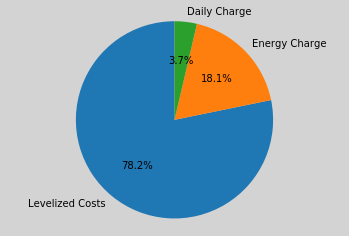

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[178.15070628170776, 162.57394571765505, 227.9010923071496, 10.950874593821986, 50.57512468710951, 8.99069528590179, 0.2643838969766344, 0.47879705689841734, 0.21388751439798176, 3640.25, 286.685, 0.0, 286.685, 0.0, {'Levelized Costs': 2847.411, 'Energy Charge': 659.797, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56579.98212910011, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (228.4947205153843, 193.89921155375782, 232.12545700303332, 51.77987933320843, 19.662175755309093, 16.42141527025139, 0.88901857153695, 0.6905433389008139, 0.35082790166196137)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 51.8
                                           and a gcr of 0.889


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6979823112487793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 19.7
                                           and a gcr of 0.691


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6327812671661377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 232
                                           a tilt of 16.4
                                           and a gcr of 0.351


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.999370813369751 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 306.242, 0.0]


ERROR:ga_logger:Cost: 3174.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,175 per year


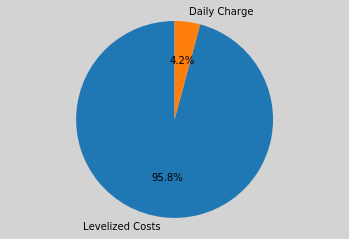

Total roof area of the  building: 599 m2
Total roof area used 443 m2
Percentage: 74.1%
succes
[[228.4947205153843, 193.89921155375782, 232.12545700303332, 51.77987933320843, 19.662175755309093, 16.42141527025139, 0.88901857153695, 0.6905433389008139, 0.35082790166196137, 3174.71, 306.242, 0.0, 306.242, 0.0, {'Levelized Costs': 3041.6549999999997, 'Energy Charge': 0.013000000000488399, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60110976351, 61845.7, 443.48]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (166.22600286138902, 156.29787926509255, 99.74615575040465, 32.852833331759456, 16.80272017862626, 2.440324500850254, 0.7284389439457398, 0.8371924694635883, 0.2072466508087262)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 32.9
                                           and a gcr of 0.728


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7671773433685303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 156
                                           a tilt of 16.8
                                           and a gcr of 0.837


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6258652210235596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 2.4
                                           and a gcr of 0.207


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5492892265319824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [310.849, 0.0, 0.0]


ERROR:ga_logger:Cost: 3220.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,220 per year


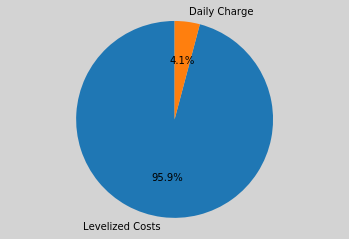

Total roof area of the  building: 599 m2
Total roof area used 427 m2
Percentage: 71.3%
succes
[[166.22600286138902, 156.29787926509255, 99.74615575040465, 32.852833331759456, 16.80272017862626, 2.440324500850254, 0.7284389439457398, 0.8371924694635883, 0.2072466508087262, 3220.47, 310.849, 310.849, 0.0, 0.0, {'Levelized Costs': 3087.416, 'Energy Charge': 0.011999999999659394, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60131160006, 61845.7, 426.734]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250.57950658566367, 137.17111427003442, 237.95271225886592, 35.92021346732355, 42.74264684798041, 13.543519563536881, 0.6737343877768316, 0.5686968848116717, 0.8020084430769547)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 35.9
                                           and a gcr of 0.674


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6821916103363037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 137
                                           a tilt of 42.7
                                           and a gcr of 0.569


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5255346298217773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 238
                                           a tilt of 13.5
                                           and a gcr of 0.802


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.230117082595825 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 328.552, 0.0]


ERROR:ga_logger:Cost: 3396.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,396 per year


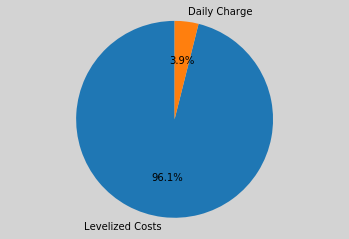

Total roof area of the  building: 599 m2
Total roof area used 578 m2
Percentage: 96.5%
succes
[[250.57950658566367, 137.17111427003442, 237.95271225886592, 35.92021346732355, 42.74264684798041, 13.543519563536881, 0.6737343877768316, 0.5686968848116717, 0.8020084430769547, 3396.3, 328.552, 0.0, 328.552, 0.0, {'Levelized Costs': 3263.2470000000003, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60255317195, 61845.7, 577.728]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (212.29114643521652, 121.64866289497392, 153.0165179263963, 21.483611860049756, 40.362395519833115, 37.2766840951791, 0.3388962355051184, 0.25503797871306727, 0.8516898032138658)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 21.5
                                           and a gcr of 0.339


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.954904794692993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 122
                                           a tilt of 40.4
                                           and a gcr of 0.255


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4964218139648438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 153
                                           a tilt of 37.3
                                           and a gcr of 0.852


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.52830171585083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [123.753, 0.0, 198.951]


ERROR:ga_logger:Cost: 3338.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,338 per year


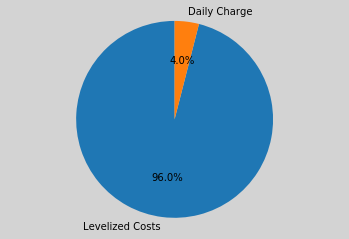

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[212.29114643521652, 121.64866289497392, 153.0165179263963, 21.483611860049756, 40.362395519833115, 37.2766840951791, 0.3388962355051184, 0.25503797871306727, 0.8516898032138658, 3338.22, 322.704, 123.753, 0.0, 198.951, {'Levelized Costs': 3205.163, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598210093456, 61845.7, 598.762]]


ERROR:optimizer_logger:200


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 8 using opt-method ga-100 with 200 evalautions took: (min)


ERROR:Runs_logger:1581.6130699952444


In [29]:
# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE")
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)